<a href="https://colab.research.google.com/github/CalculatedContent/ww-colab/blob/master/ww_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import time
import datetime as dt
import itertools
from google.colab import files #Google colab ONLY

In [0]:
## If export the output to Google Drive (colab ONLY)
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive')

In [0]:
# !pip install weightwatcher #install from source
!pip install powerlaw #needed if install ww from local

In [5]:
import weightwatcher as ww

Using TensorFlow backend.


## **1. Analyze all models in Pytorchcv**

In [0]:
!pip install pytorchcv

In [0]:
## Check storage
#import subprocess
#p = subprocess.Popen('df -h', shell=True, stdout=subprocess.PIPE)
#print(str(p.communicate()[0], 'utf-8'))

In [0]:
# Suppress the powerlaw package warnings
# "powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide"
# "powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide"
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# crea
import logging
logger = logging.getLogger("imported_module")
logger.setLevel(logging.CRITICAL)

In [8]:
from pytorchcv.model_provider import get_model as ptcv_get_model
import torch

Using TensorFlow backend.


In [0]:
import pytorchcv
import pytorchcv.models.model_store

In [10]:
modelnames = pytorchcv.models.model_store._model_sha1.keys()
modelnames = list(modelnames)
print('{} models to examine'.format(len(modelnames)))

444 models to examine


In [0]:
'''Clear memory'''
try:
    !rm -rf /root/.torch/models
except:
    pass

In [0]:
## Takes about 8-10 hours to run 444 models as of 9/3/2019

data = {}
ss = time.time()
i = 0
start = i
notfound = []
for modelname in modelnames[start:]:
    print(modelname)
    try:
        s = time.time()
        model = ptcv_get_model(modelname, pretrained=True)
        watcher = ww.WeightWatcher(model=model, logger=logger)
        results = watcher.analyze(compute_alphas = True, compute_spectralnorms=True, compute_softranks=True)
        e = time.time()
        
        data[modelname]=watcher.get_summary()
        
        print('time spent is {}'.format((e-s)/60.))
        print('--------------------------------------------------------')
        
    except:
        notfound.append(modelname)
        e = time.time()
        print("{} not found".format(modelname))
        
    i += 1

    #Export/backup the results every 1 hour runtime or every 50 models  
    if ((e - ss) > 60*60) or ((i - start)%50 == 0): 
      
        ddf = pd.DataFrame.from_dict(data).transpose()
        ddf.to_excel('/content/drive/My Drive/data_{}-{}_{}.xlsx'.format(start, i, dt.date.today()))
        
        ss = time.time()
          
    if i >= 250:#len(modelnames): #Export when all models are finished
      
        ddf = pd.DataFrame.from_dict(data).transpose()
        ddf.to_excel('/content/drive/My Drive/data_{}-{}_{}.xlsx'.format(start, i, dt.date.today()))
        
        break

In [0]:
## Export mannually
#ddf = pd.DataFrame.from_dict(data).transpose()
#ddf.to_excel('data.xlsx')
#files.download('/content/data.xlsx')

In [0]:
## Get the modelname of outliers
# temp = df_all.copy()
# temp = temp.sort_values(['softrank'], ascending = False)
# outliers_sr = temp['modelname'].tolist()[:10]

# temp = temp.sort_values(['spectralnorm'], ascending = False)
# outliers_sp = temp['modelname'].tolist()[:10]

# [s for s in outliers_sp if s not in outliers_sr]

In [0]:
## Get the details of outliers
# writer = pd.ExcelWriter('/content/drive/My Drive/sp_outliers.xlsx')
# for s in [s for s in outliers_sp if s not in outliers_sr]:#outliers:
#     model = ptcv_get_model(s, pretrained=True) #'resnet542bn_svhn'
#     watcher = ww.WeightWatcher(model=model, logger=logger)
#     results = watcher.analyze(compute_alphas = False, compute_spectralnorms=True, compute_softranks=True)
    
#     temp1 = watcher.get_details()
#     temp1.to_excel(writer, s)
    
# writer.save()

In [0]:
## Load the model results data
df_all = pd.read_excel('/content/drive/My Drive/df_all.xlsx')\
      .rename(columns = {'Unnamed: 0': 'index'}).set_index('index')

## **2. Plots with Test Accuracies**

In [0]:
from bs4 import BeautifulSoup
import requests
import re
import matplotlib.pyplot as plt

In [0]:
'''Load the test accuracies'''
url = "https://github.com/osmr/imgclsmob/blob/master/pytorch/README.md"
df_accuracy = pd.read_html(url)

In [0]:
'''Create the matchtable: Match the model name'''
response = requests.get(url)
page = str(BeautifulSoup(response.content, features="lxml"))

## To find the category of models to group when plotting
models = re.findall('<li>(.*) \(<a href=', page) 

## The naming convention is not very consistent, therefore, to help with identification,
## I input the exceptions
exceptions = {'SqueezeNext': 'SqNxt', 'DIA-ResNet': 'DIA-PreResNet', 
              'DarkNet Ref/Tiny/19': 'DarkNet Tiny', 
              'IBN-ResNet/IBN-ResNeXt/IBN-DenseNet': 'IBN(b)-ResNet'} 
models_ = [m if m not in exceptions.keys() else m+'/'+exceptions[m] for m in models]
models_ = [m.split('/') for m in models_]

## Use reg exp to extract the dataset name, modelnames (used in README), and 
## modelnames (used in codes)
datasets = re.findall('<h3><a aria-hidden="true" class="anchor" href="#(.*)" id', page)
lst1_name = re.findall('<tr>\n<td>(.*)</td>', page)
lst2_name = re.findall('\n<td>.* \(<a href="(.*)">log</a>\)</td>\n</tr>', page)

if len(lst1_name) != len(lst2_name):
    print('Number does not match!')

df_table = pd.DataFrame(lst1_name, columns = ['Model'])

## Note: there are duplicate Model names, hence cannot use merge naively
df_table['modelname'] = [m.split('/')[-1][:-22] for m in lst2_name]

In [0]:
'''Identify the architexture for each pretrained model'''
class ContinueI(Exception):
    pass

continue_i = ContinueI()

arch = []
for i in range(len(df_table)):
    try:
        for mm in models_:
            for m1 in mm:
                ## Name convention 1: the model name starts with the arch name
                if df_table.loc[i, 'Model'].startswith(m1): 
                    arch.append(mm)
                    raise continue_i
        try:
            ## Name convention 2: if the model name starts with number, 
            ## the arch name is in the middle of the model name
            this = re.findall('[0-9]+-(.*)', df_table.loc[i, 'Model'])[0]
        except:
            arch.append(np.nan)
            raise continue_i

        for mm in models_:
            for m1 in mm:
                if this.startswith(m1):
                    arch.append(mm)

                    raise continue_i

        arch.append(np.nan)

    except ContinueI:
        continue

df_table['group'] = arch
df_table['group'] = df_table['group'].apply(lambda x: '/'.join(x))


In [0]:
'''Match the model name using matchtable'''

df_full = []
i = 0

for df in df_accuracy:
    # Because there are duplicate Model names (on README), you cannot
    # simply use merge
    df = df.copy()
    df['modelname'] = df_table.loc[i:i+len(df)-1, 'modelname'].tolist()#temp[i:i+len(df)]
    df['group'] = df_table.loc[i:i+len(df)-1, 'group'].tolist()
    i += len(df)

    del df['Remarks']

    df = df.merge(df_all, on = 'modelname', how = 'left')

    df_full.append(df)

df_full = dict(zip(datasets, df_full))


In [0]:
'''[SETUP CELL] Start Plotting'''
metrics = ['alpha', 'alpha_weighted', 'spectralnorm', 'softrank'] #specify the ww matrics
metrics_acc = ['Top1', 'Top5', 'Error, %', 'Pix.Acc.,%', 'mIoU,%'] #specify the test accuracy

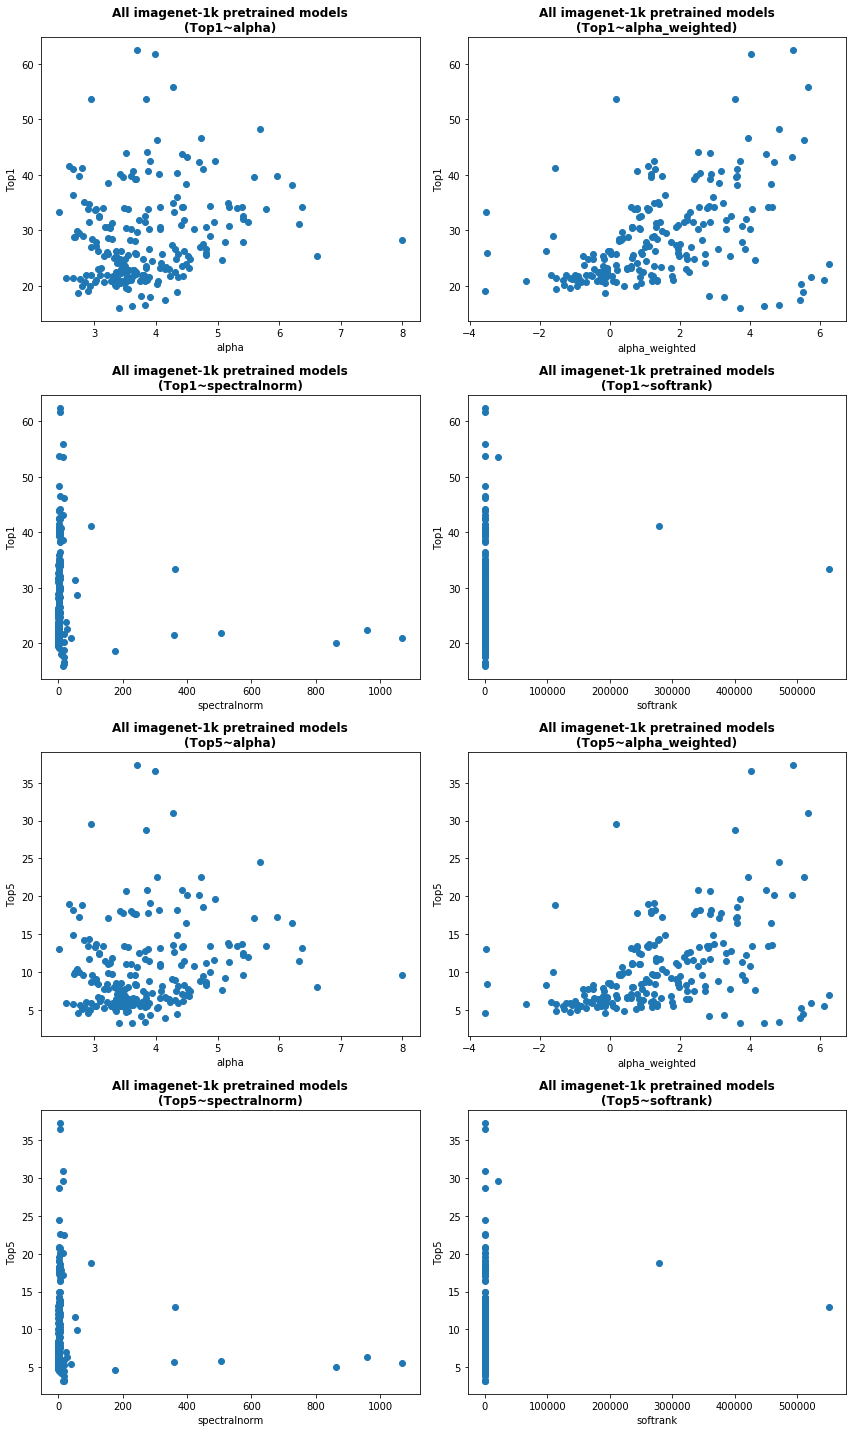

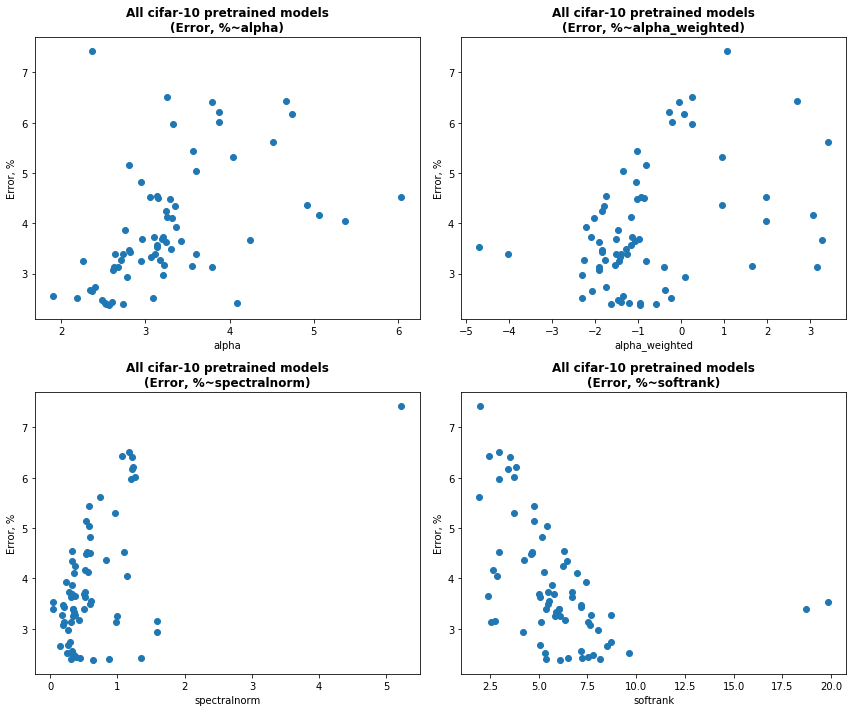

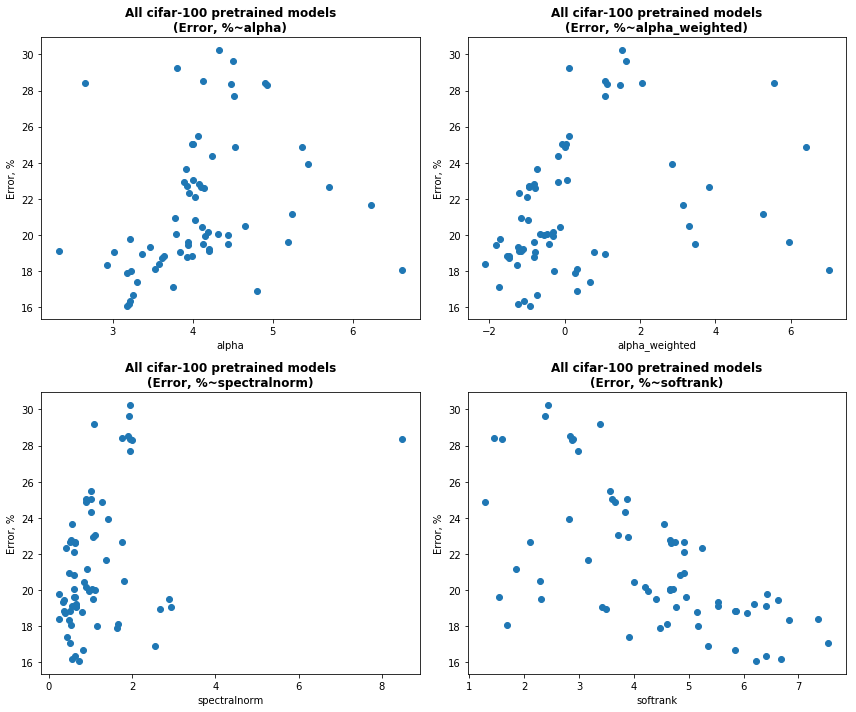

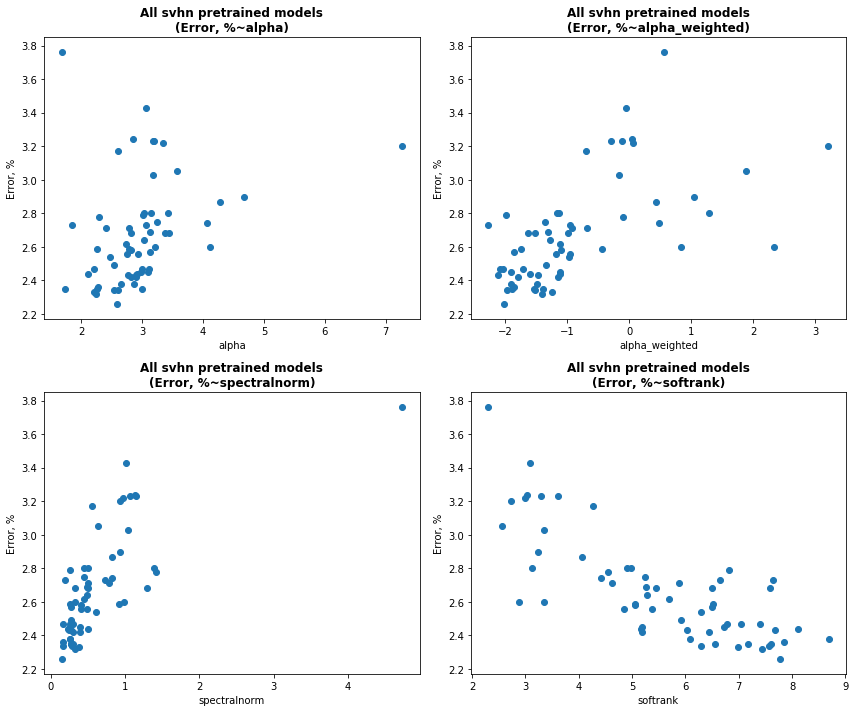

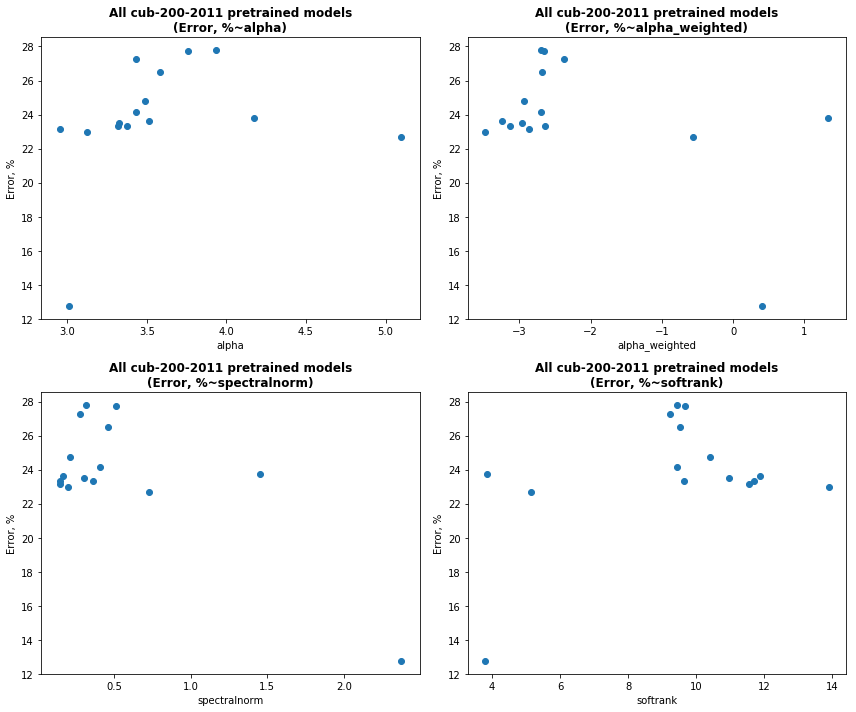

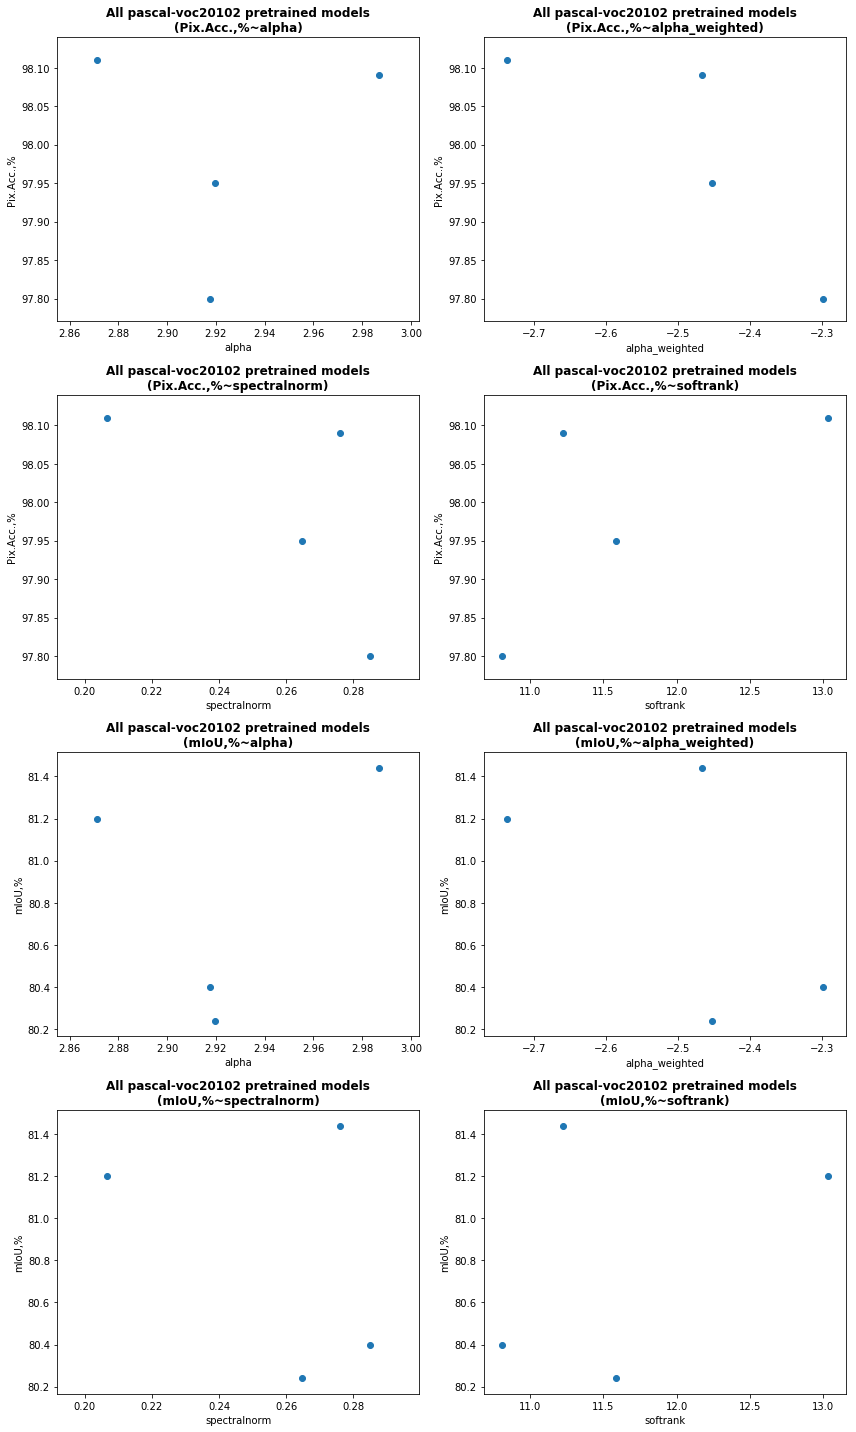

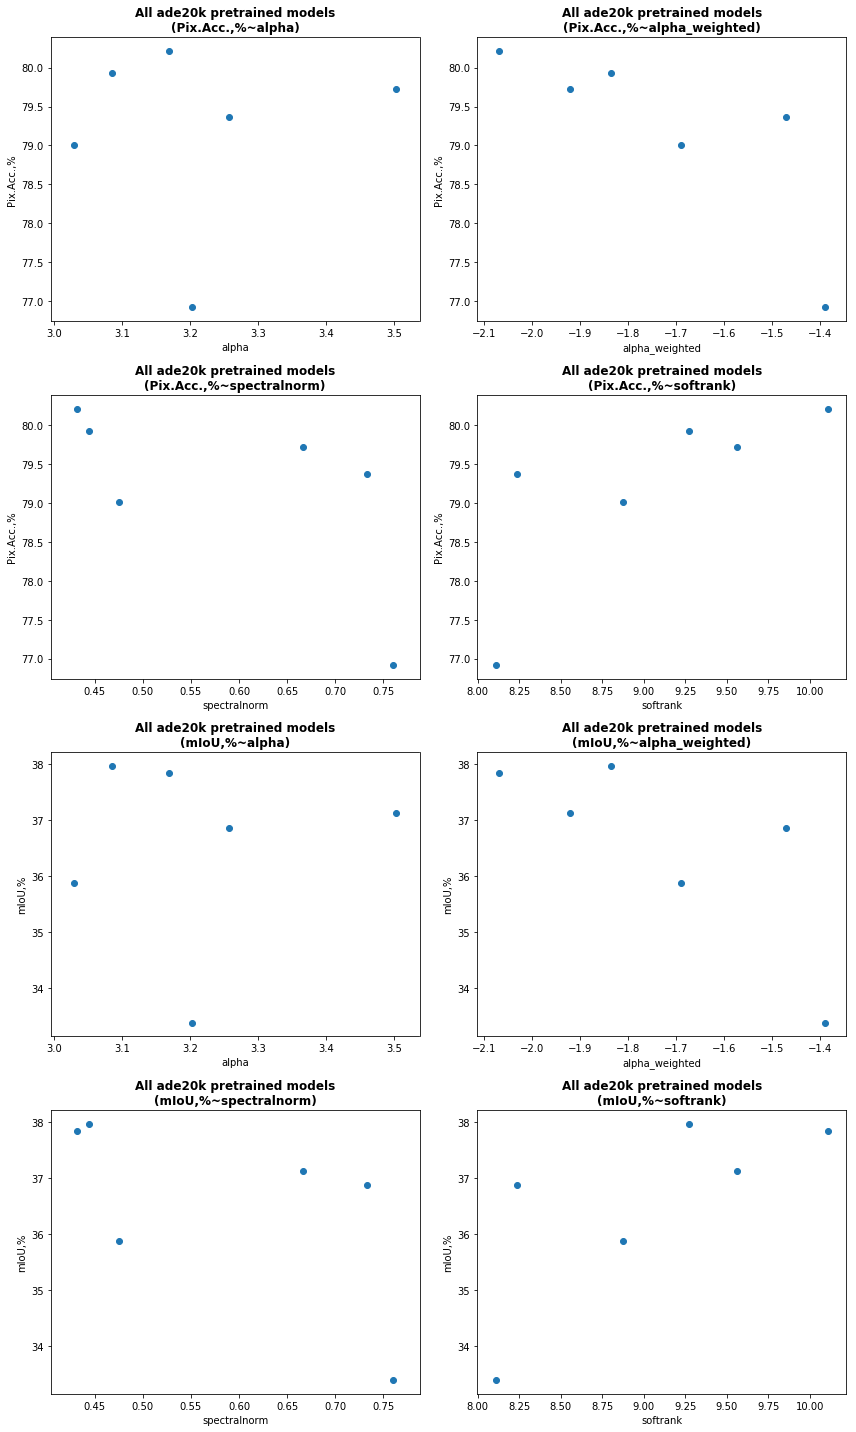

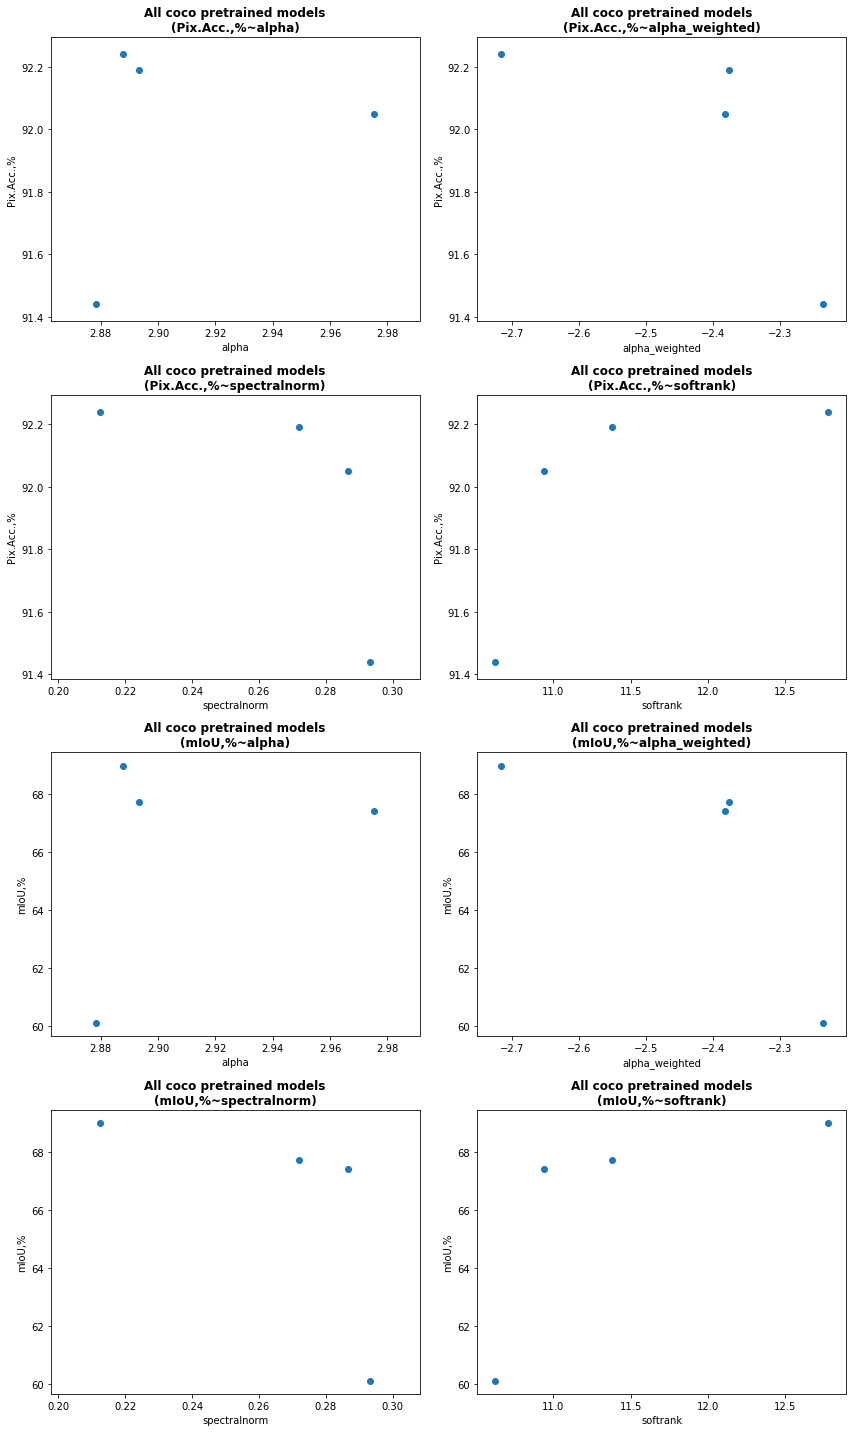

In [13]:
%matplotlib inline

'''Plotting by datasets'''
for d in datasets:
    temp = df_full[d].copy()

    if len(temp) == 1:
        continue

    tacc = [c for c in metrics_acc if c in temp.columns]

    plotloc = int(len(tacc)*len(metrics)/2*100 + 20 + 1)

    if len(tacc) > 1:
        plt.figure(figsize = (12,20))
    else:
        plt.figure(figsize = (12,10))
    for ac in tacc:#metrics_acc:
        for x in metrics:
            plt.subplot(plotloc)
            plt.scatter(temp[x], temp[ac])
            plt.xlabel(x)
            plt.ylabel(ac)
            plt.title('All {} pretrained models\n({}~{})'.format(d, ac, x), 
                      fontweight = 'bold')

            plotloc += 1

    plt.tight_layout()

del temp
del tacc         

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


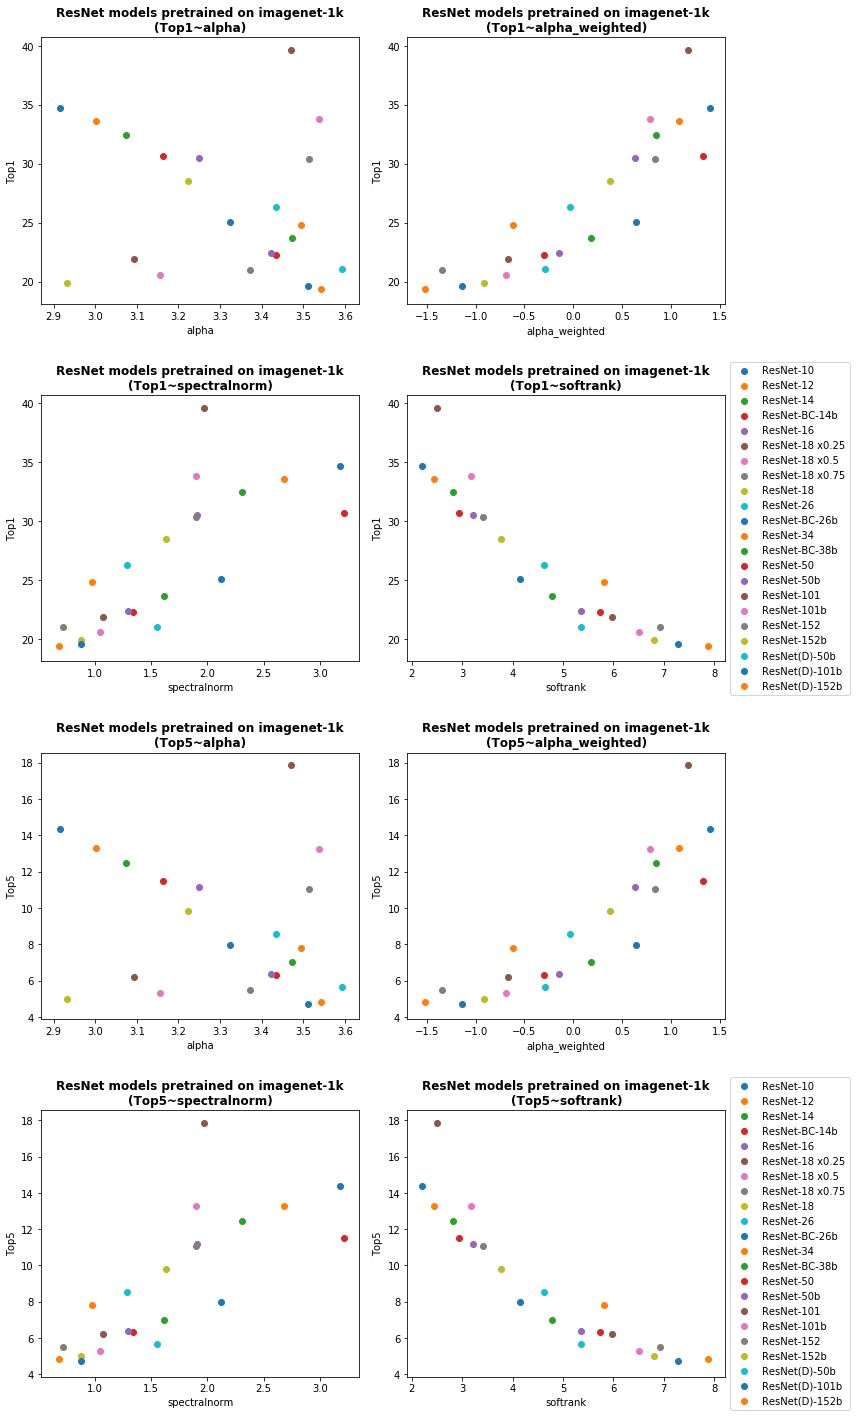

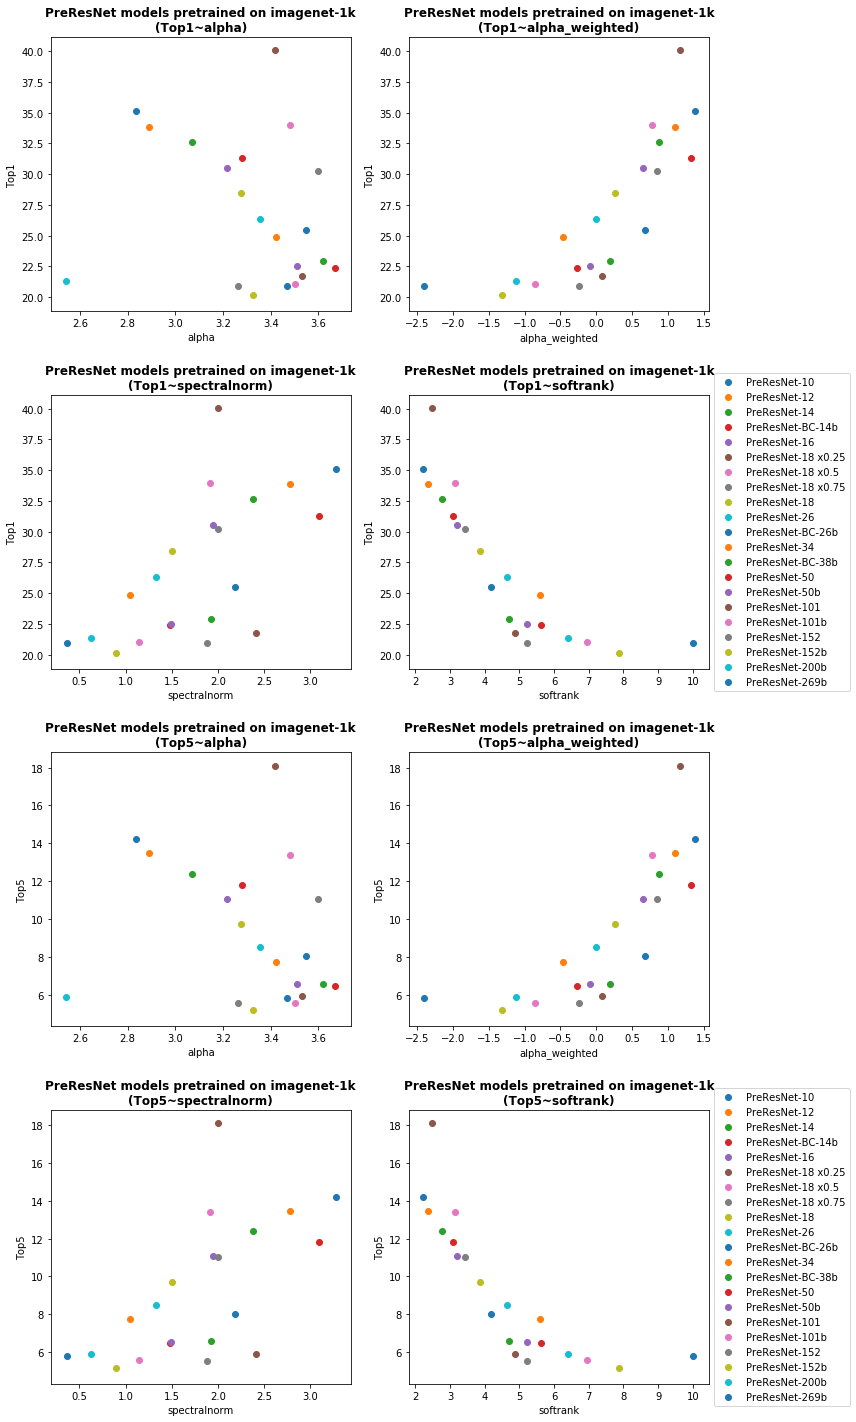

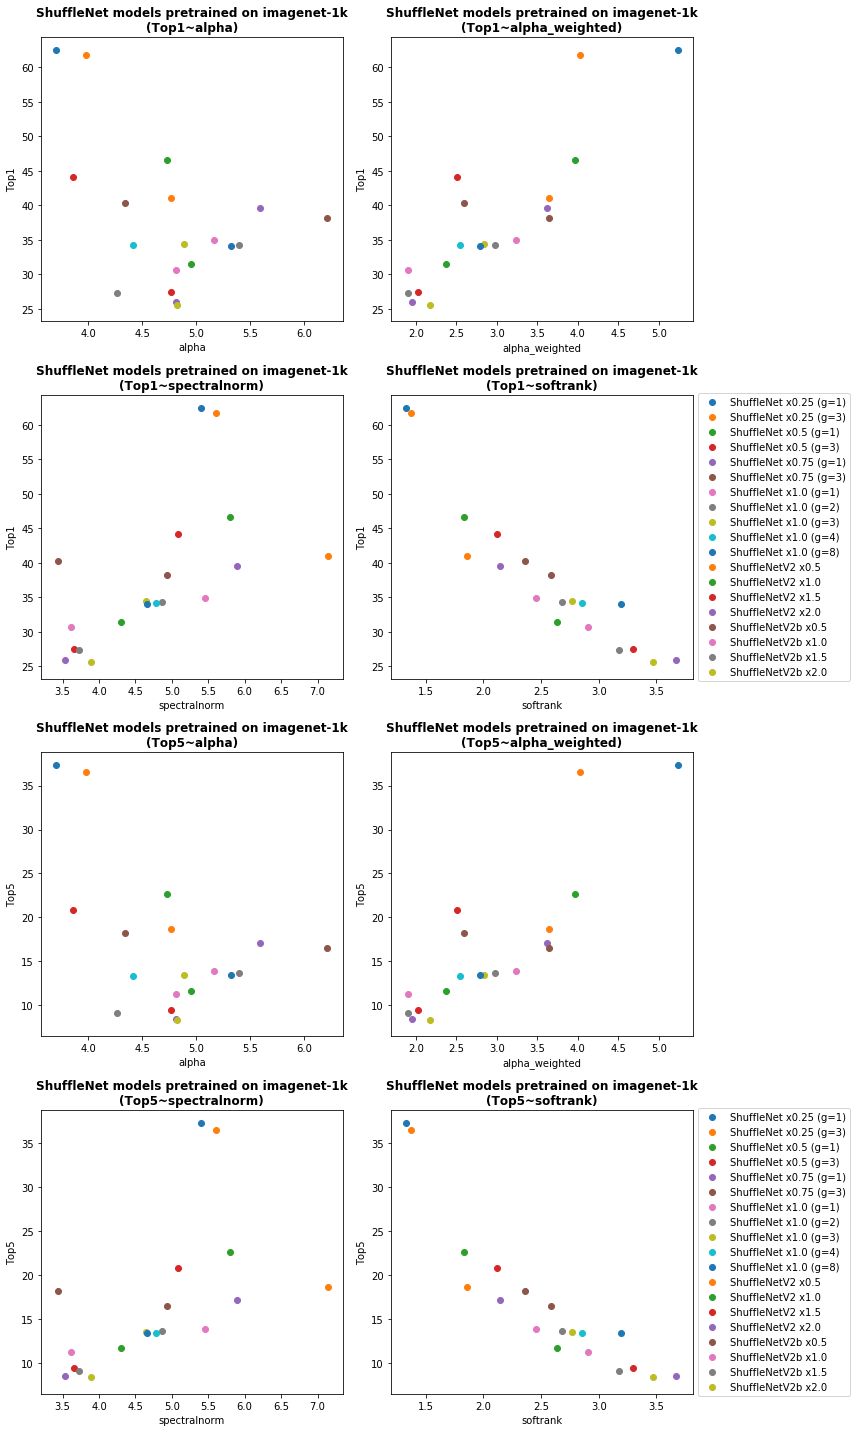

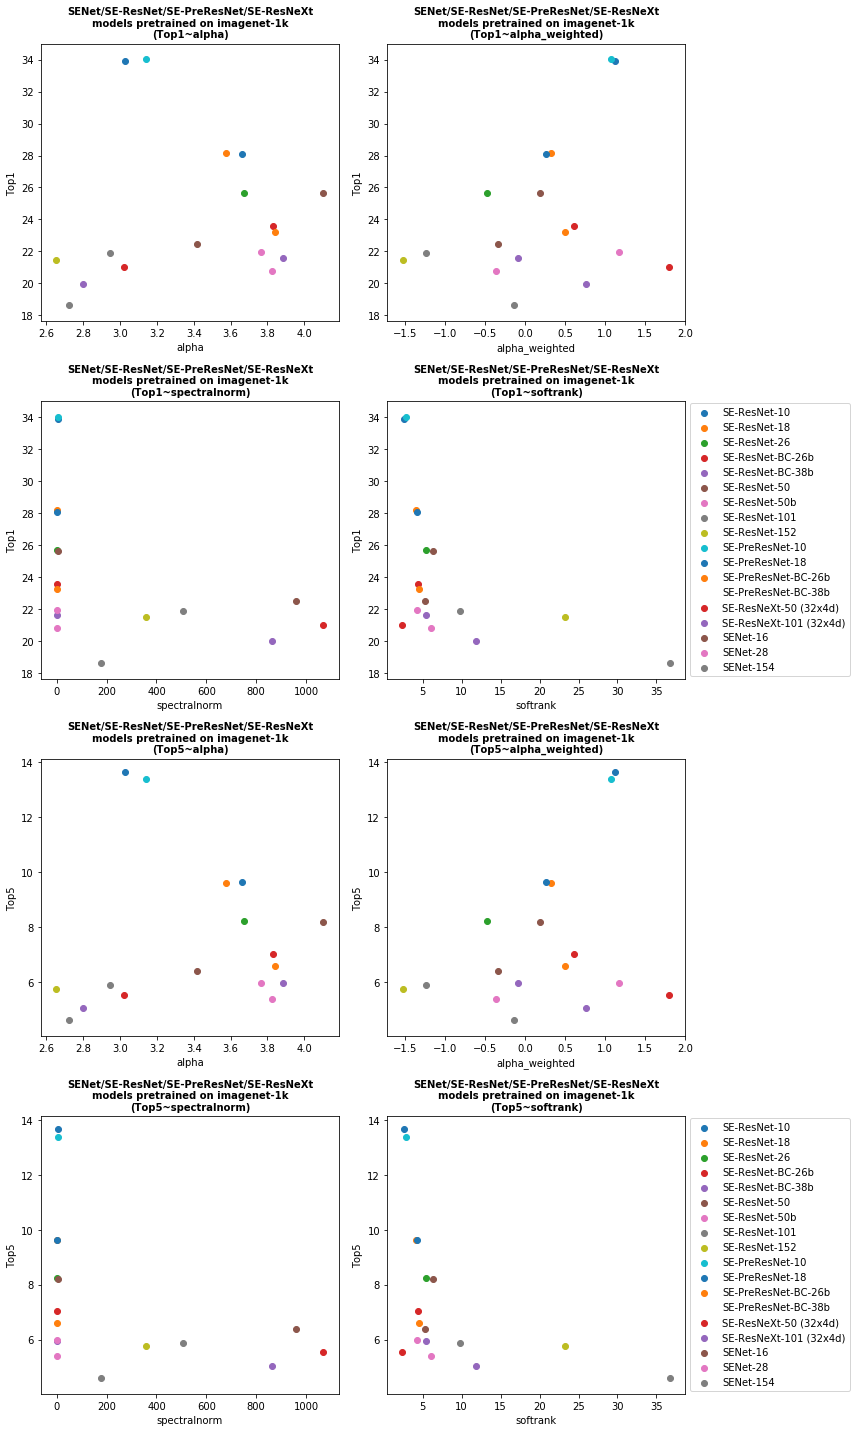

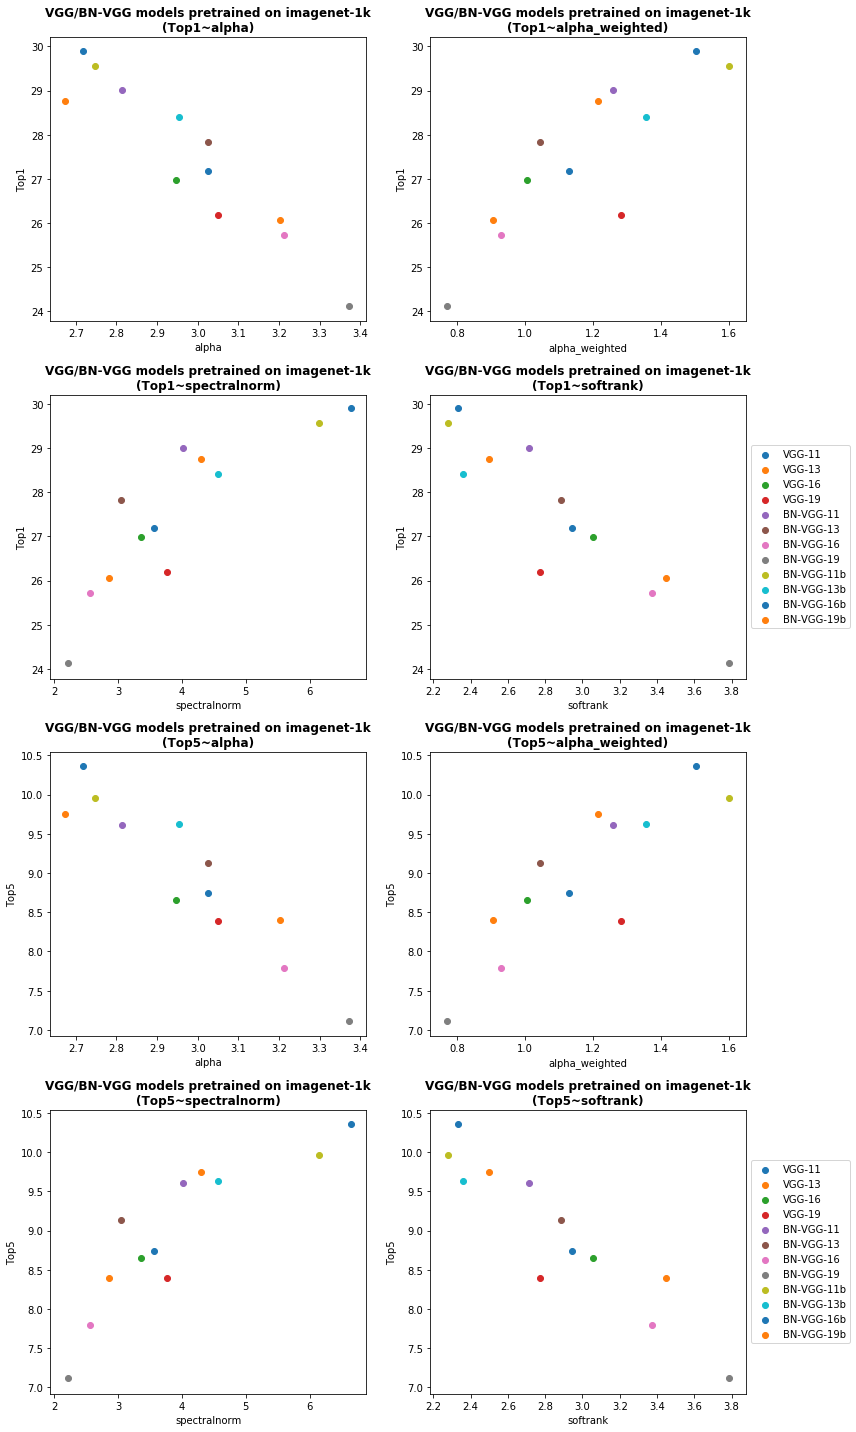

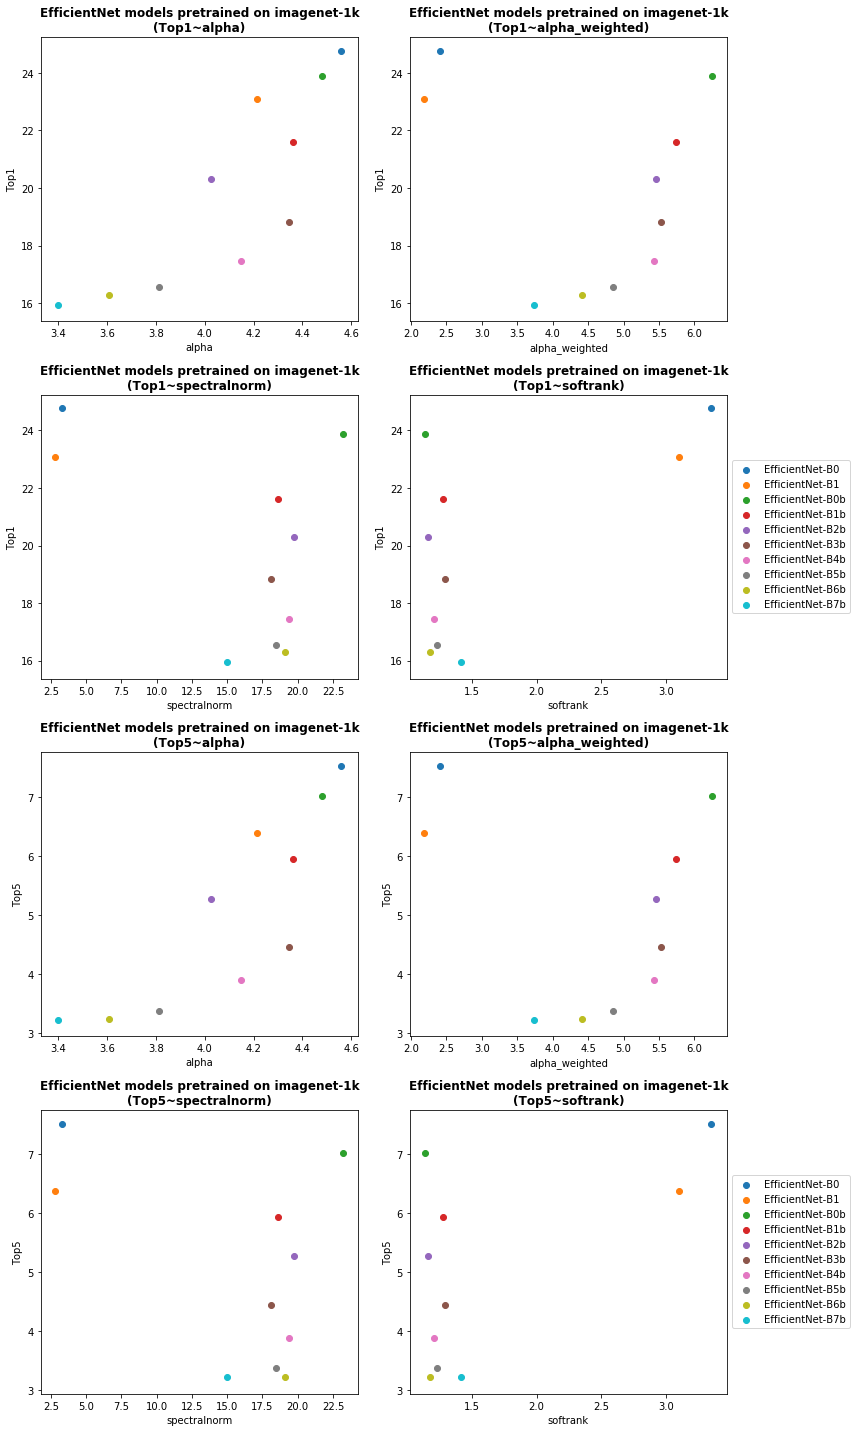

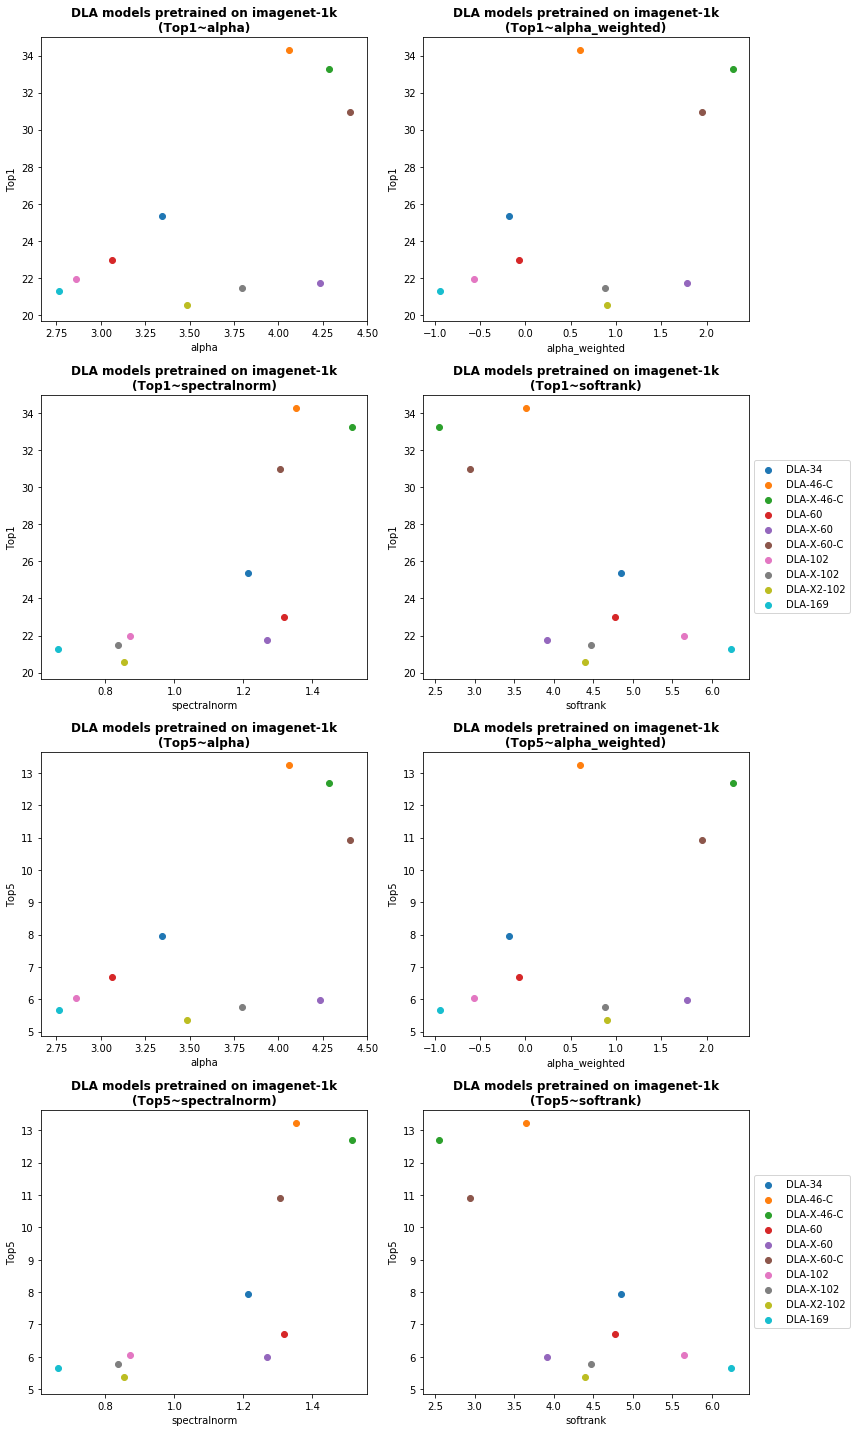

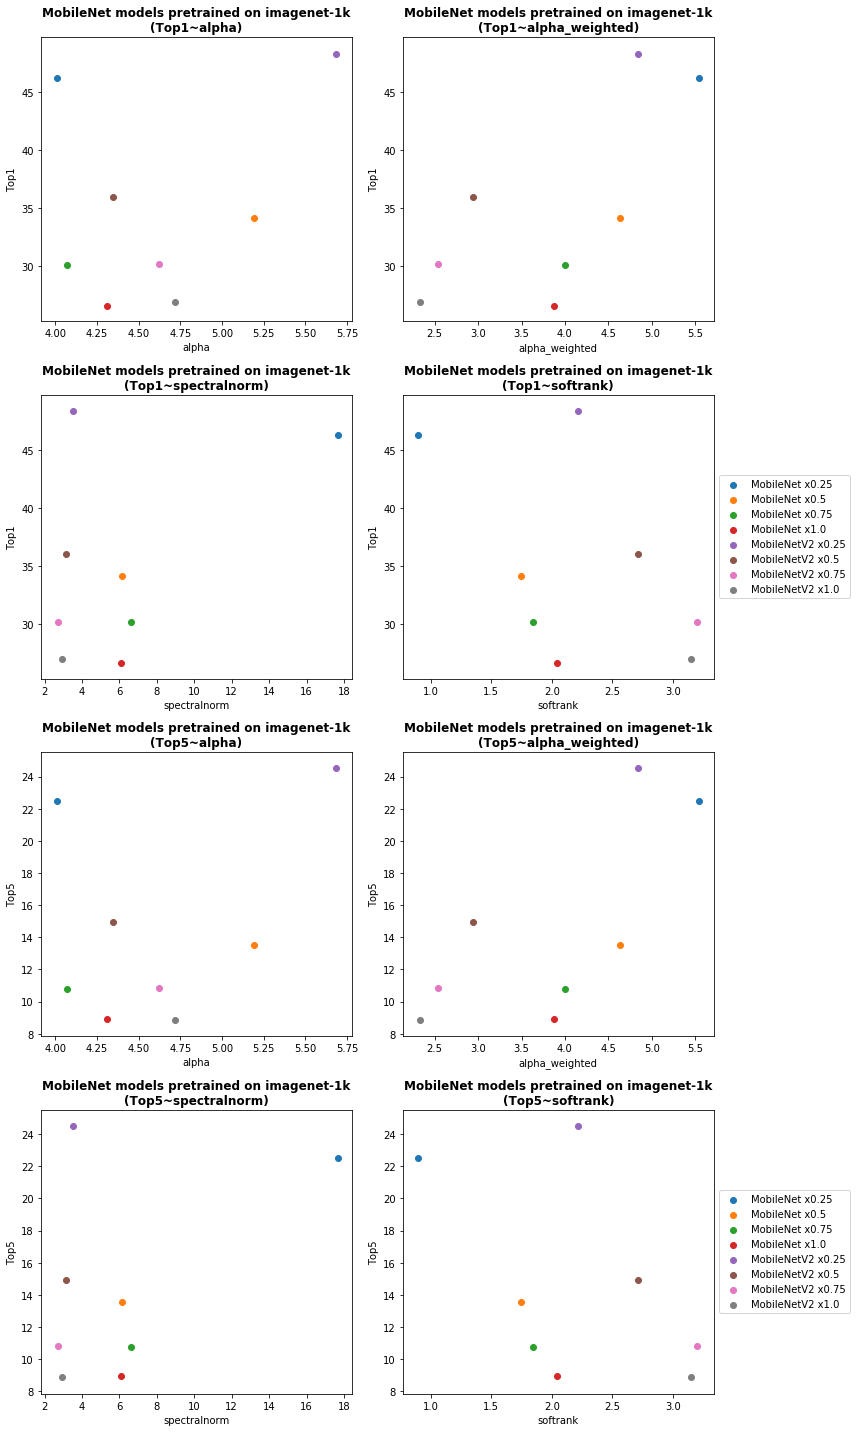

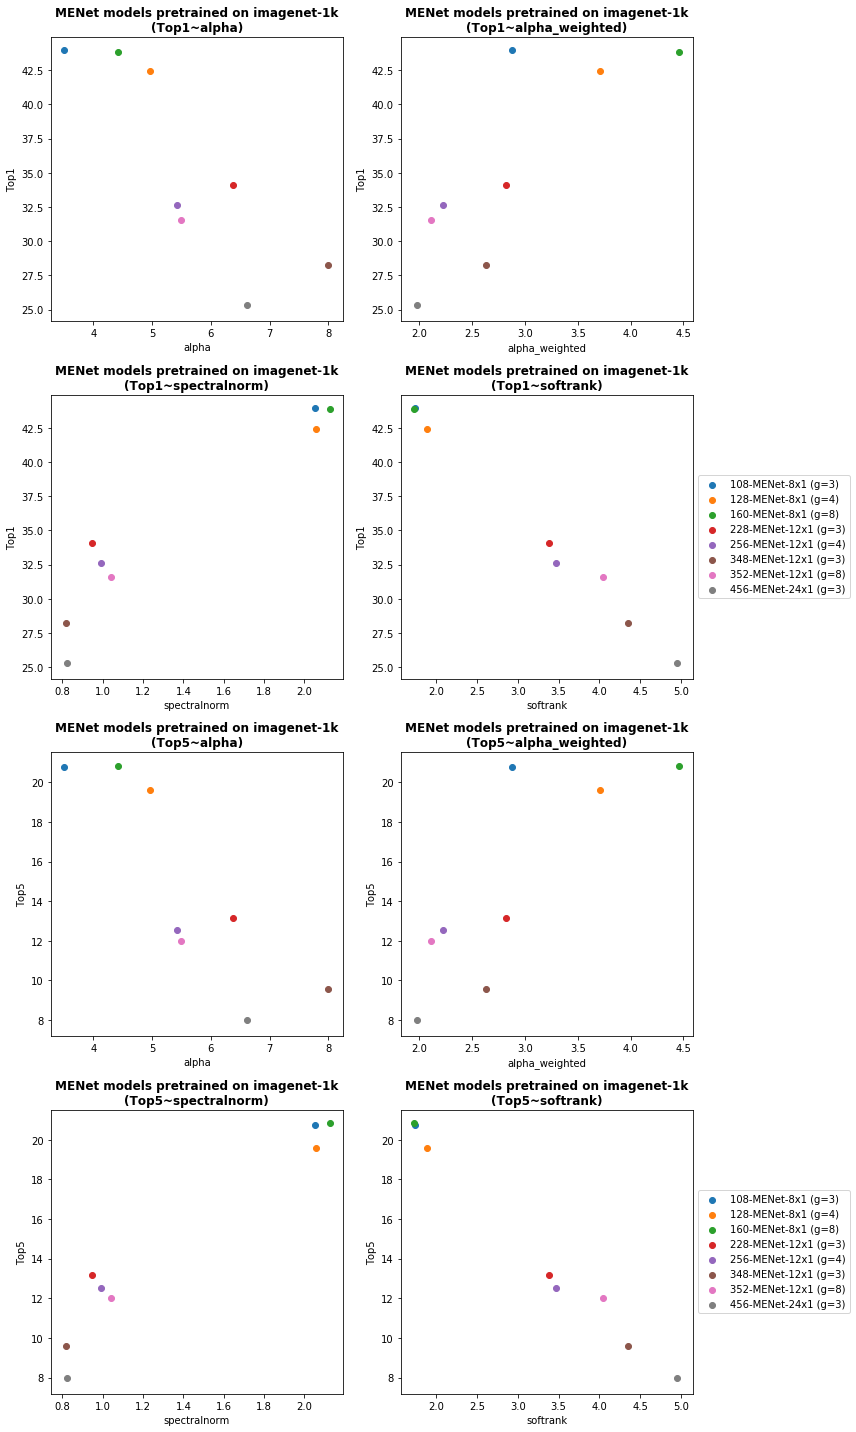

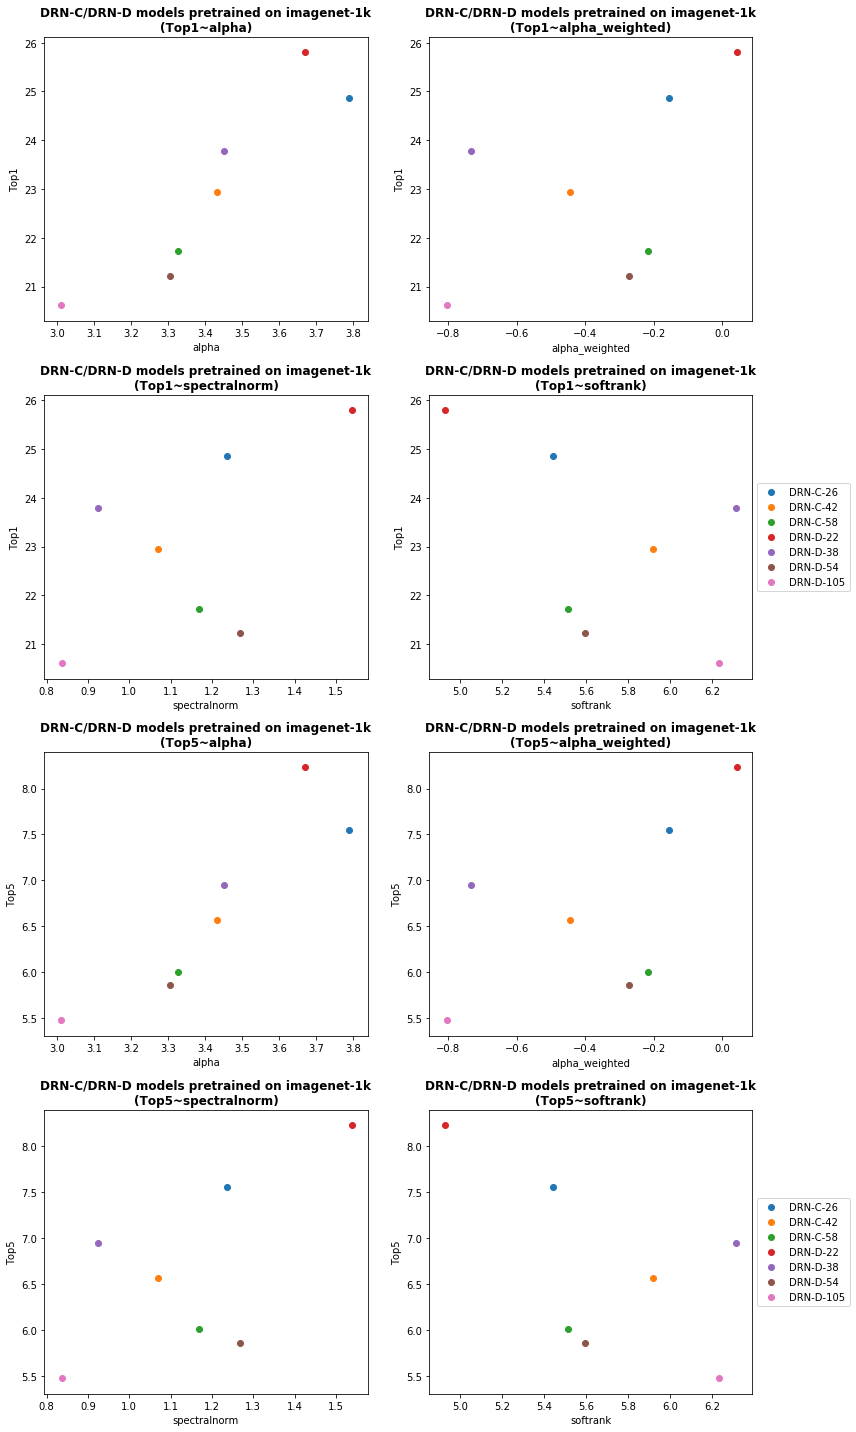

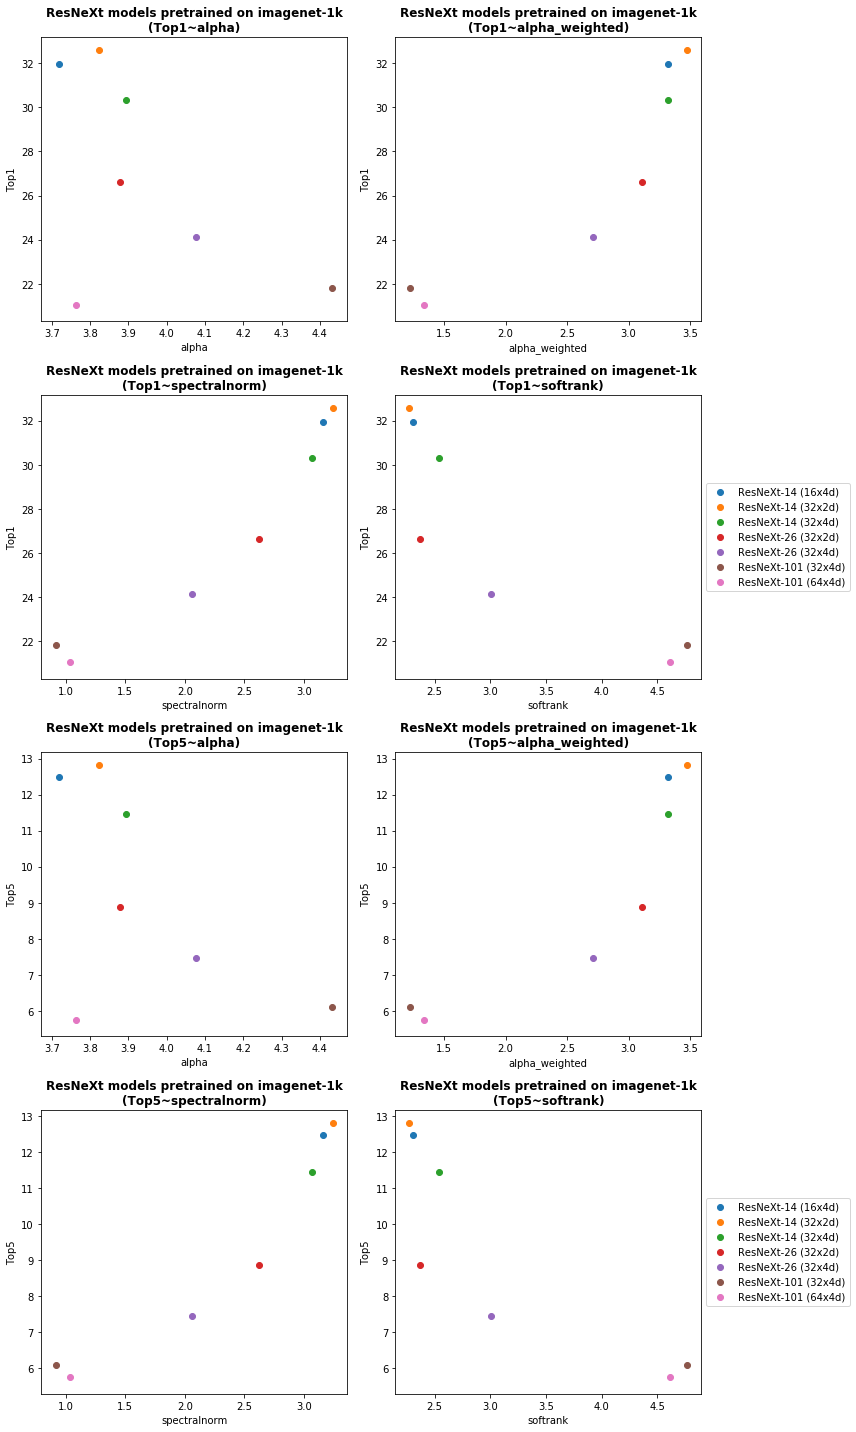

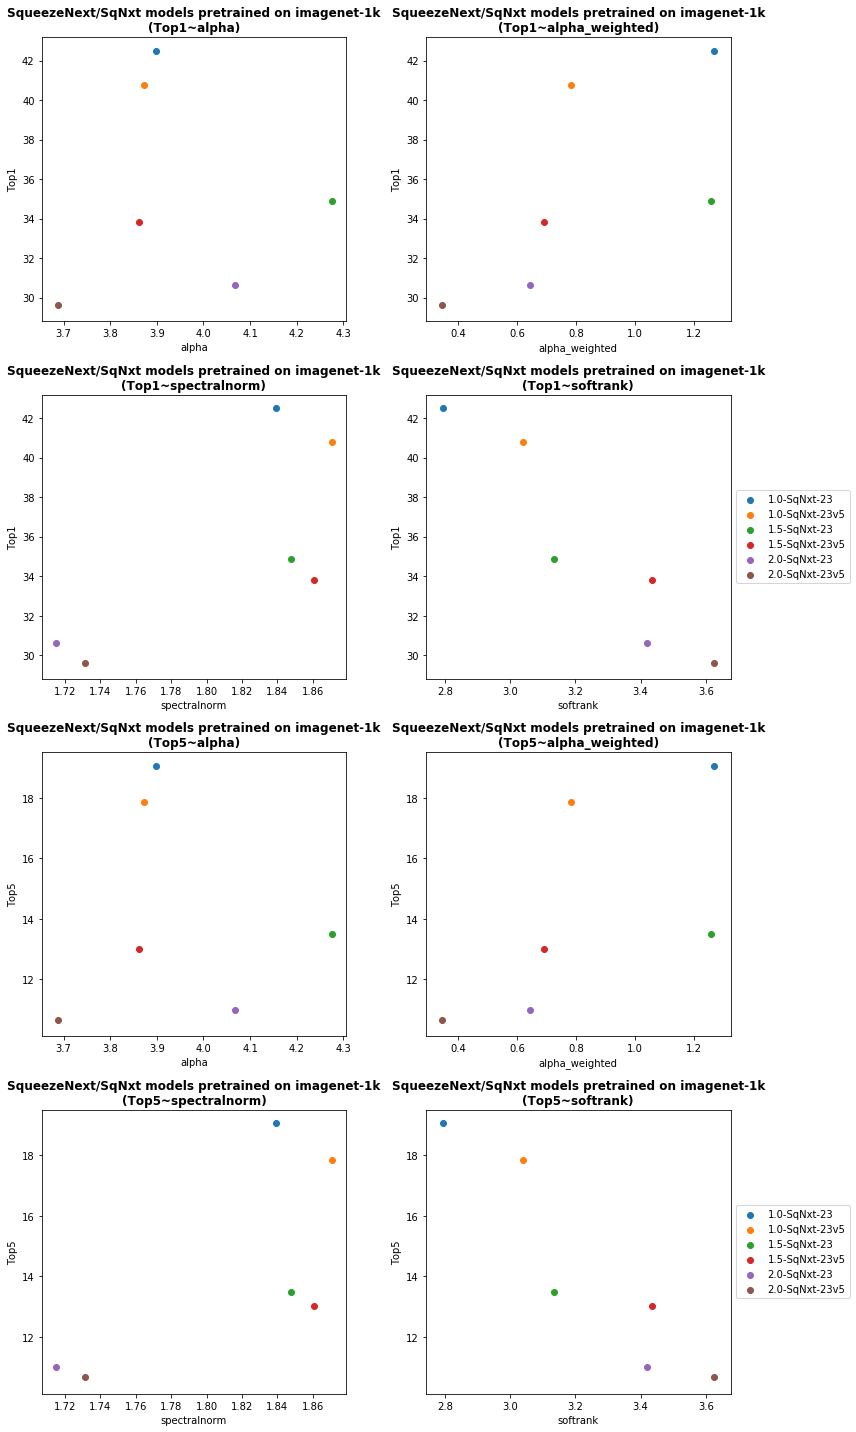

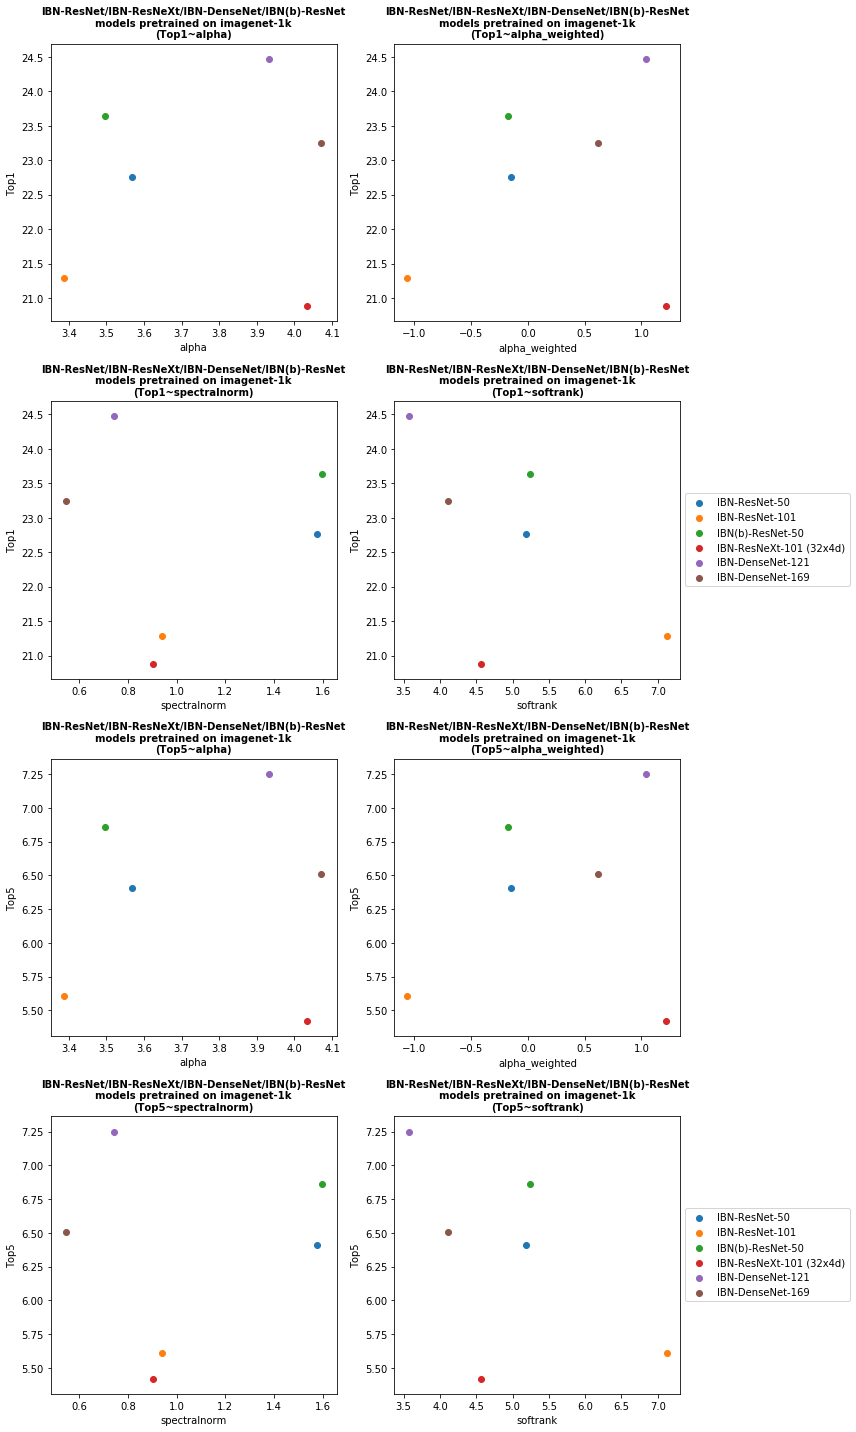

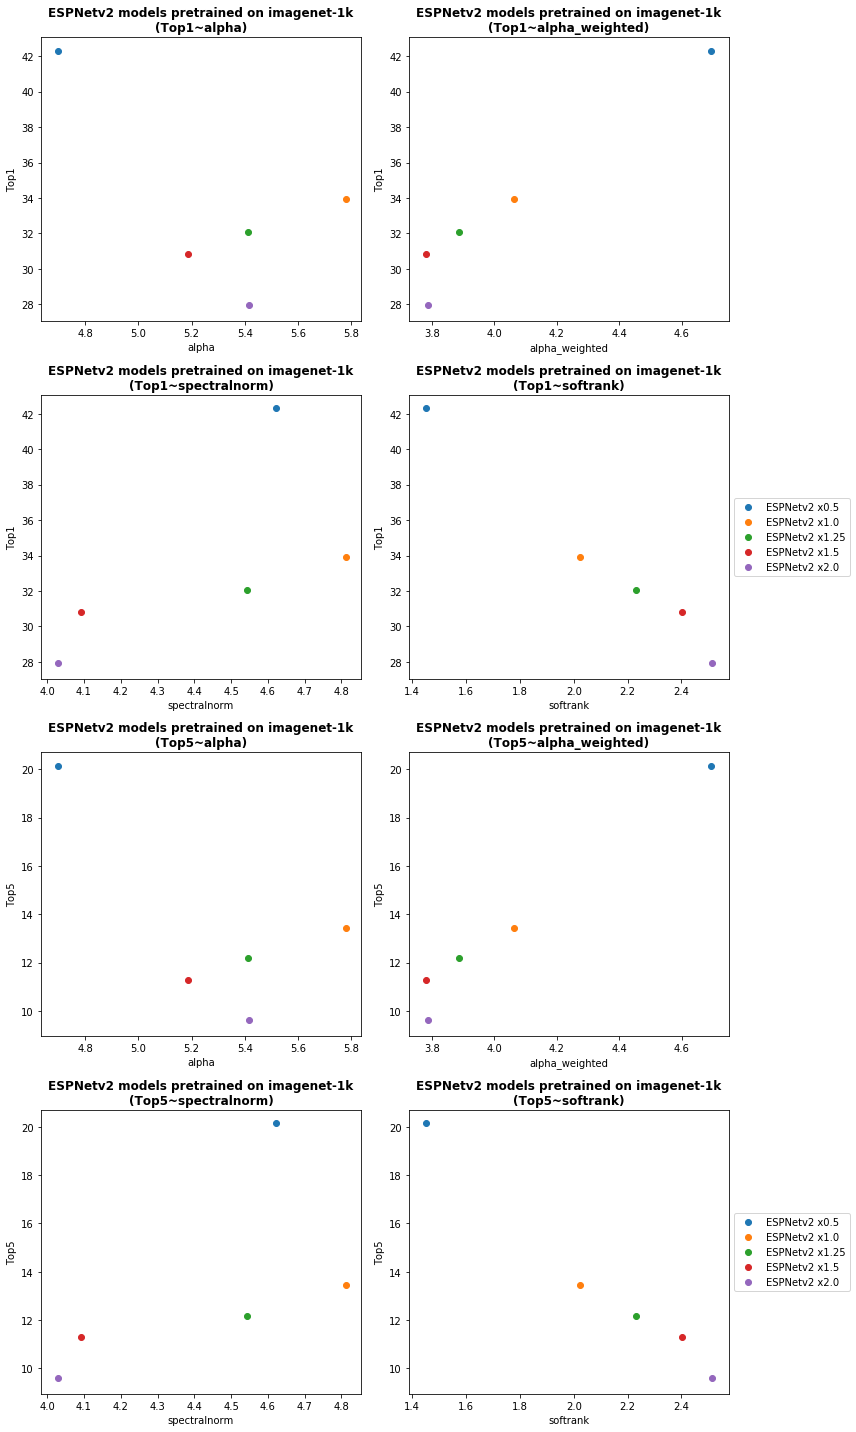

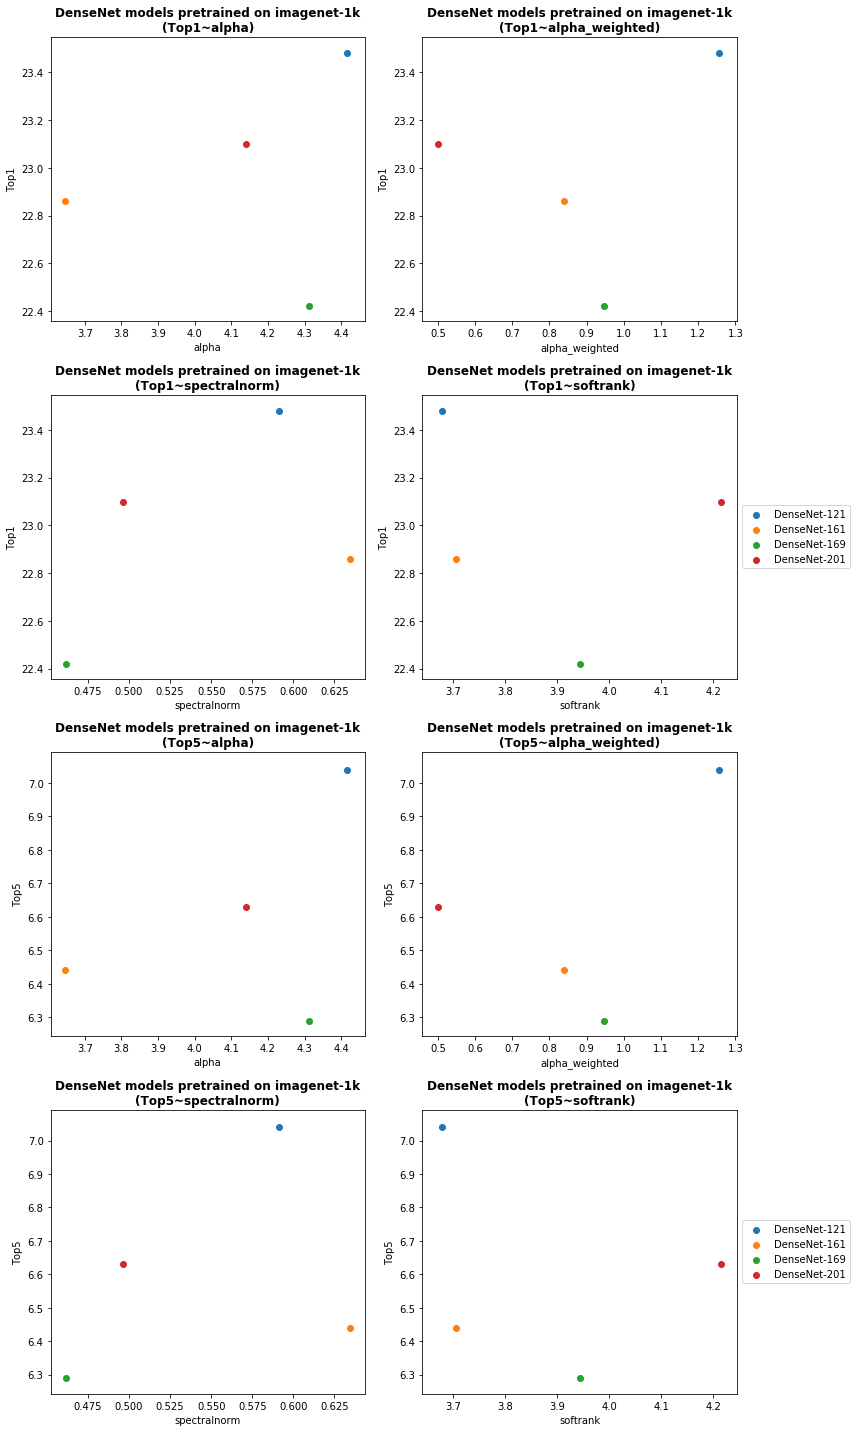

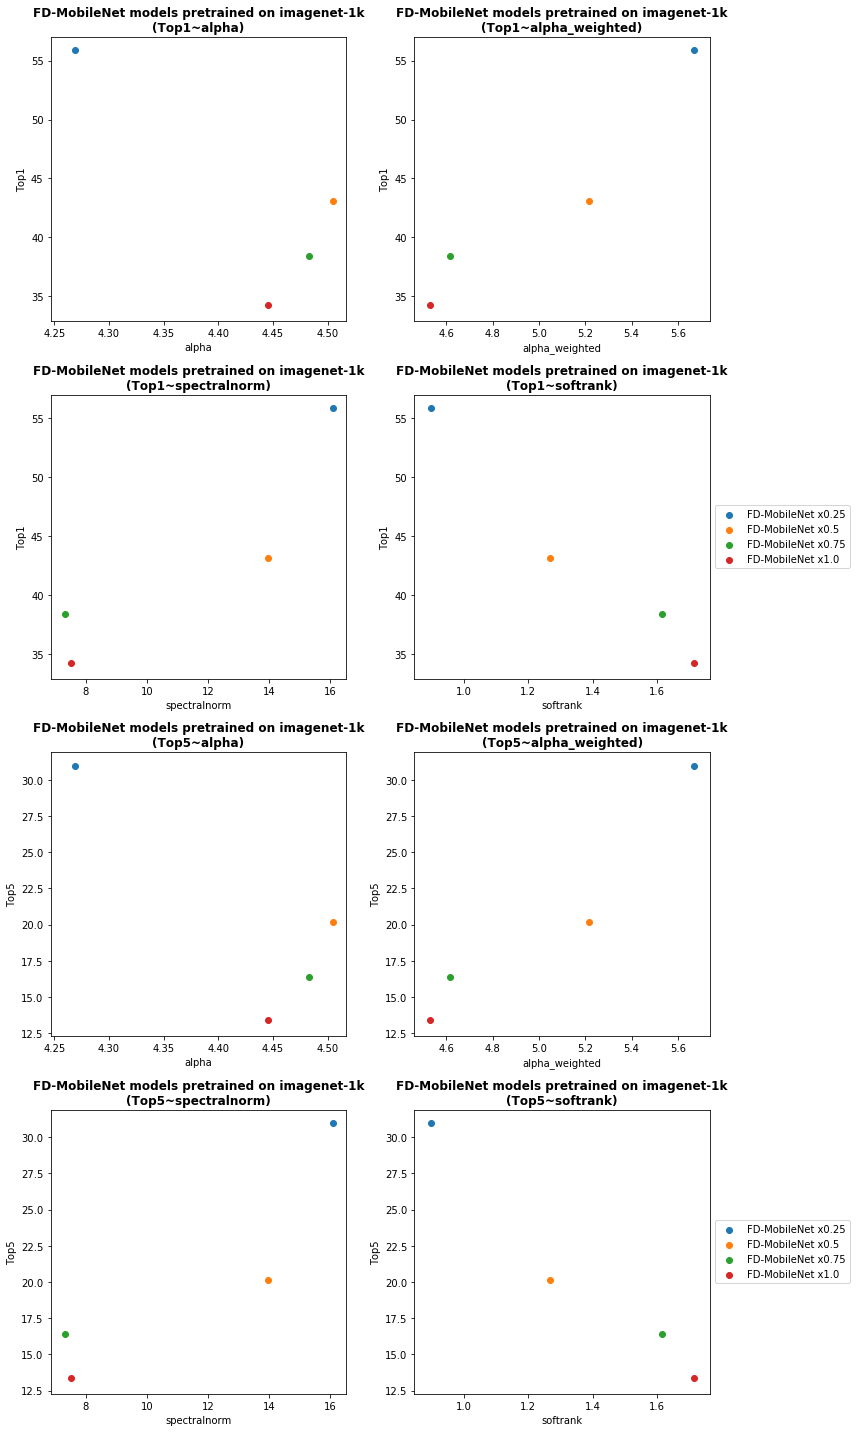

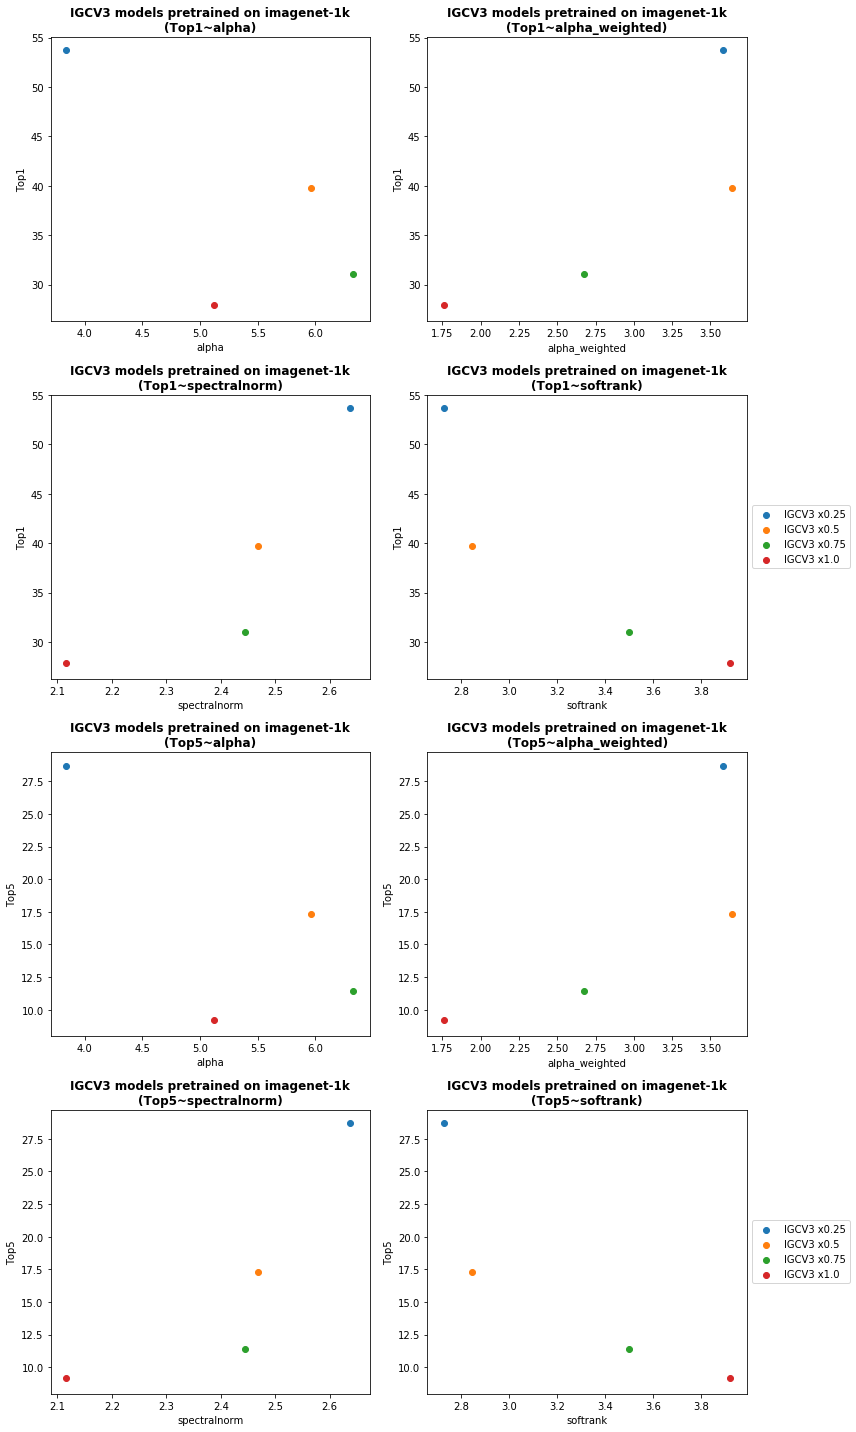

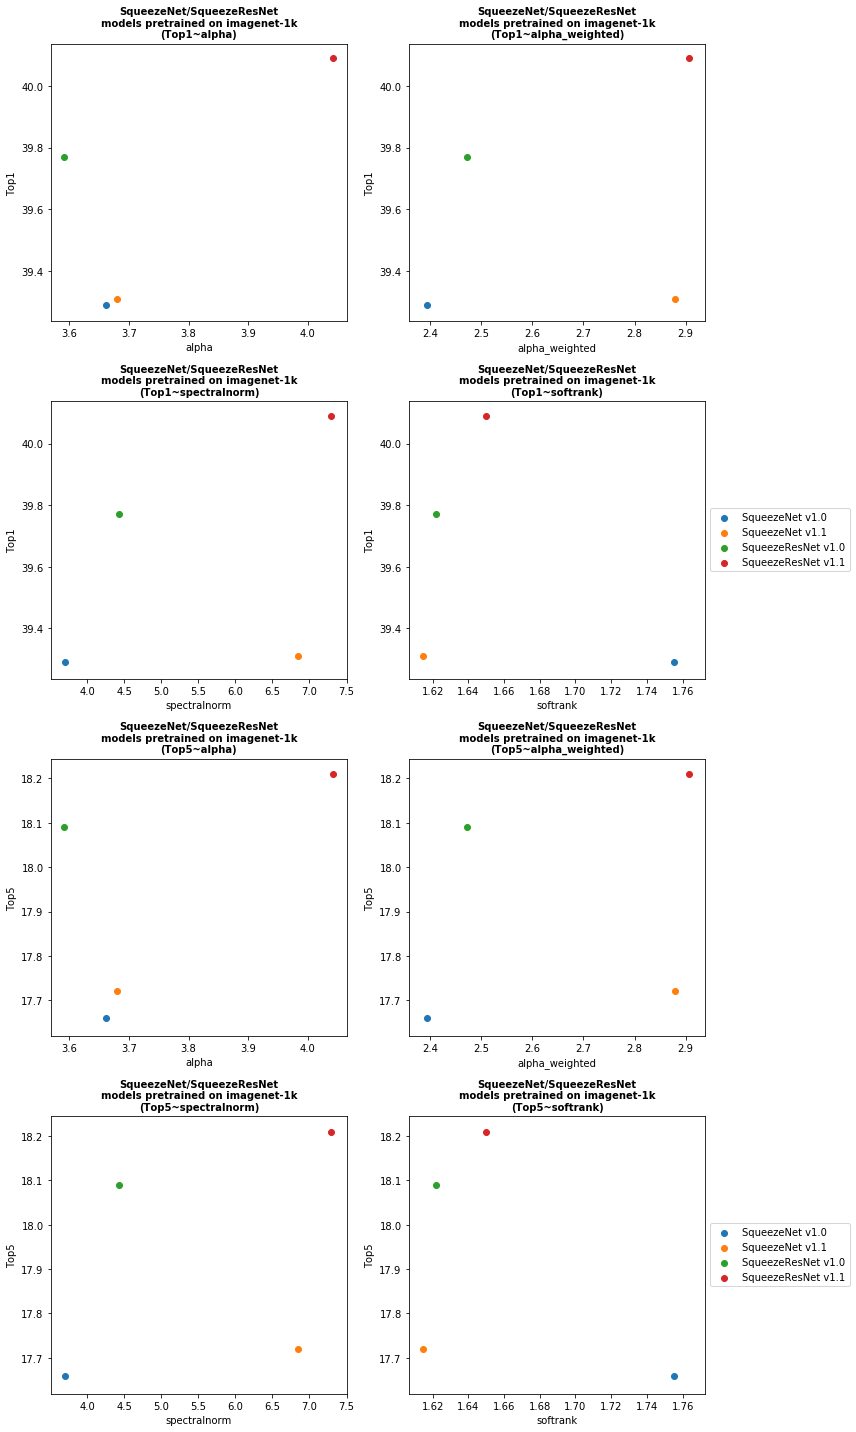

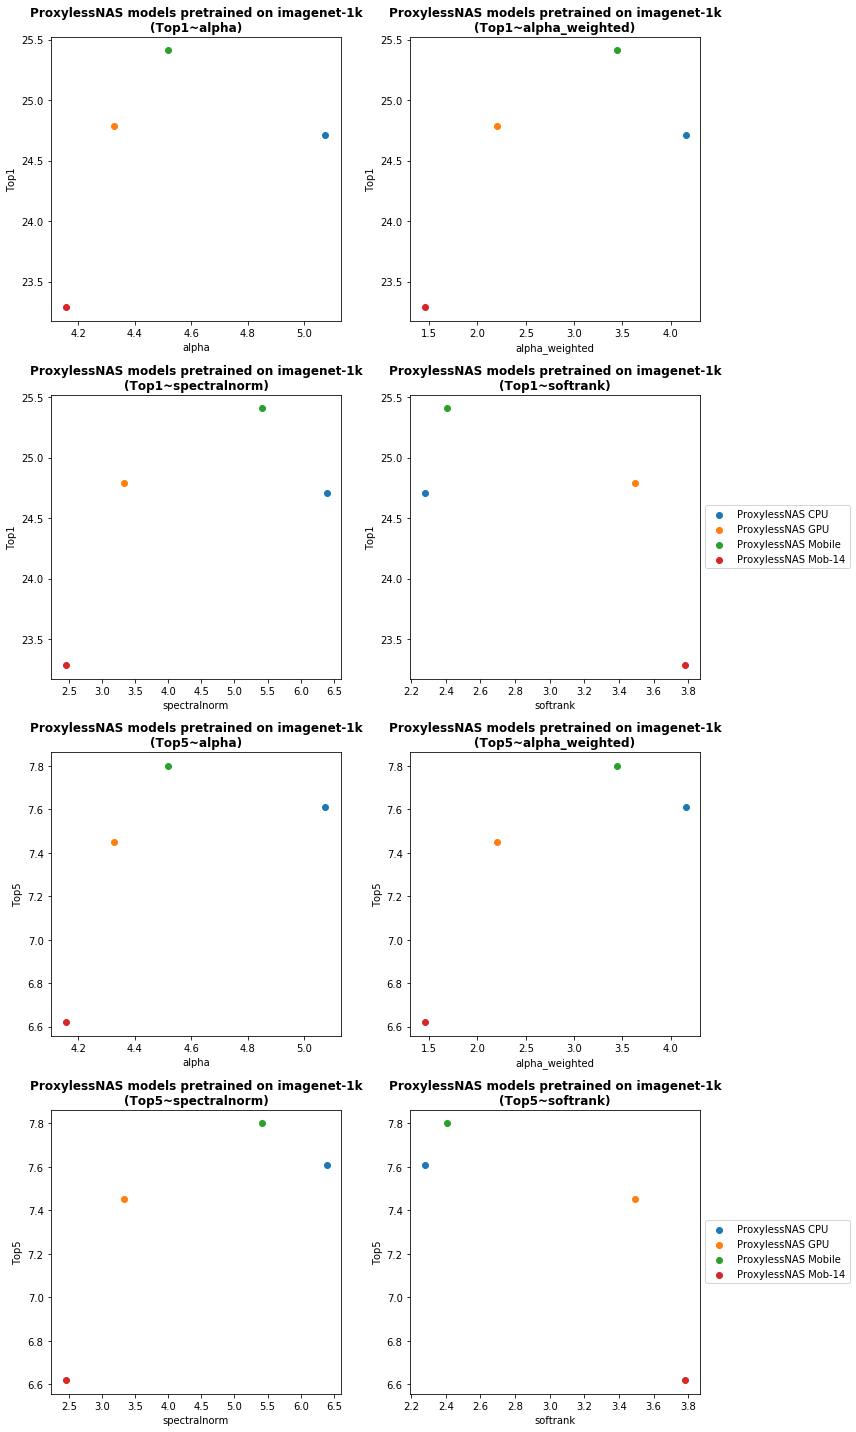

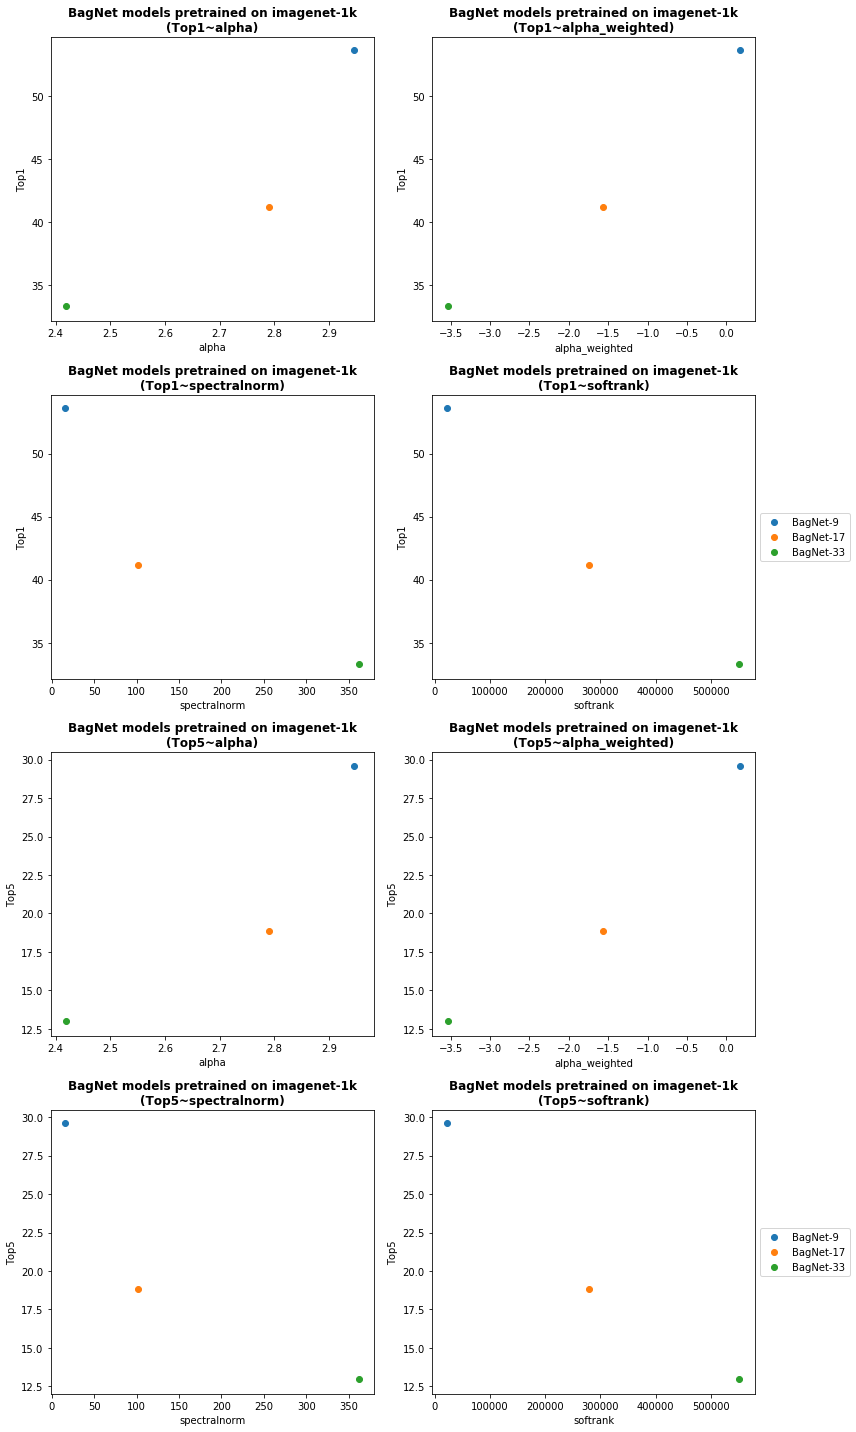

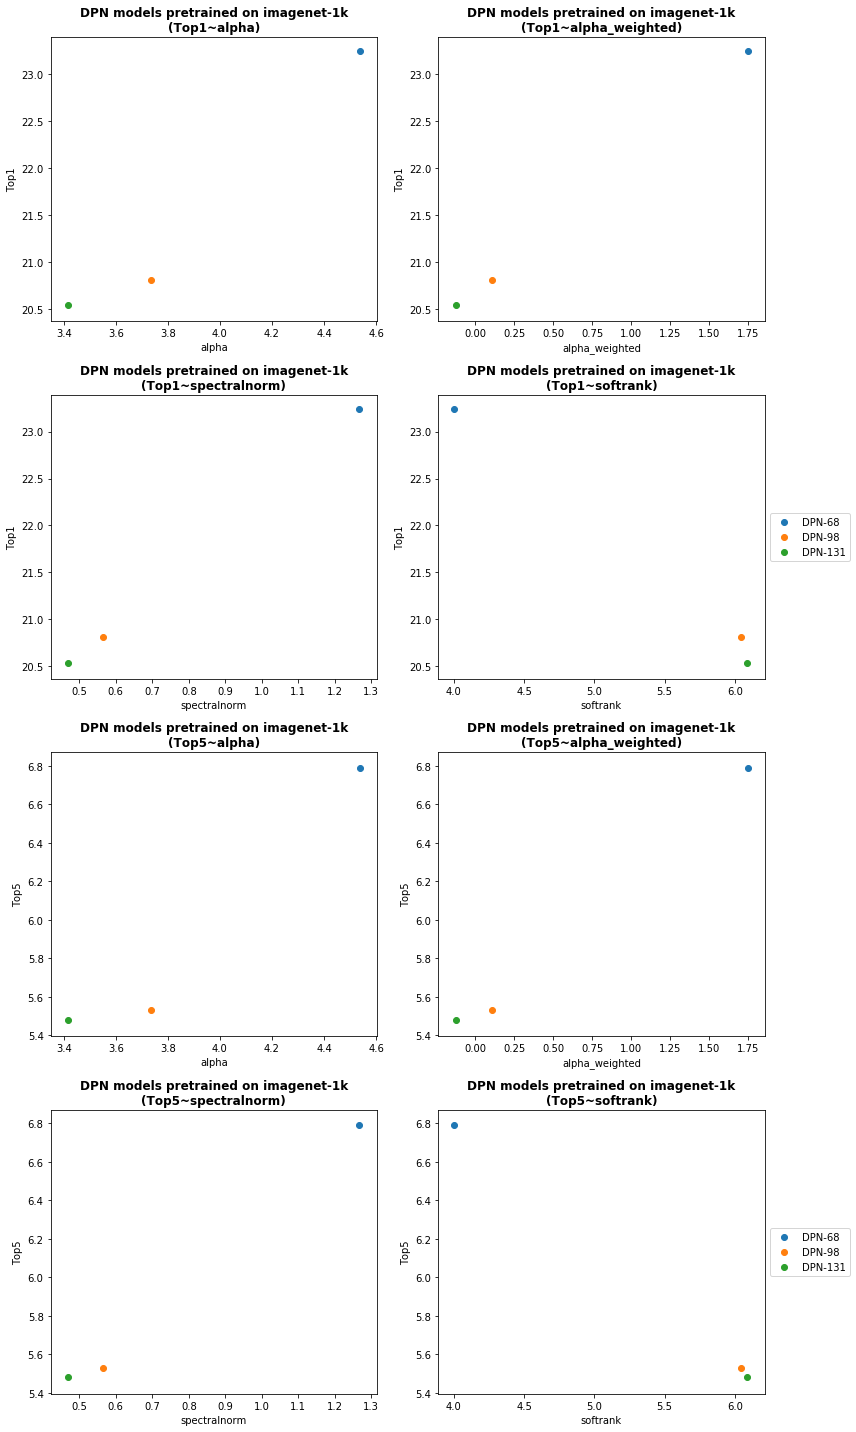

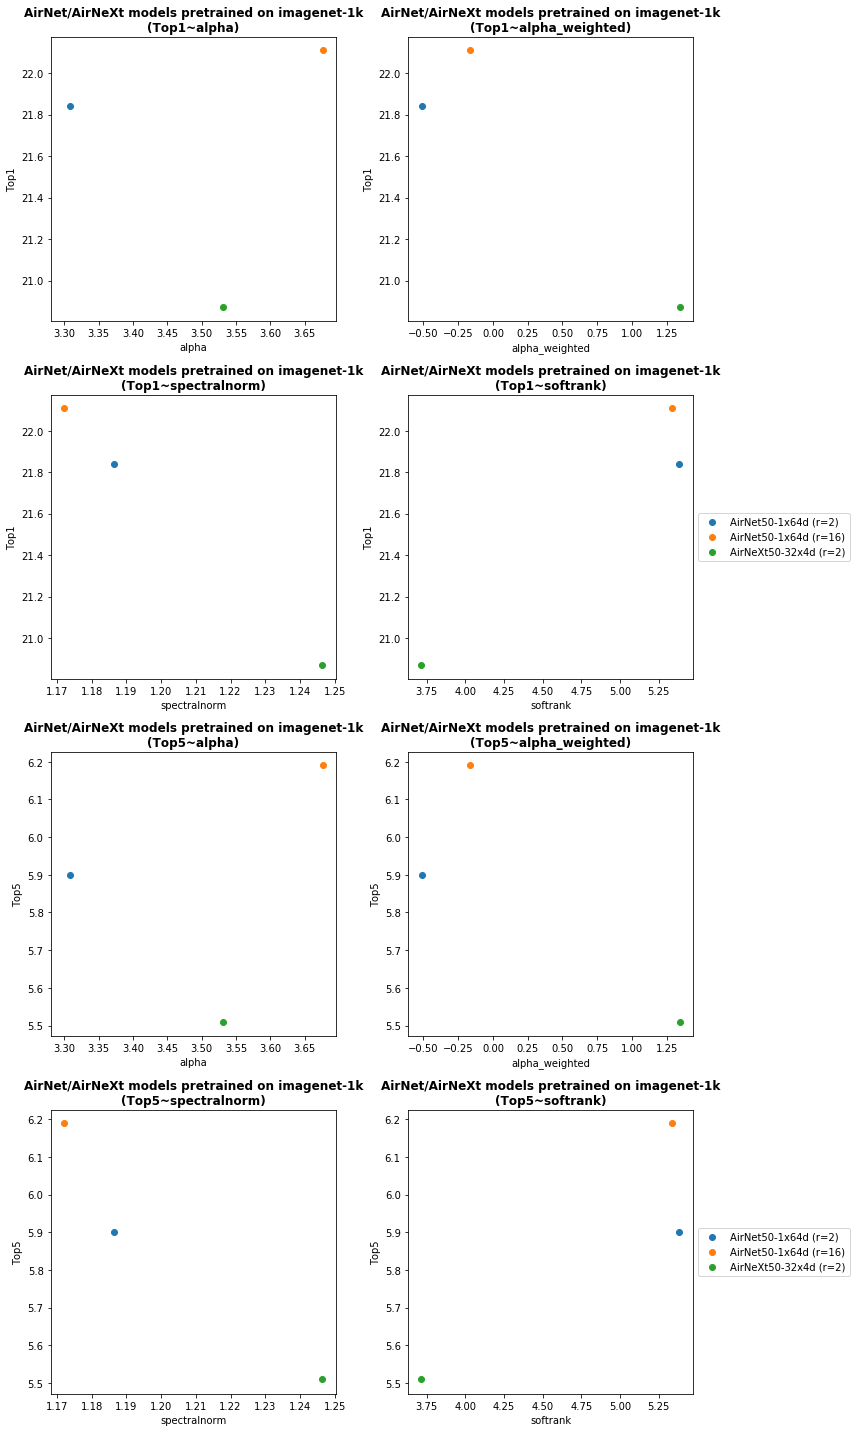

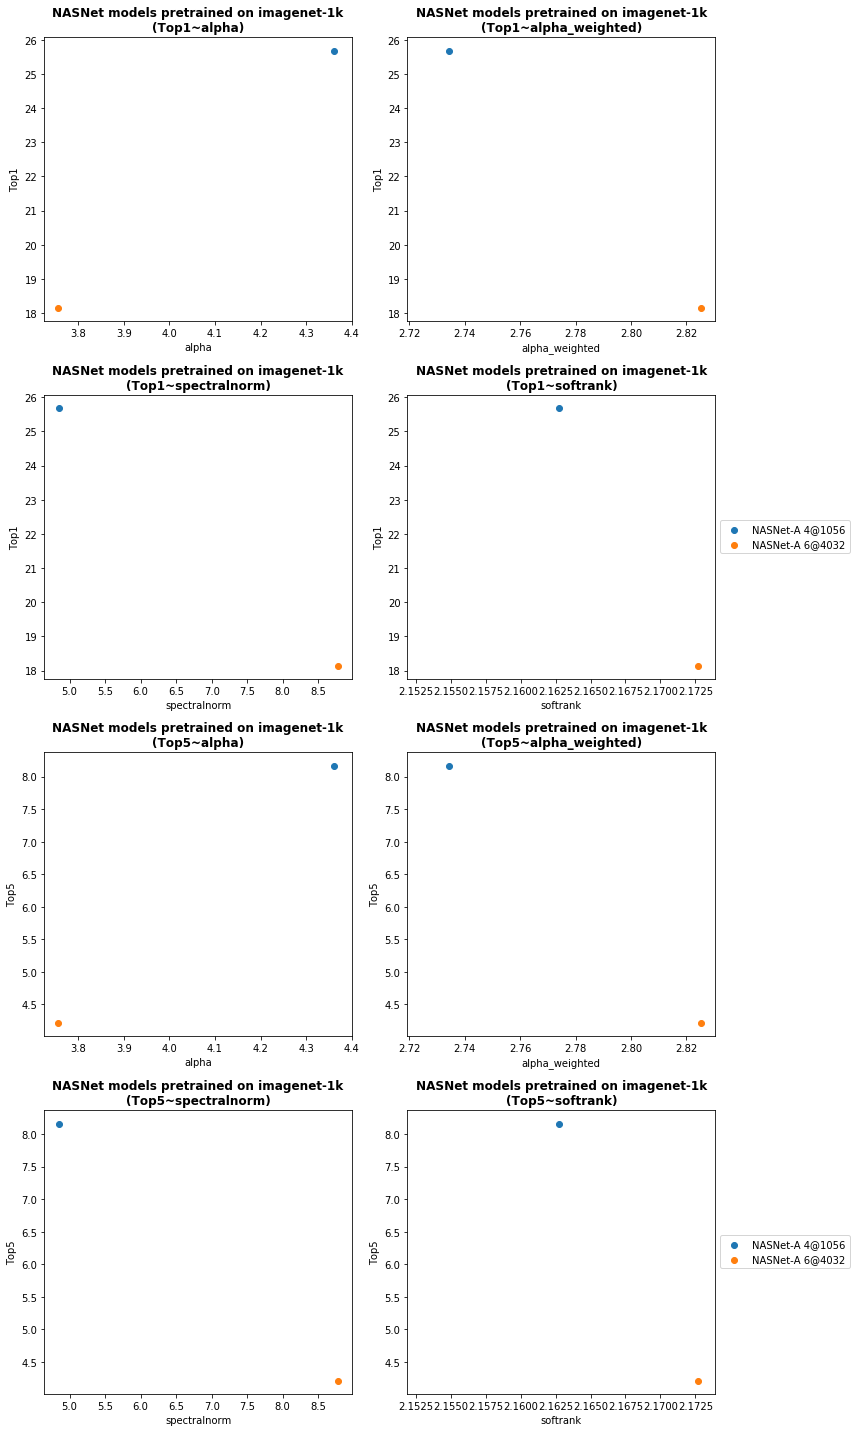

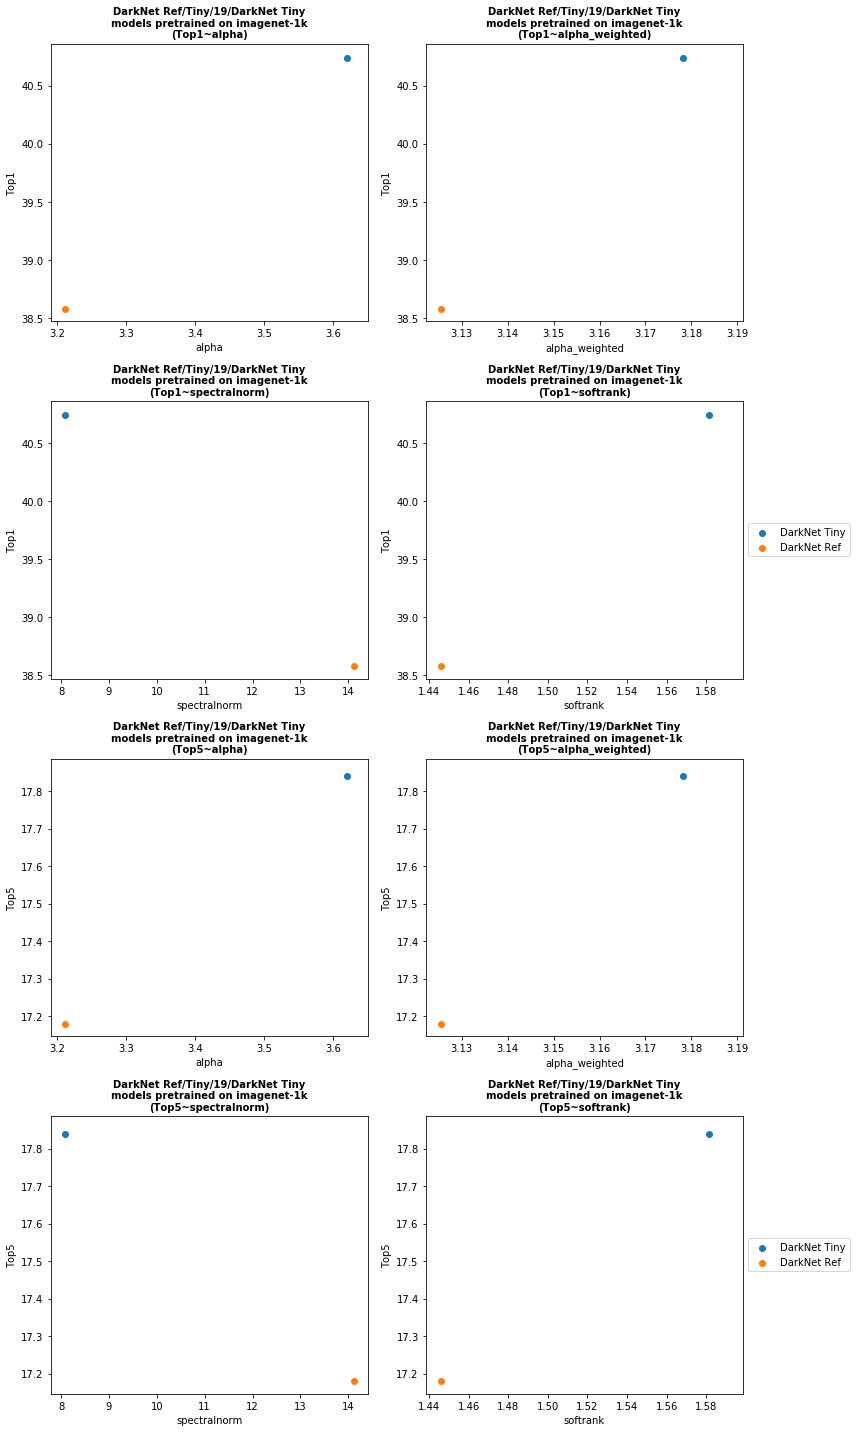

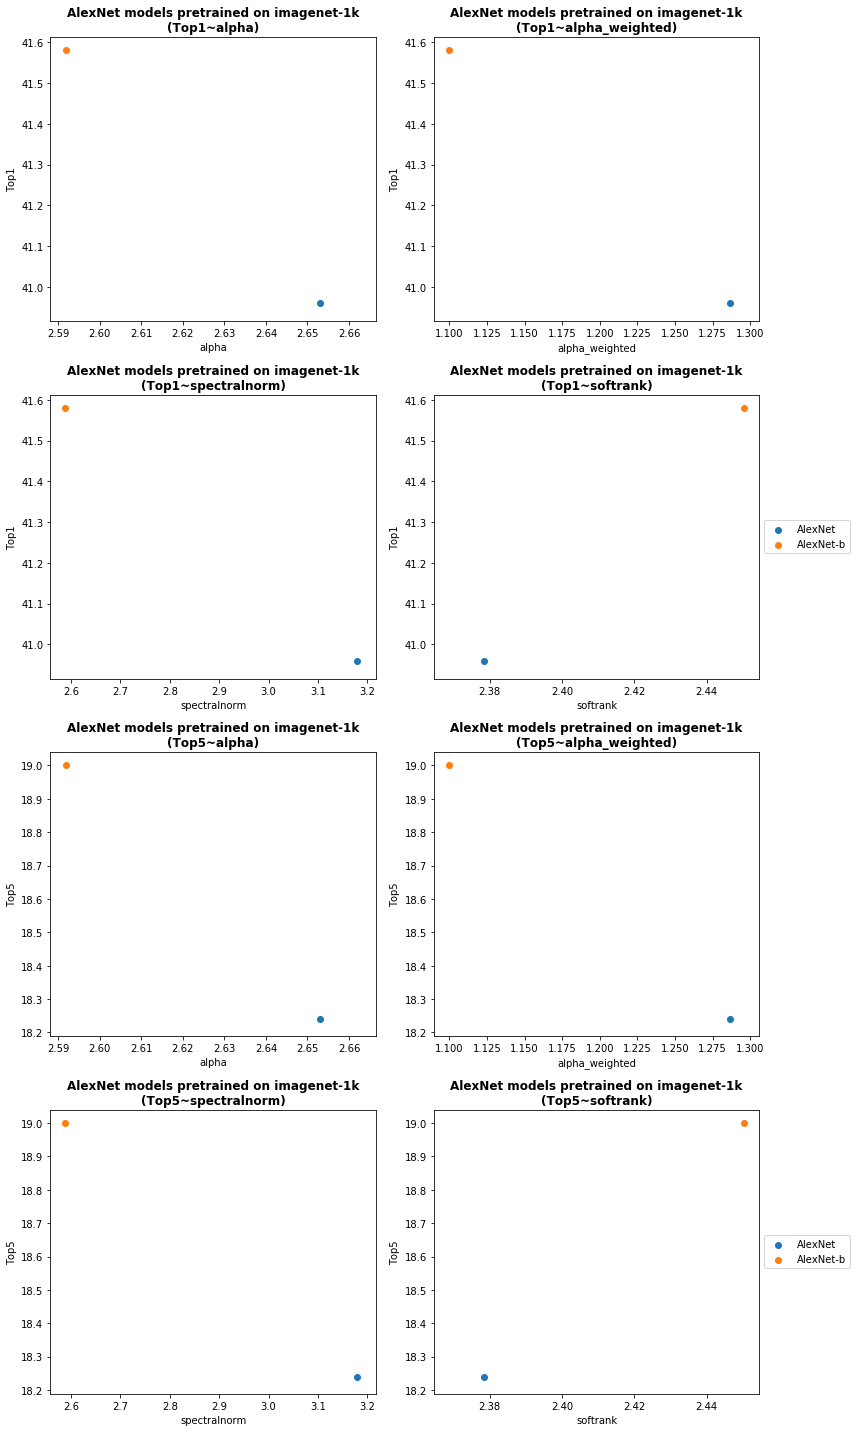

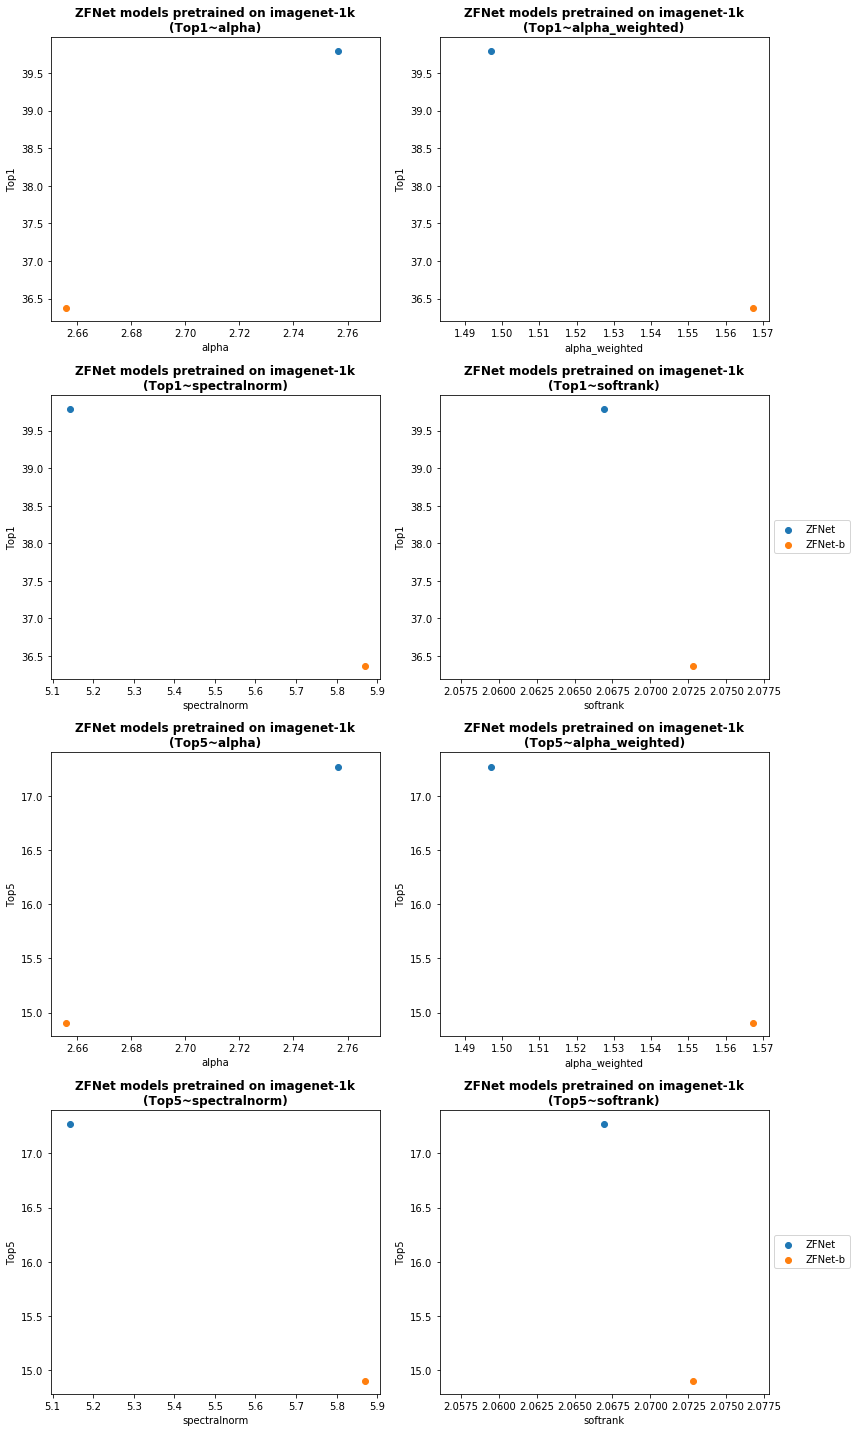

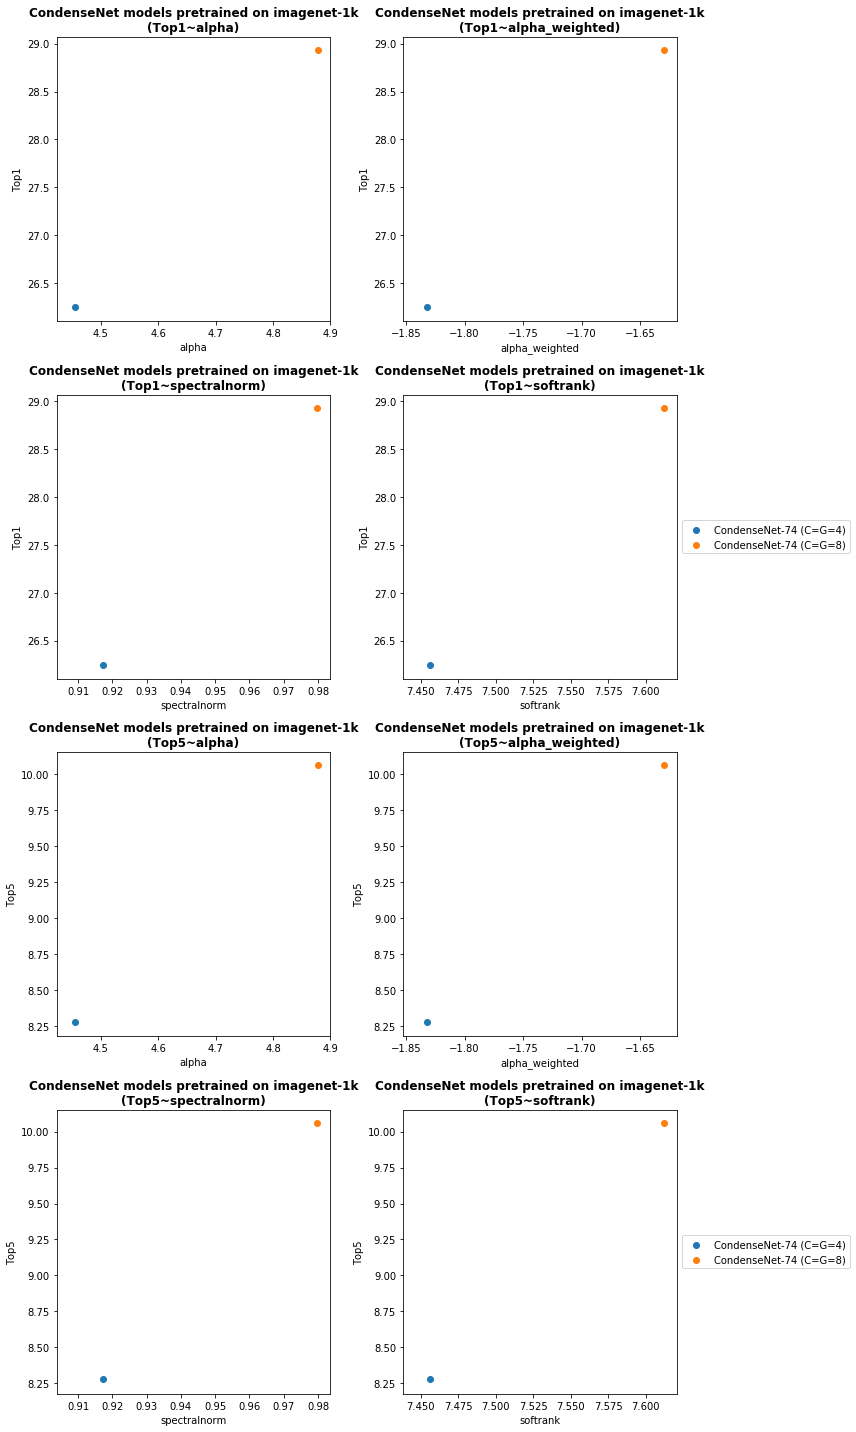

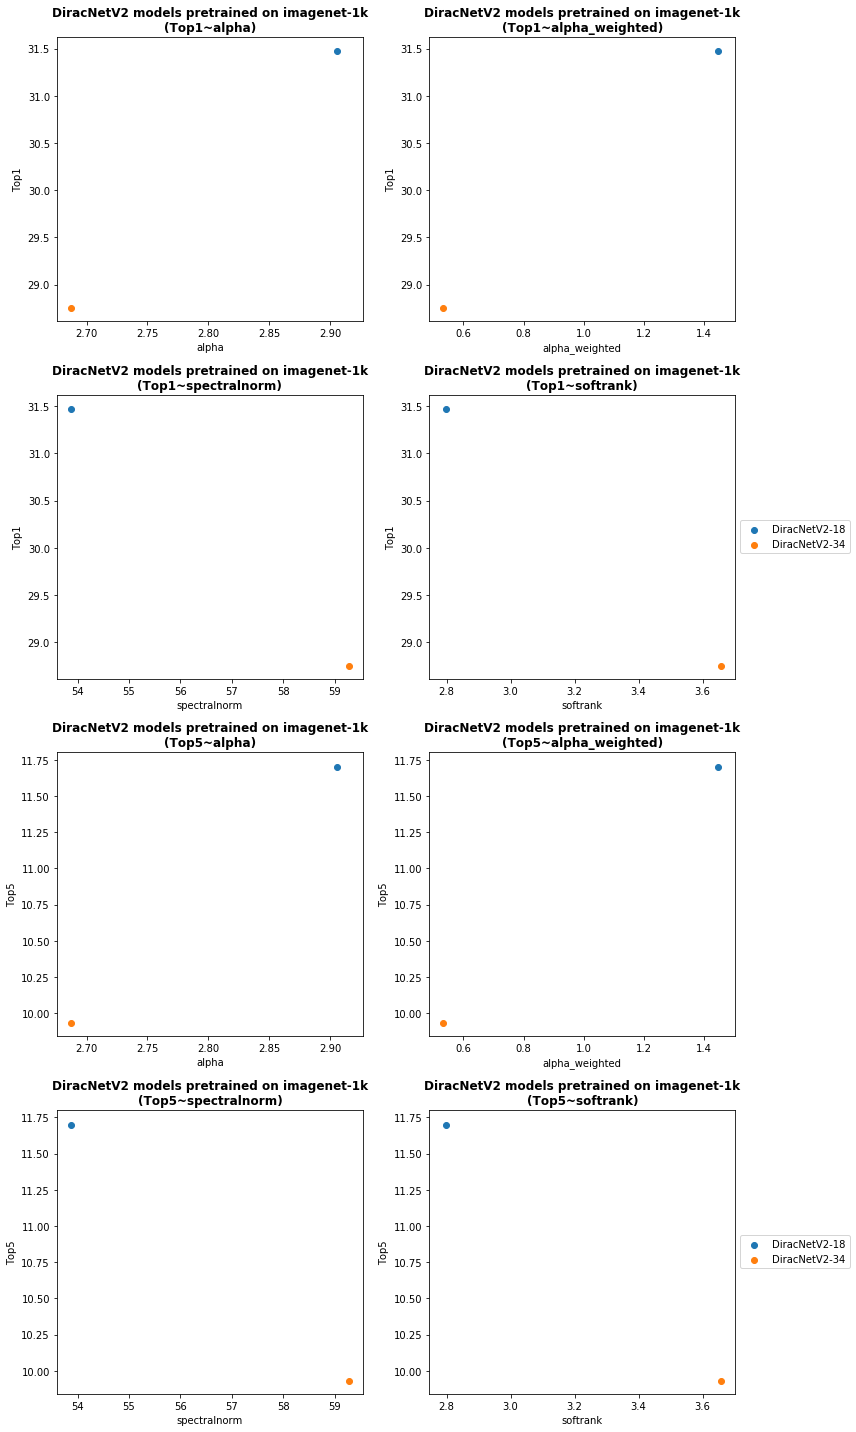

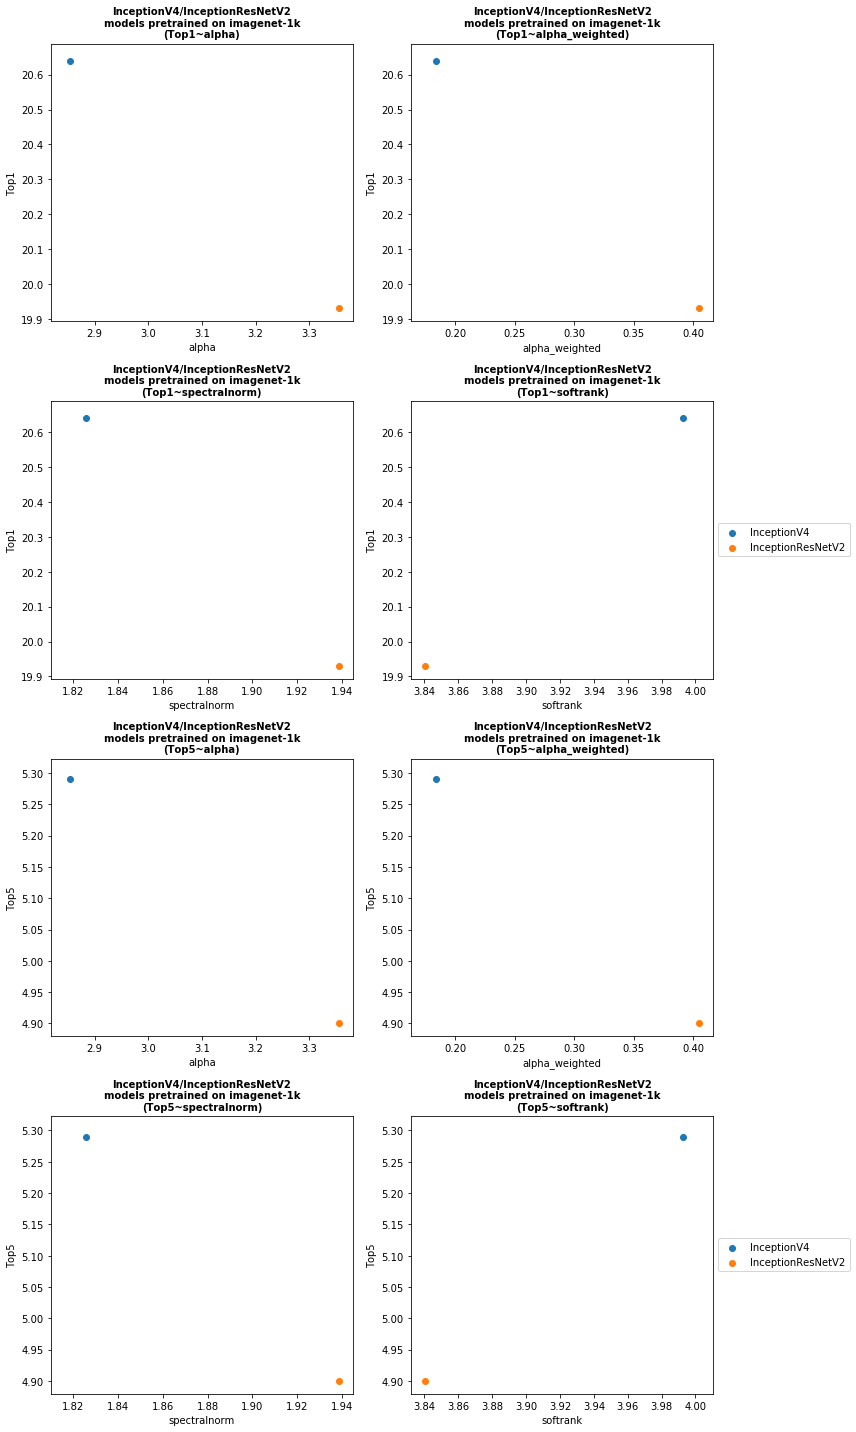

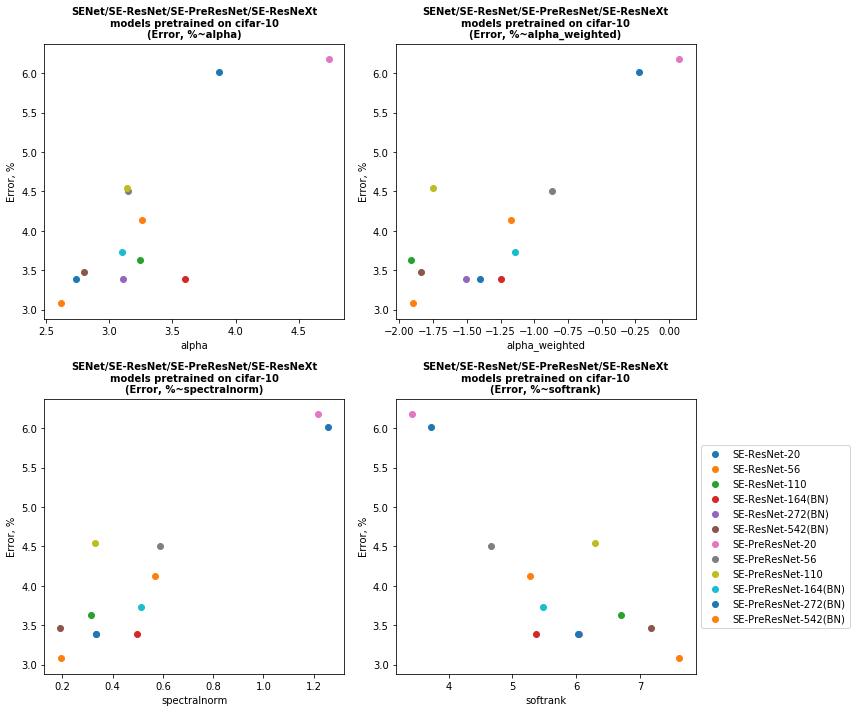

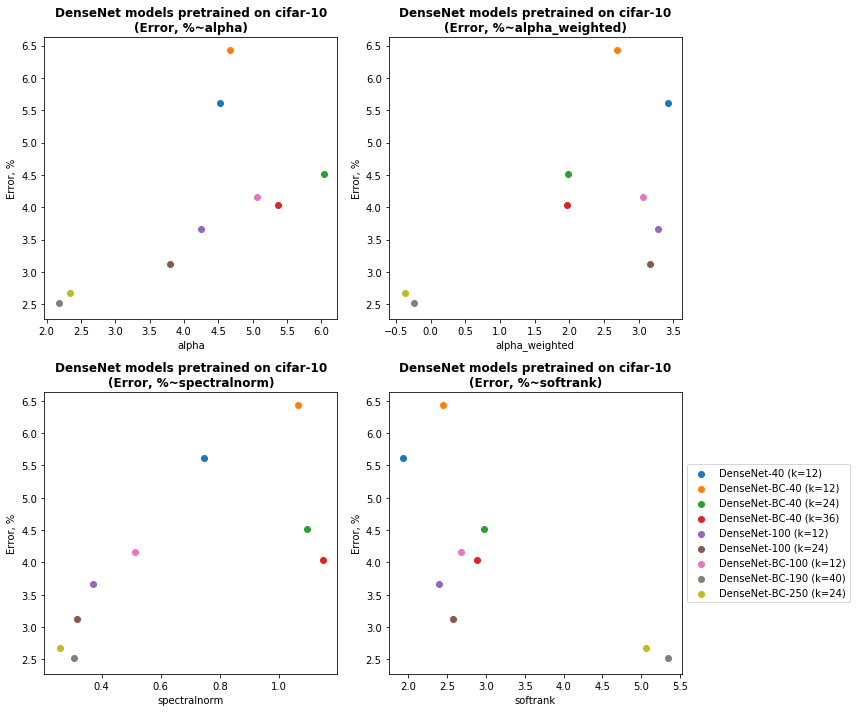

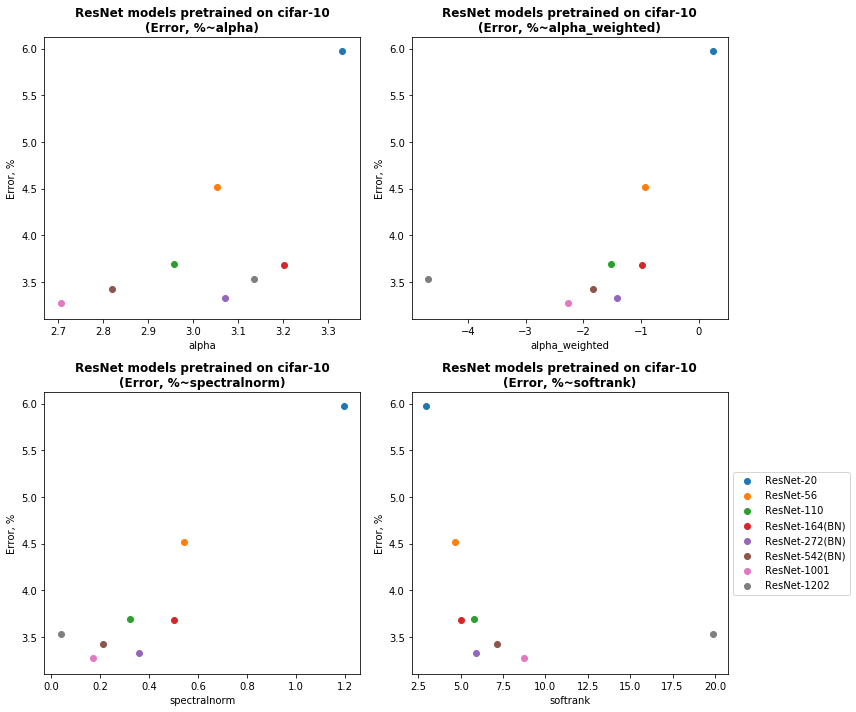

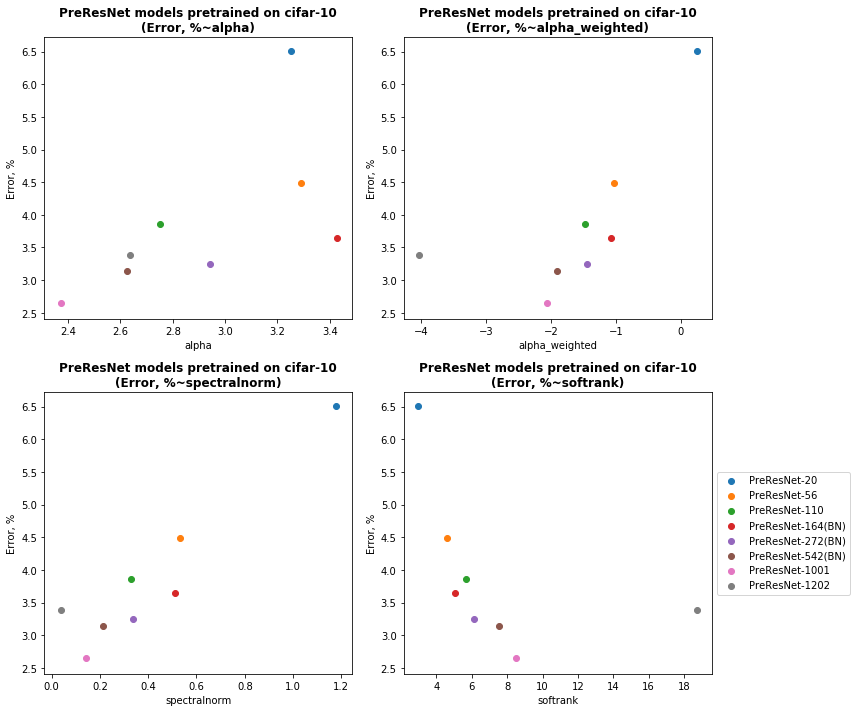

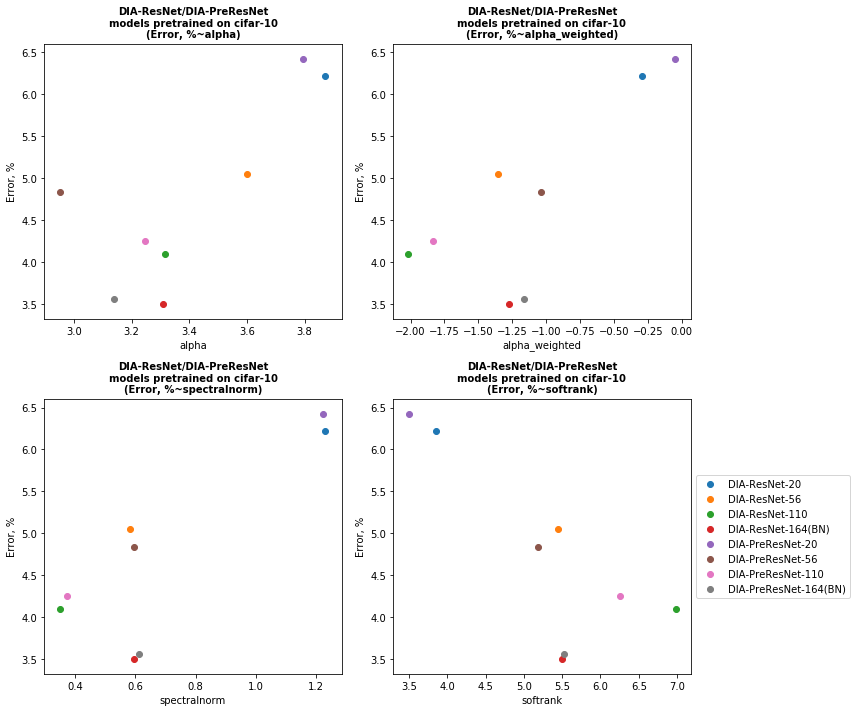

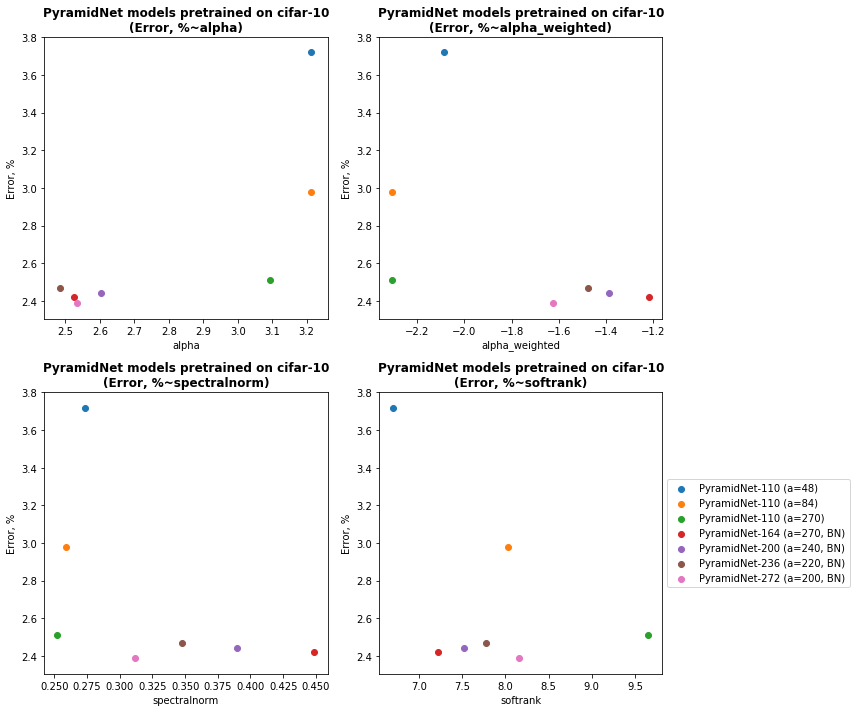

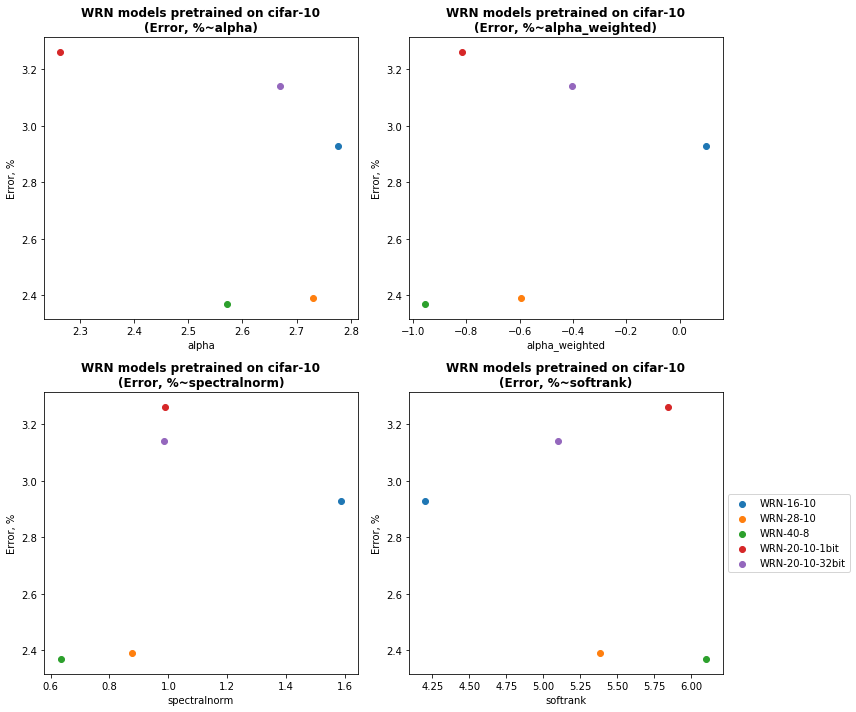

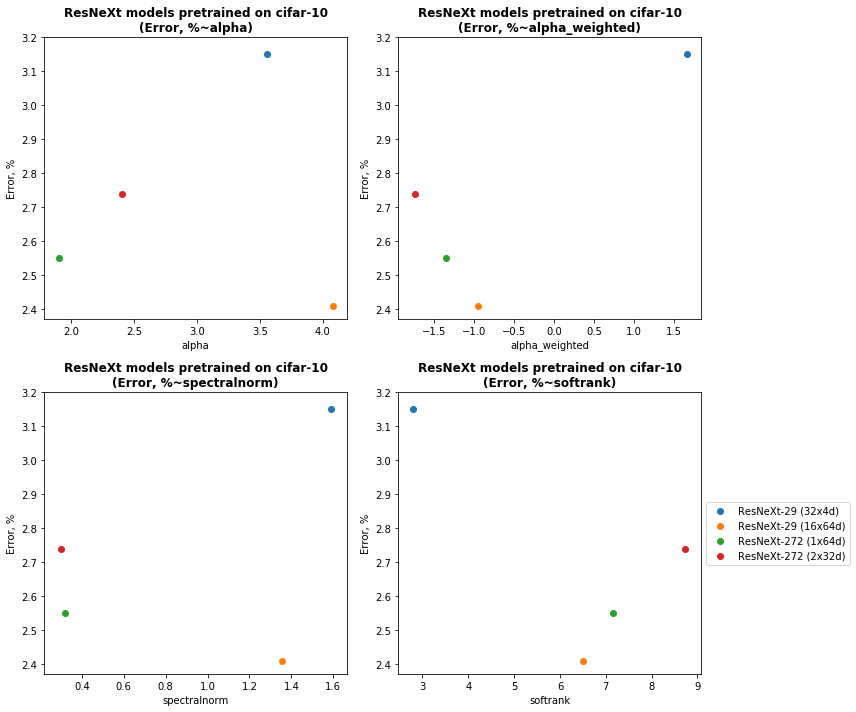

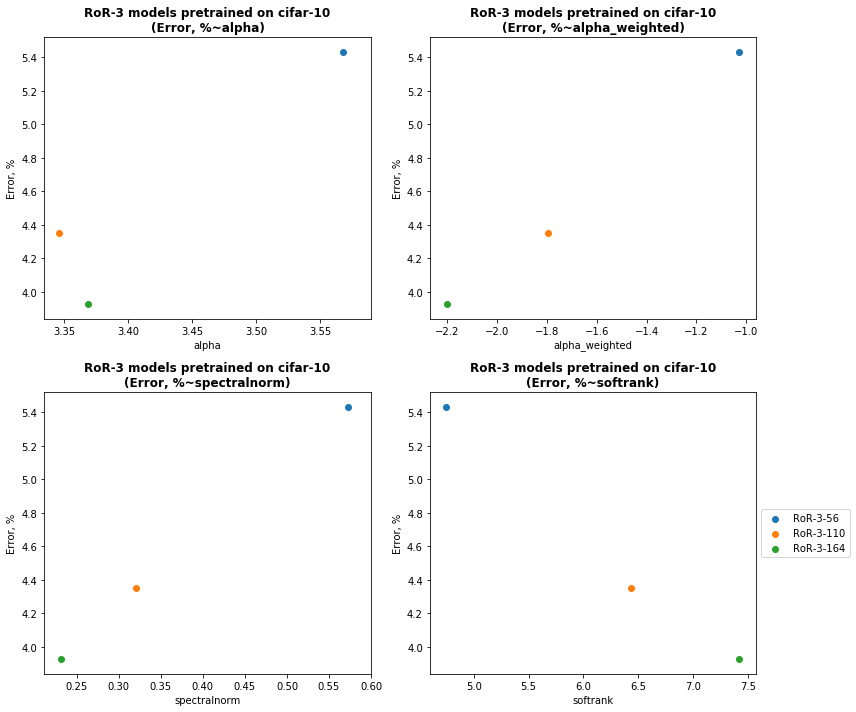

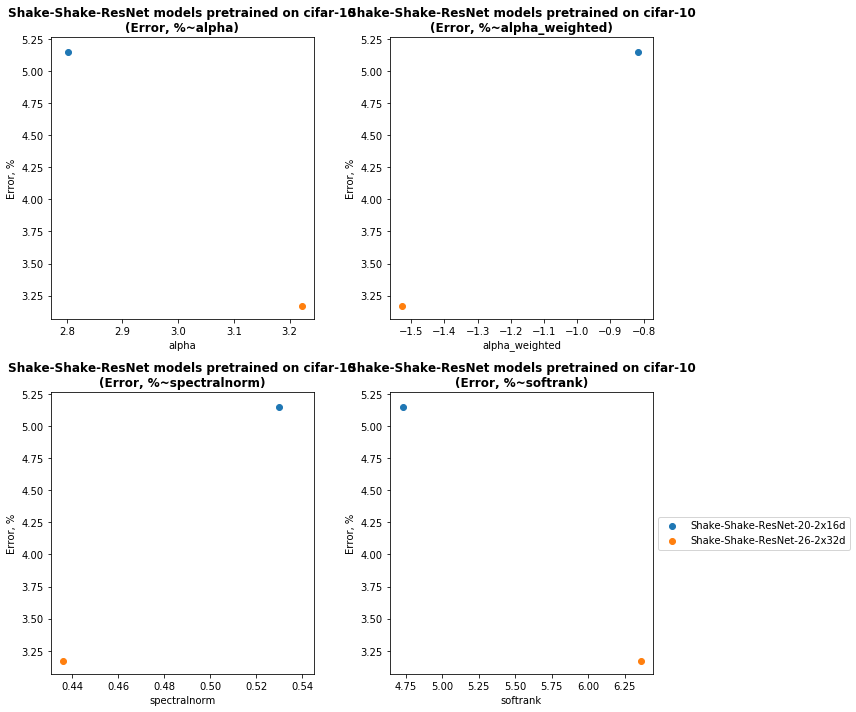

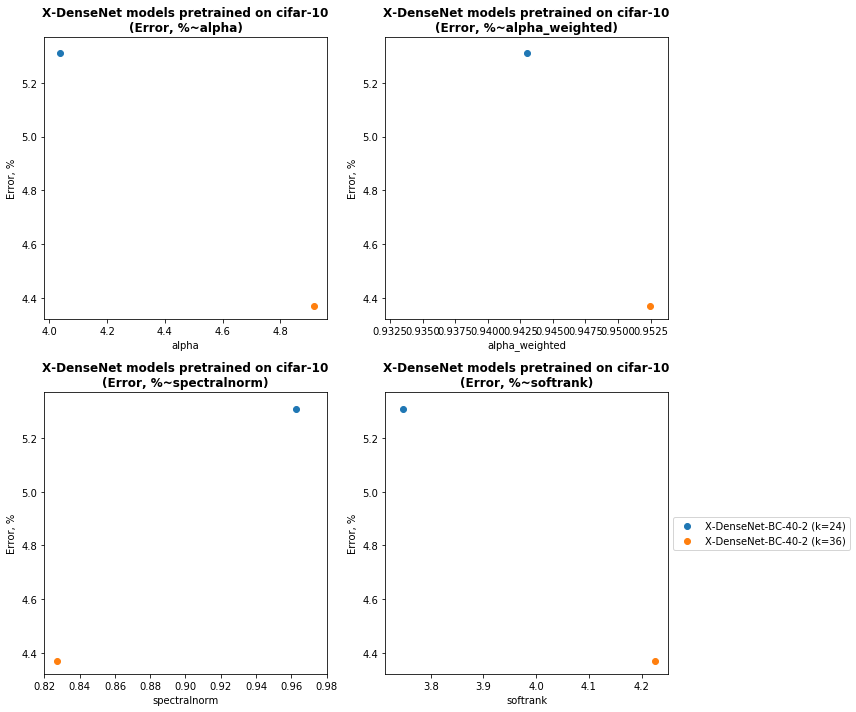

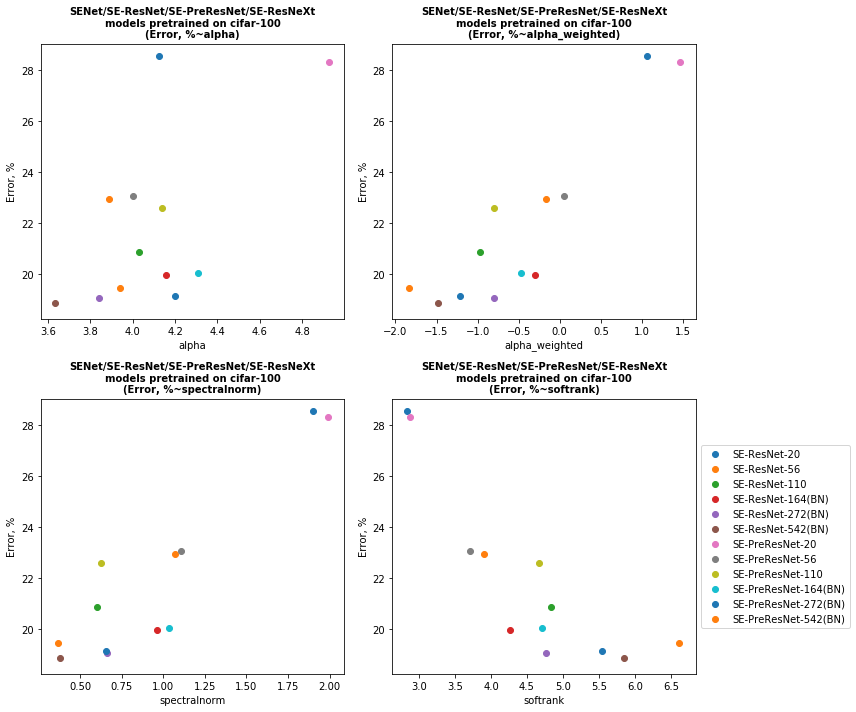

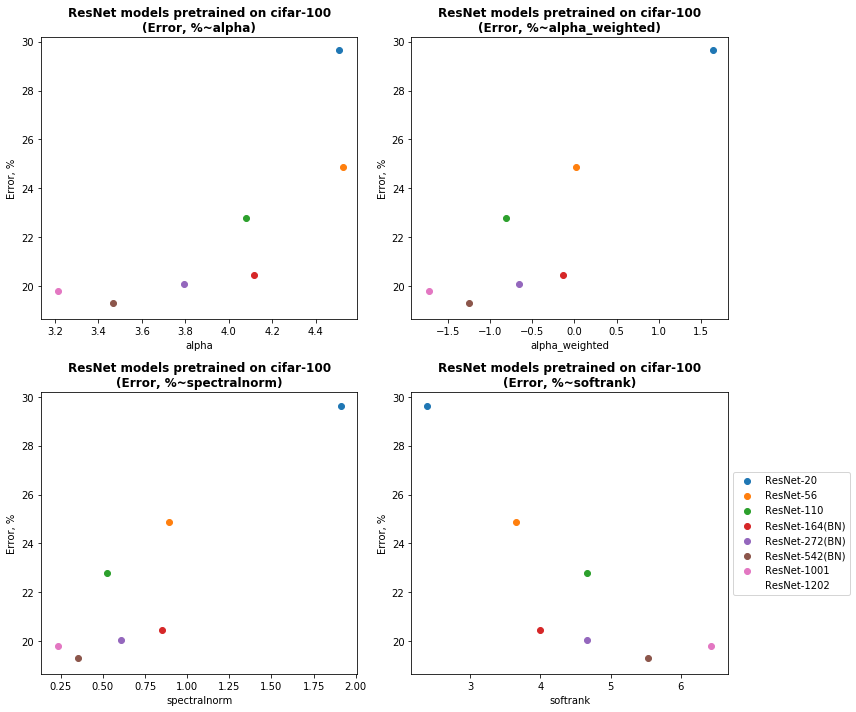

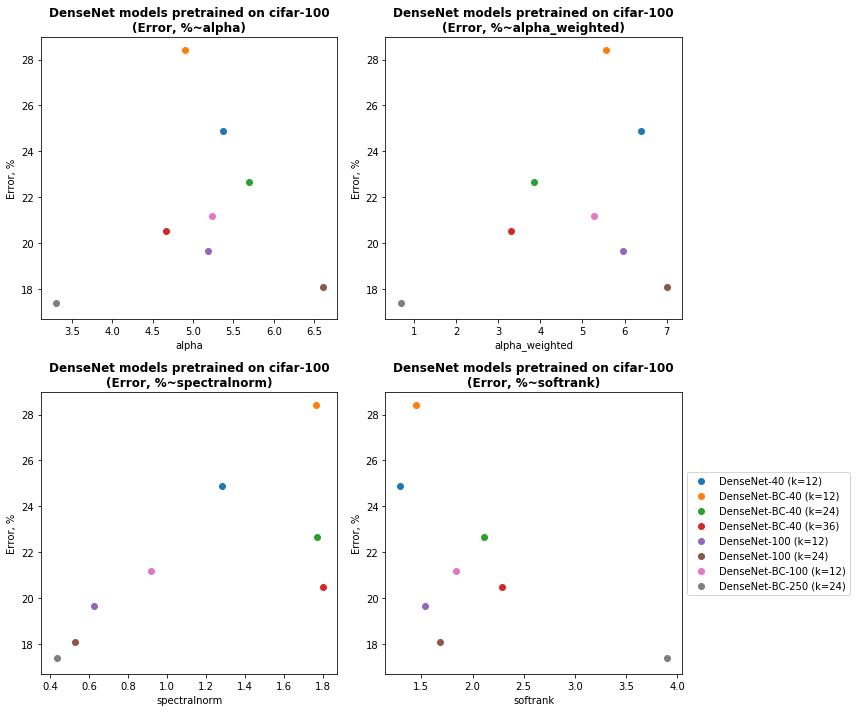

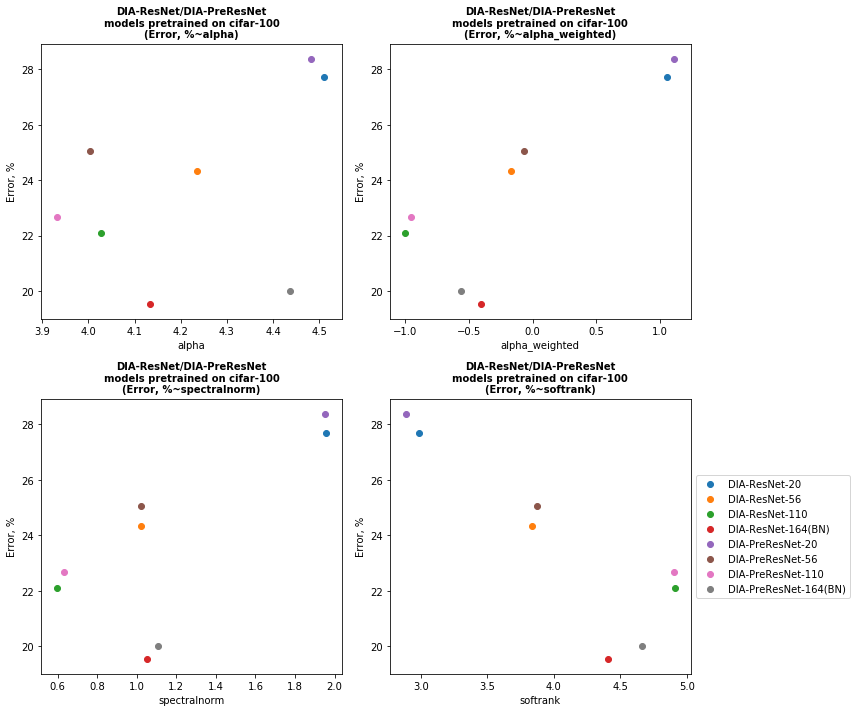

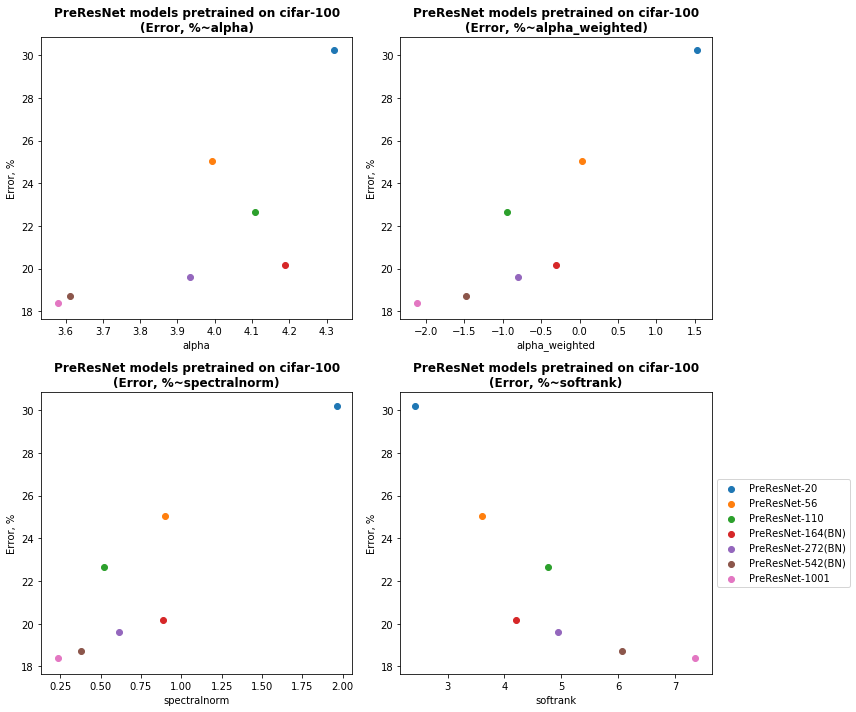

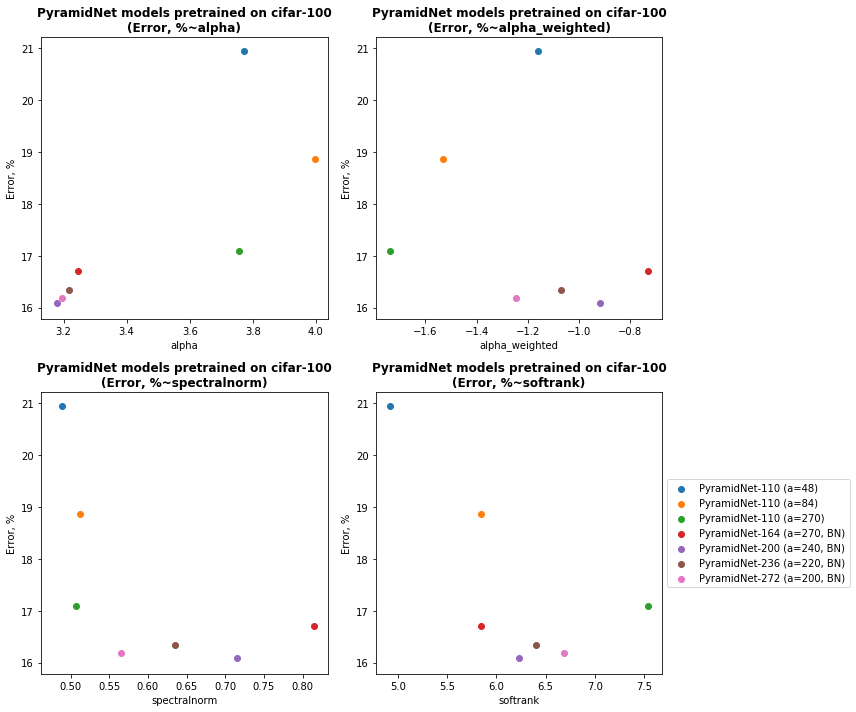

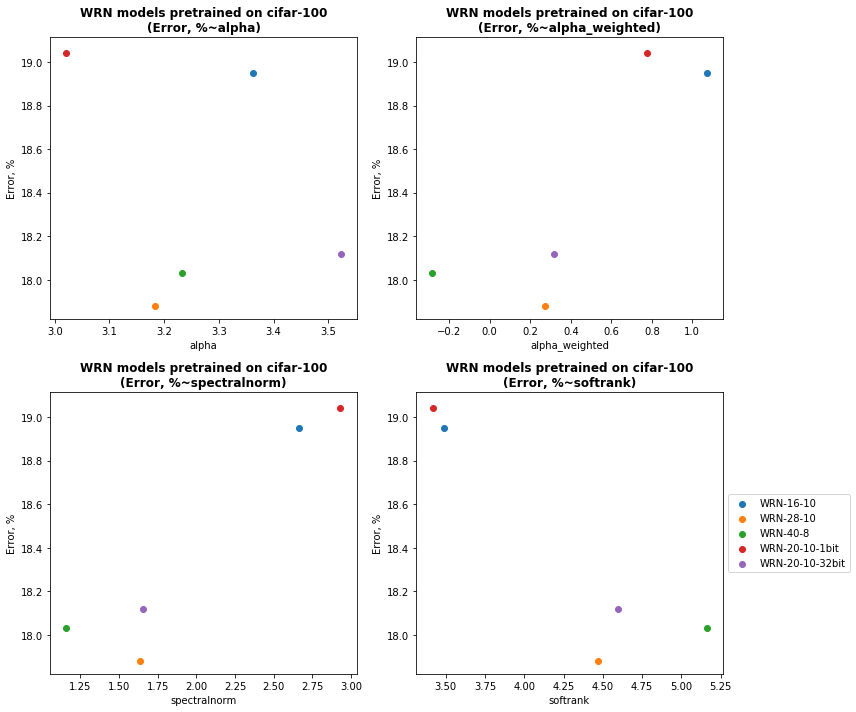

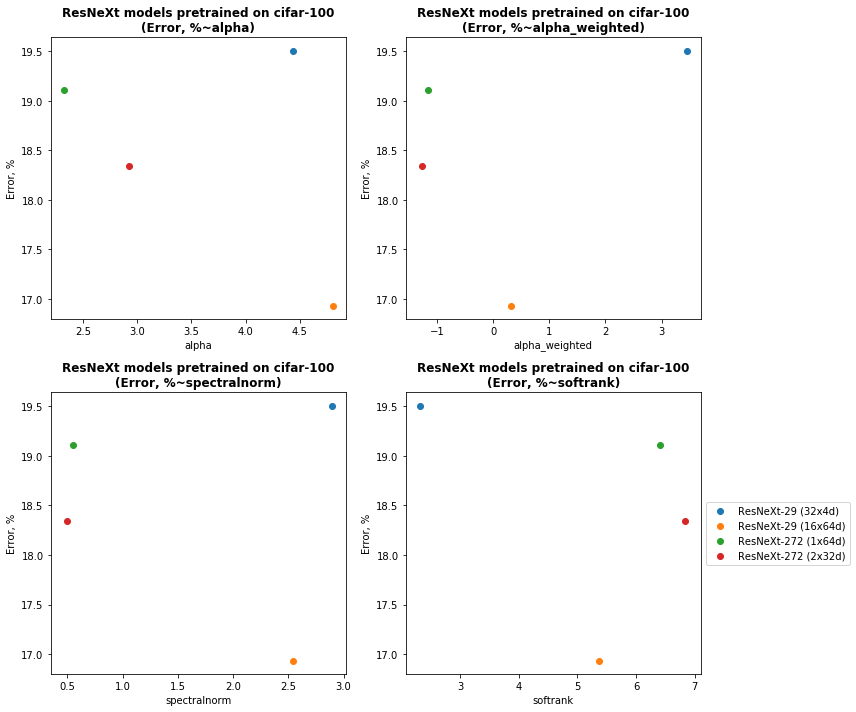

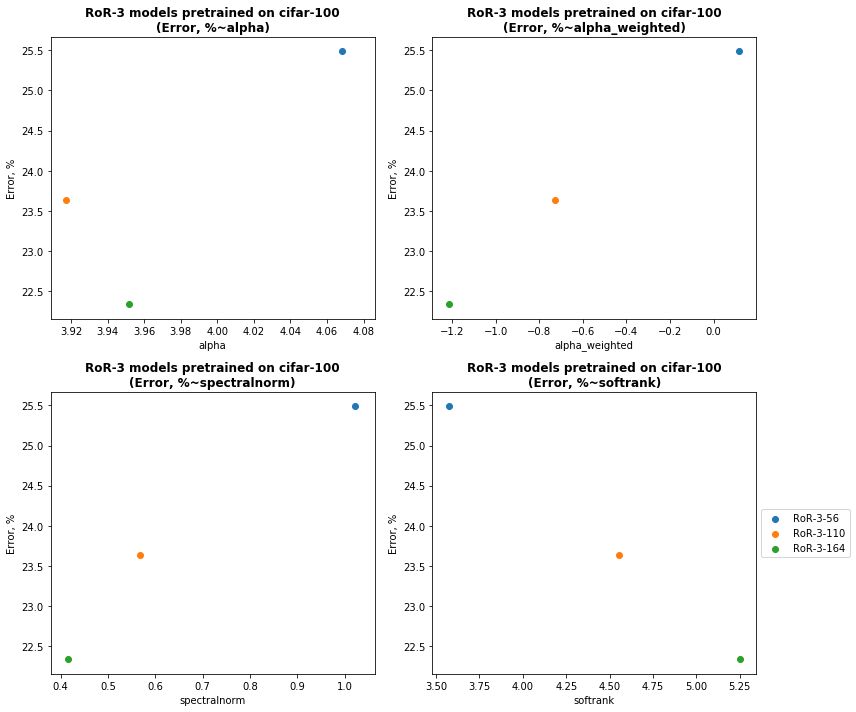

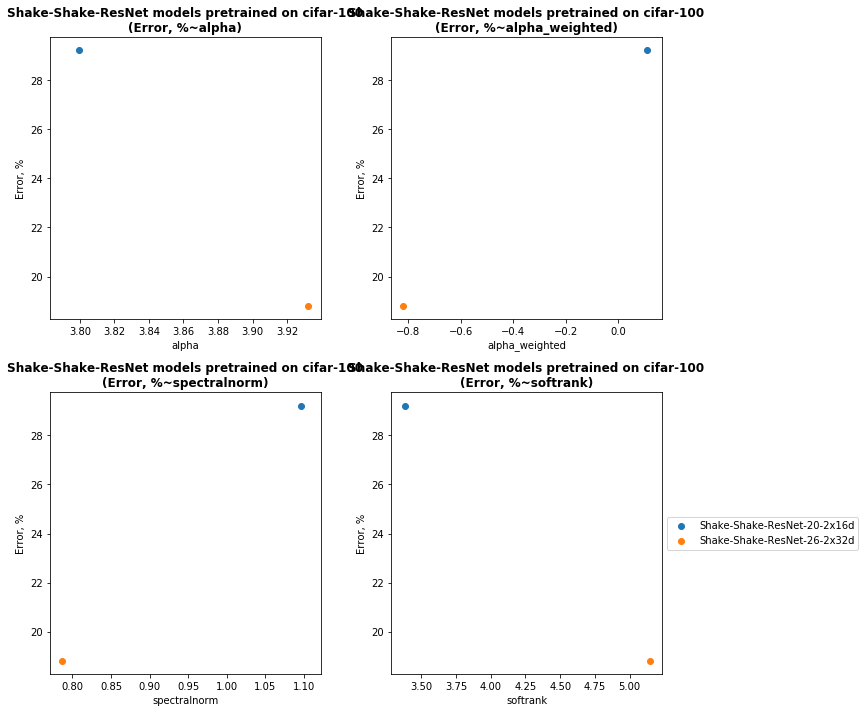

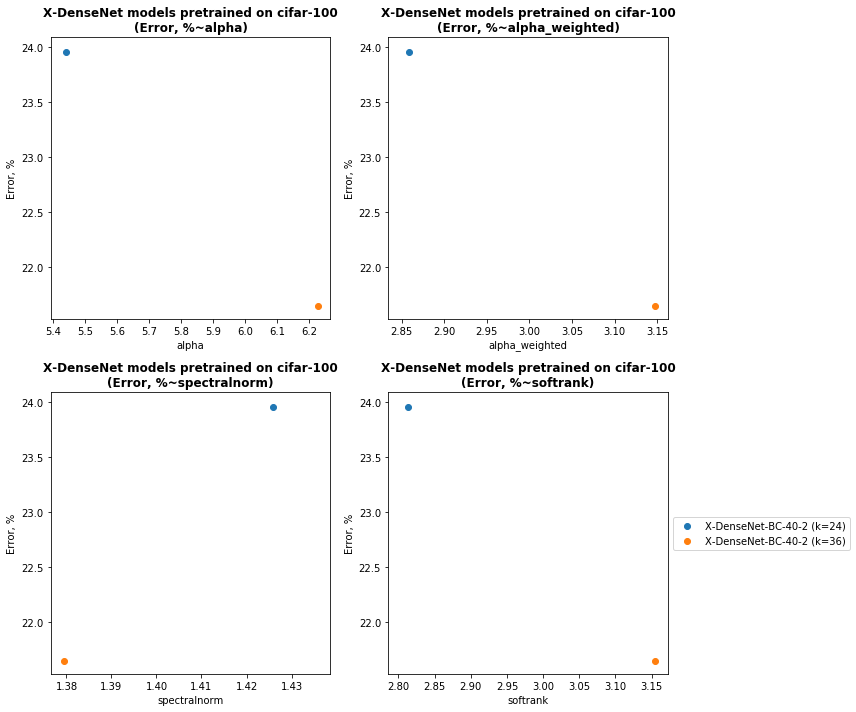

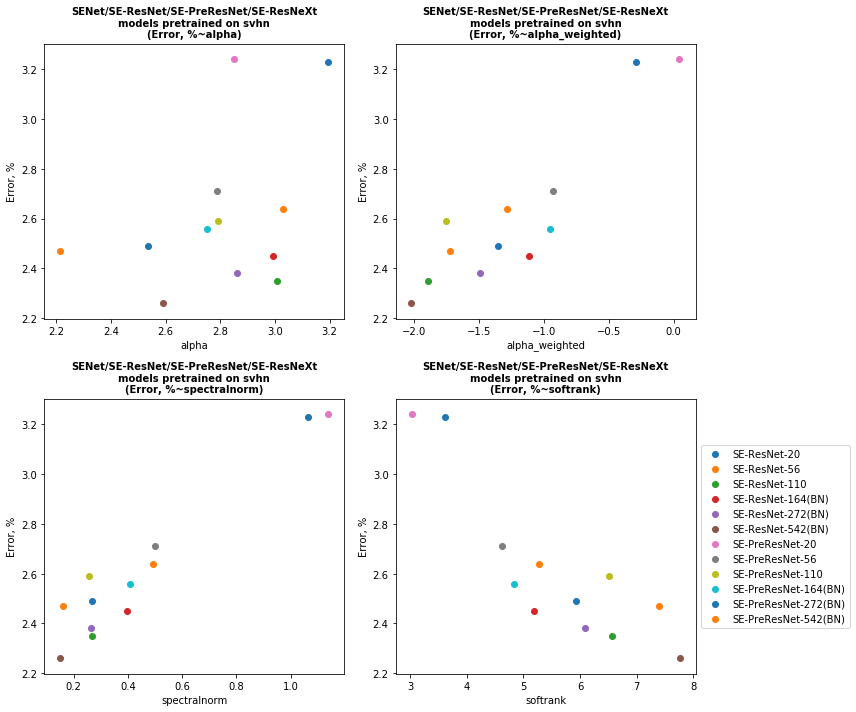

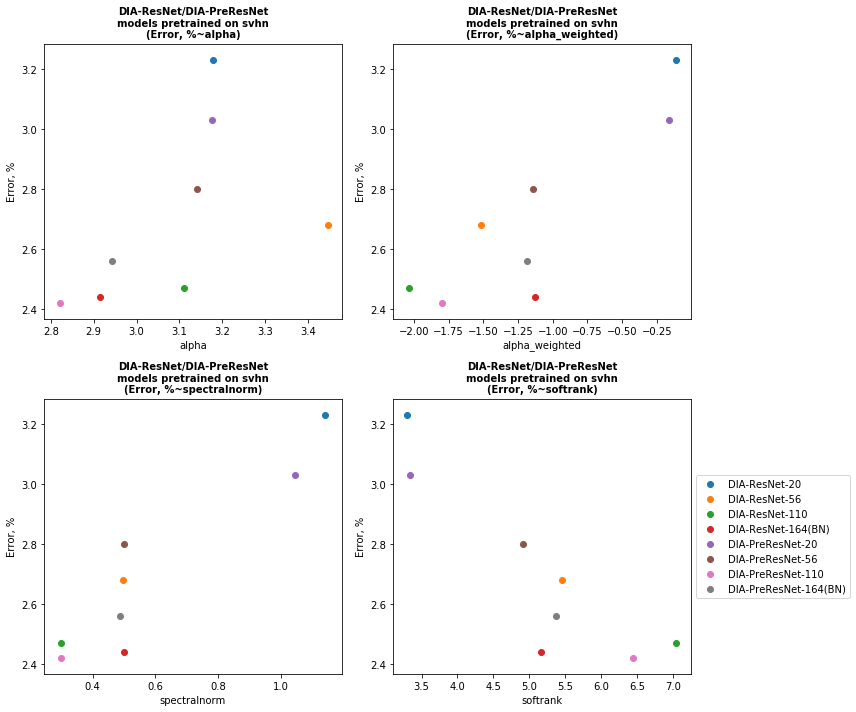

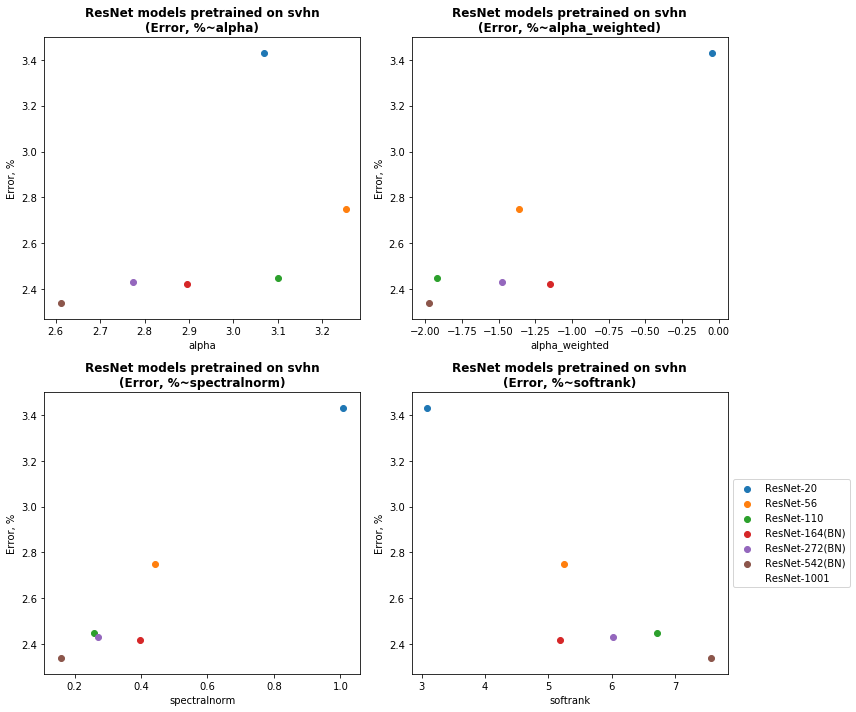

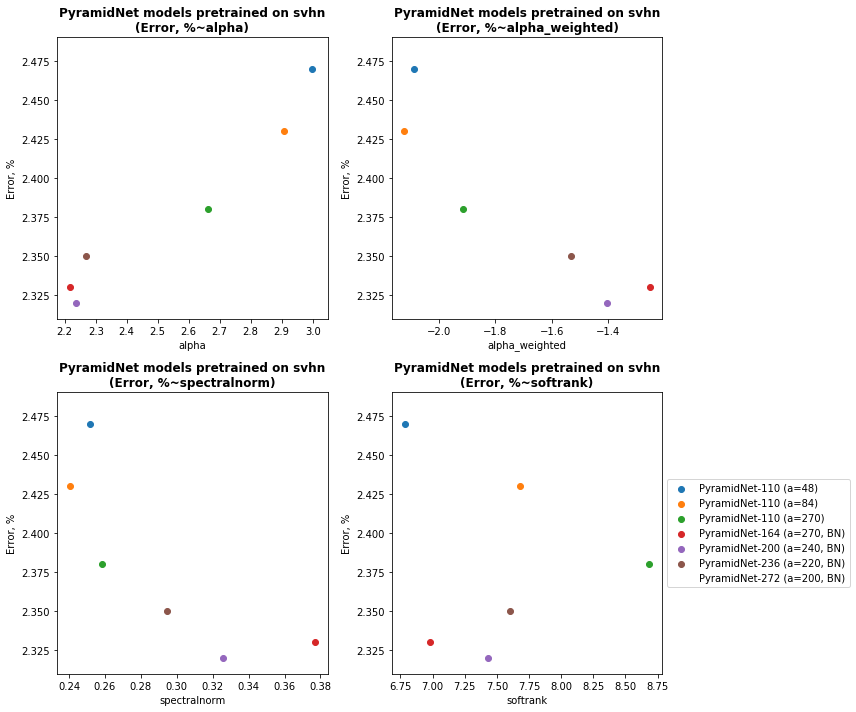

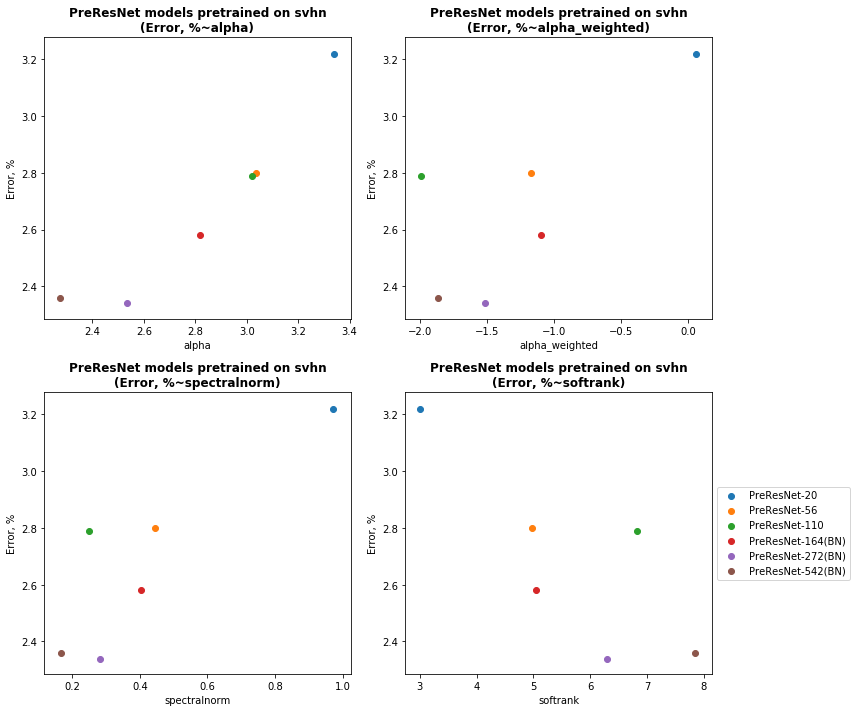

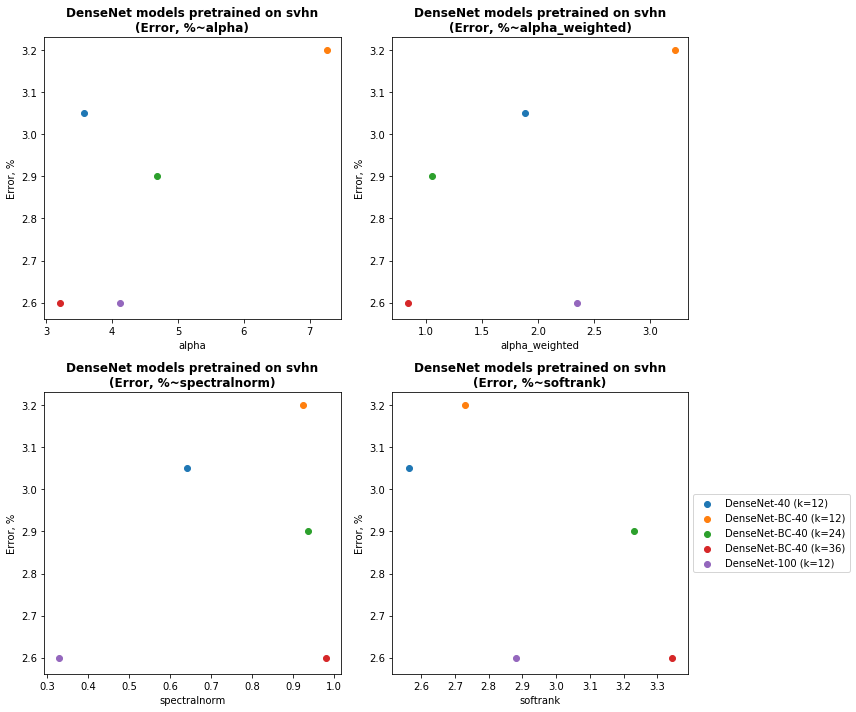

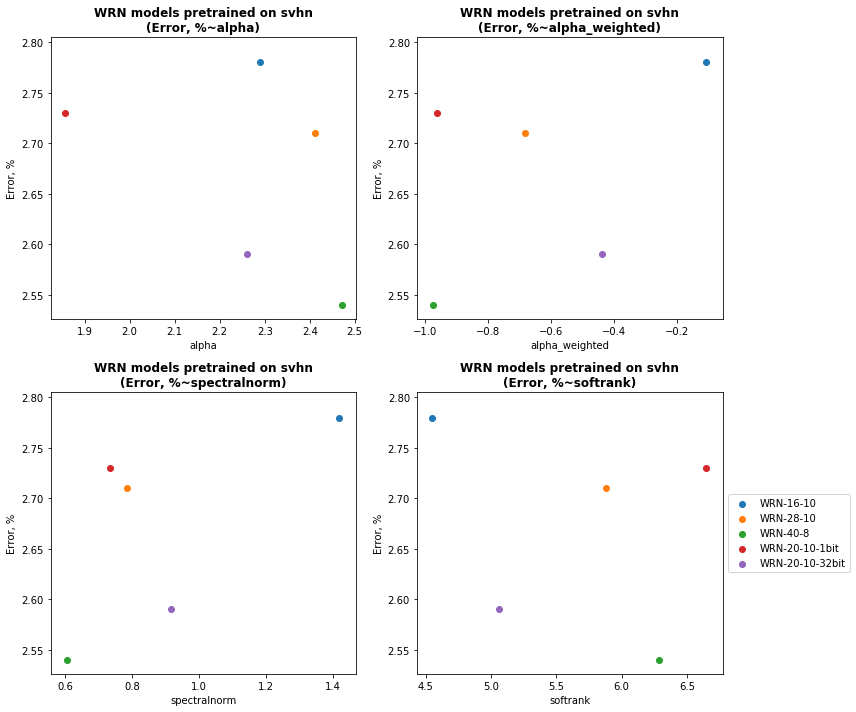

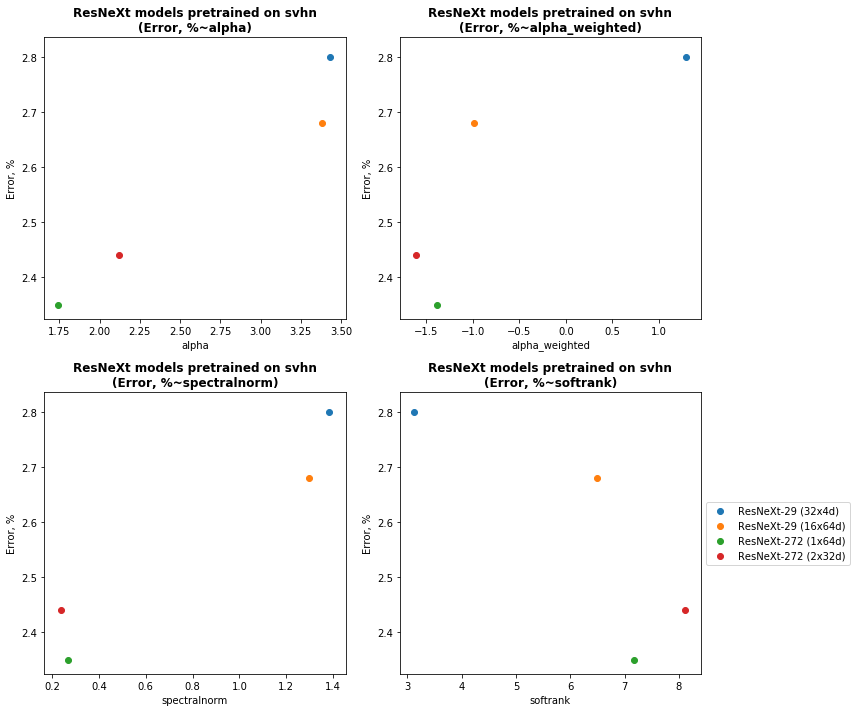

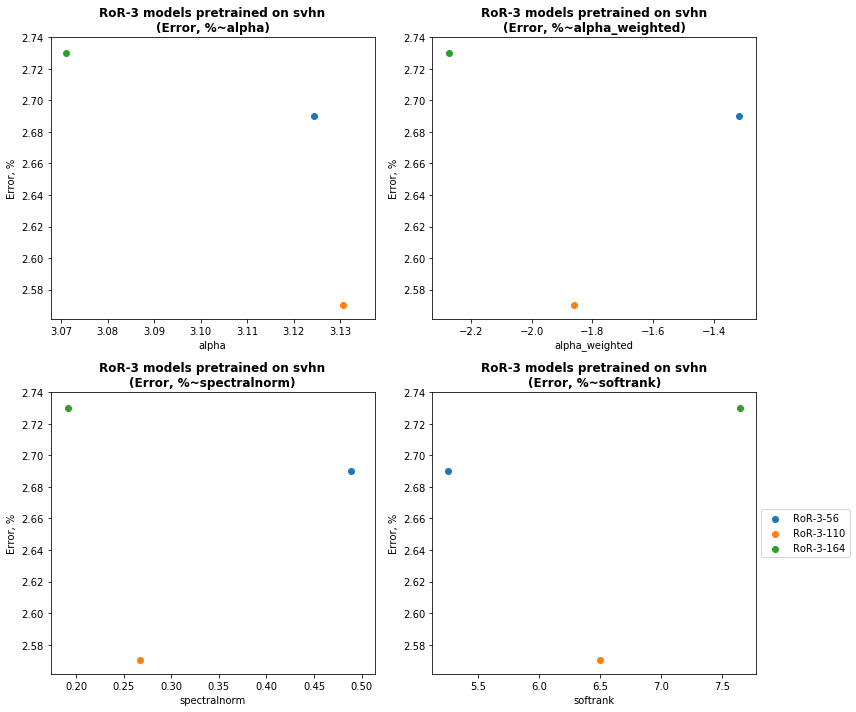

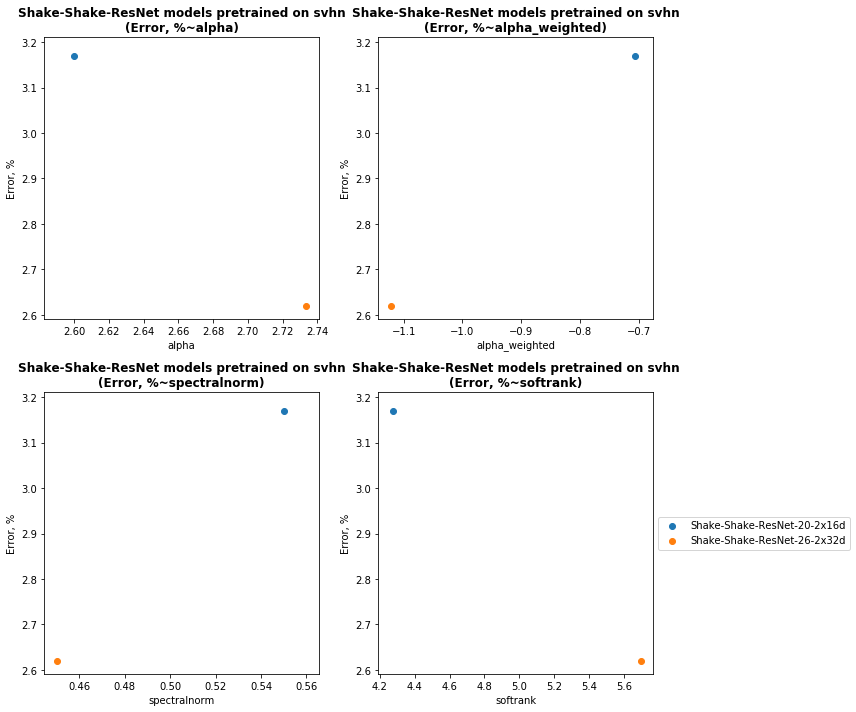

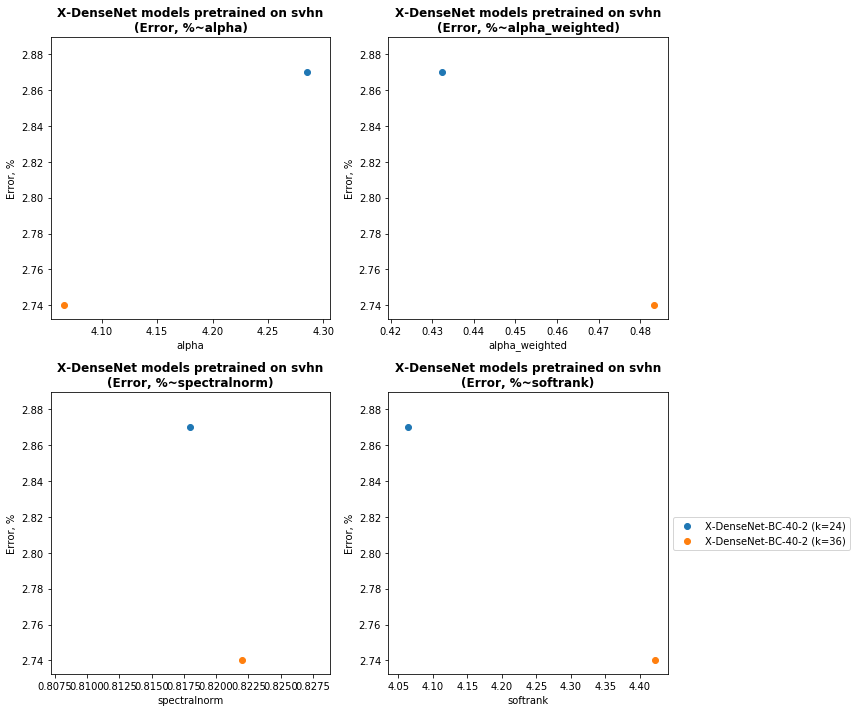

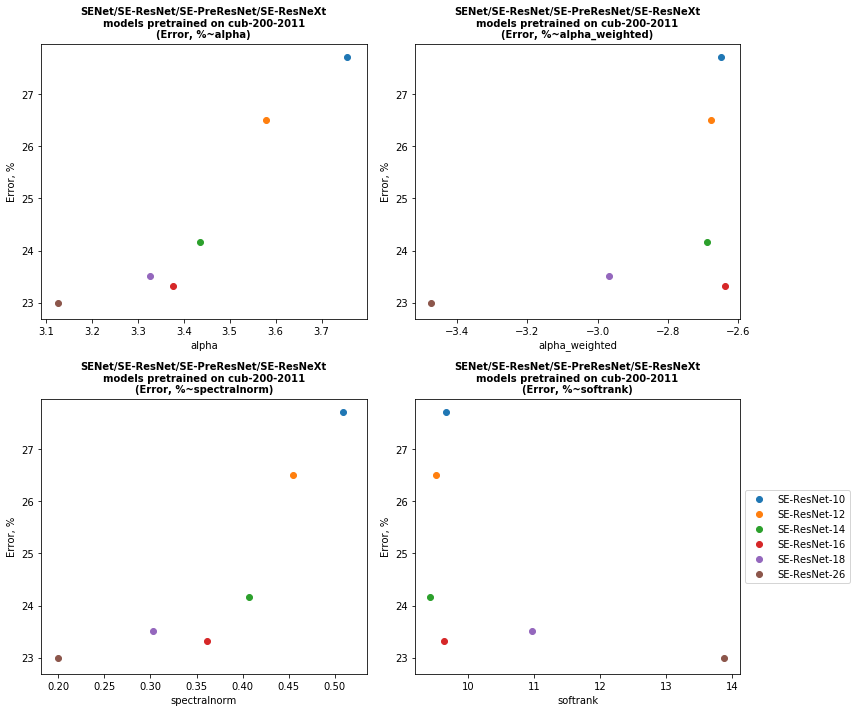

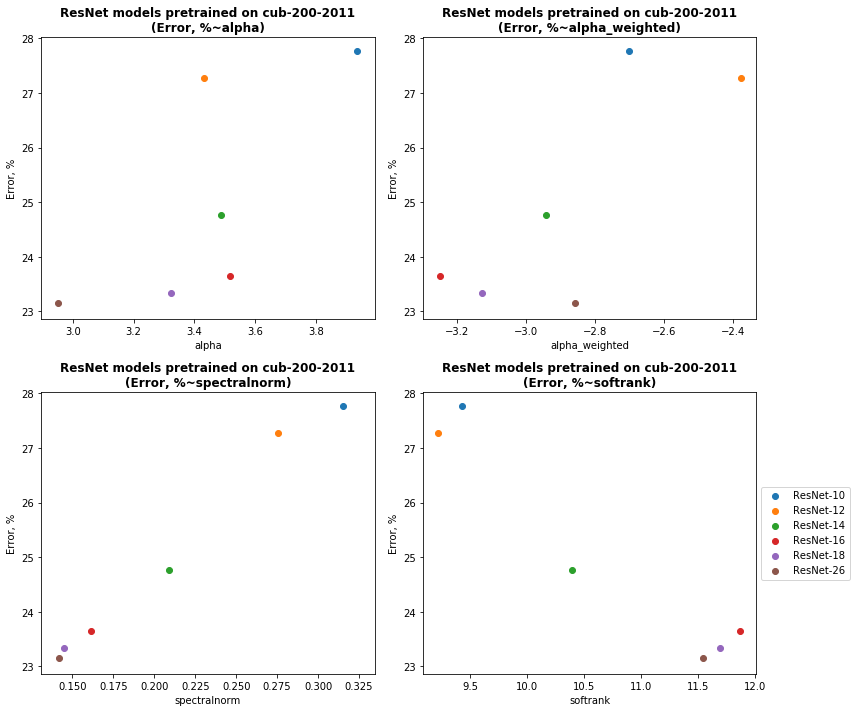

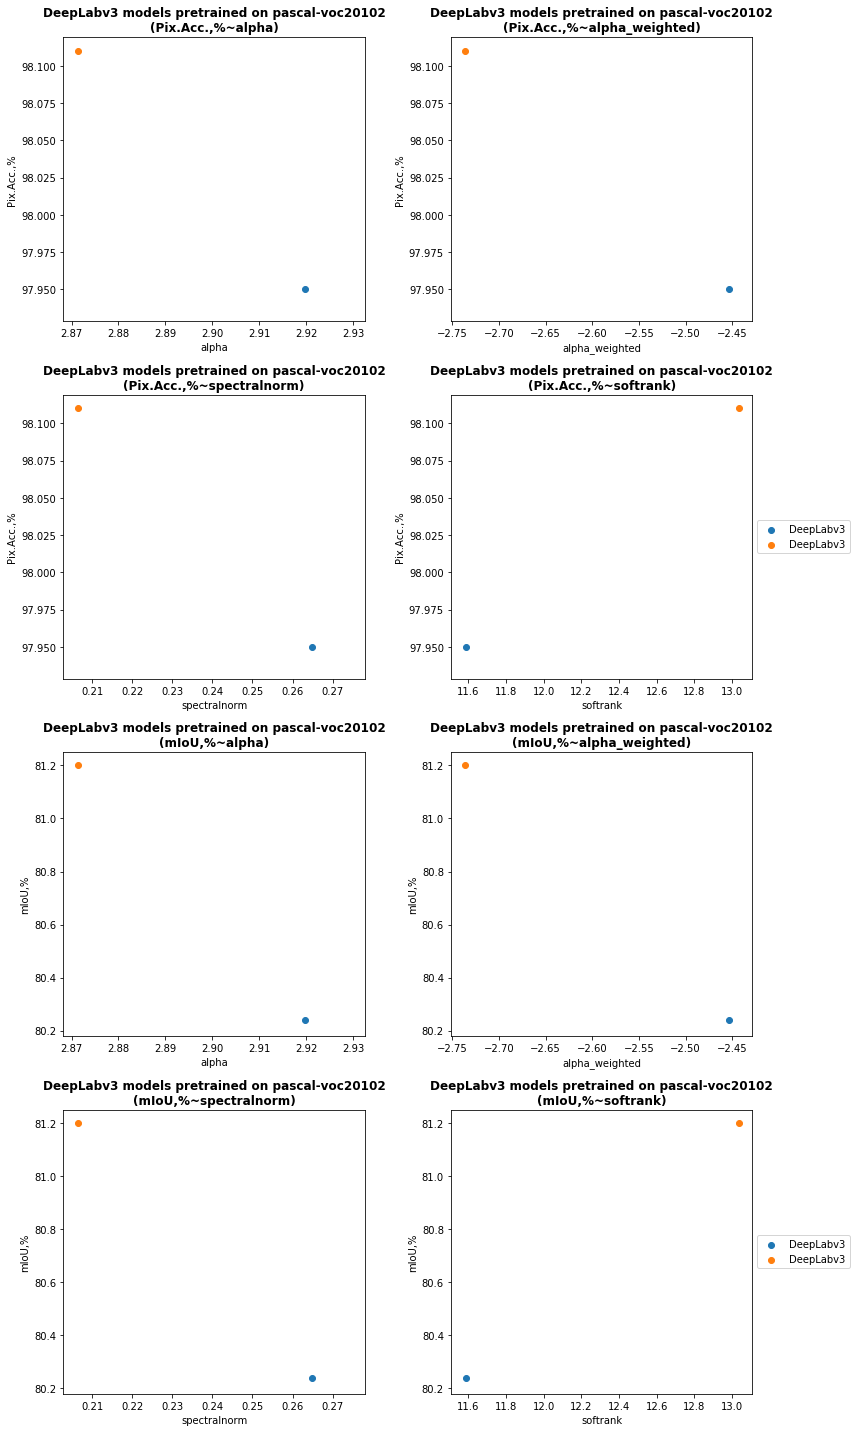

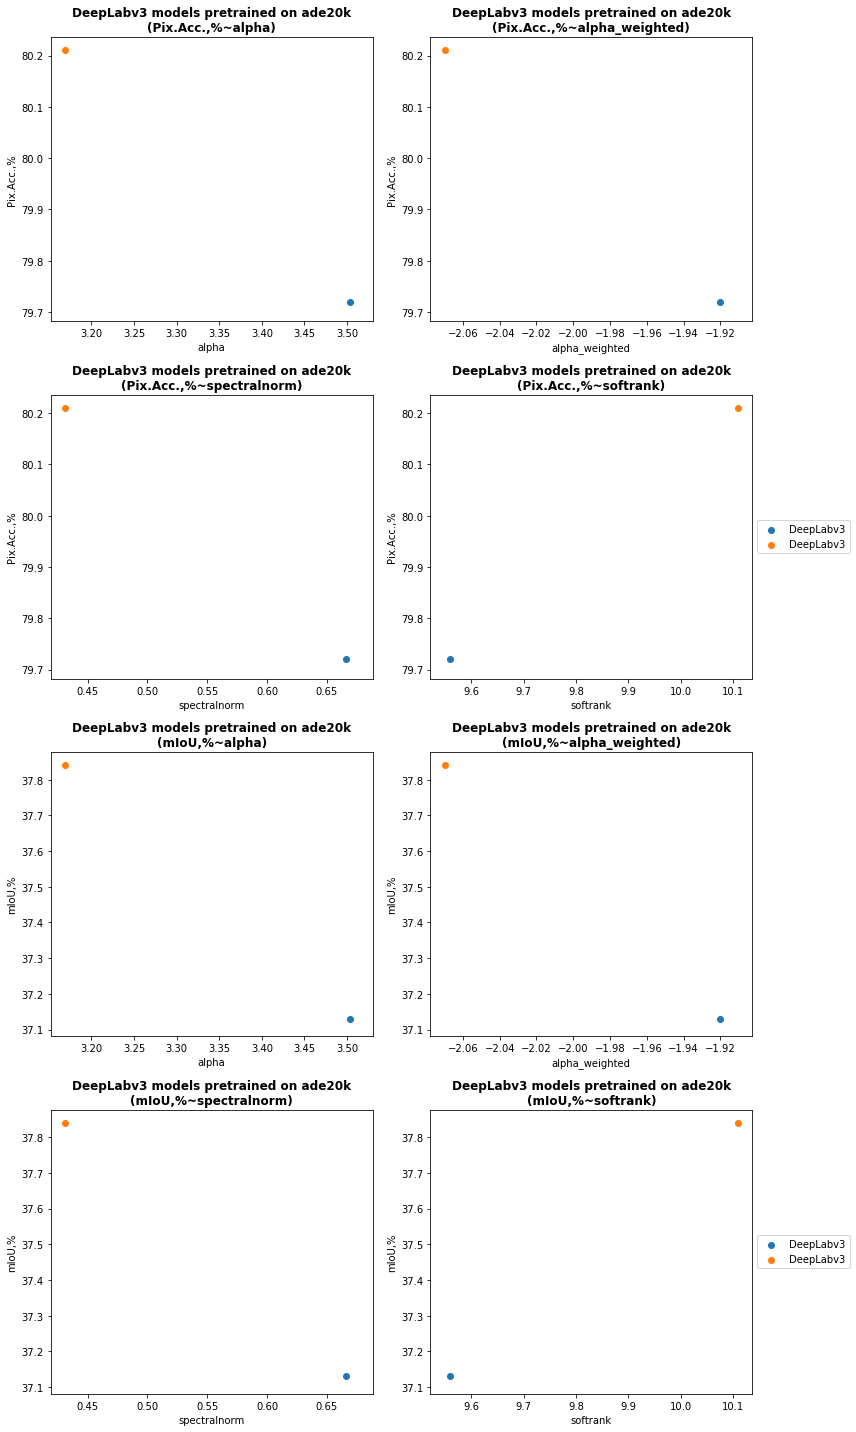

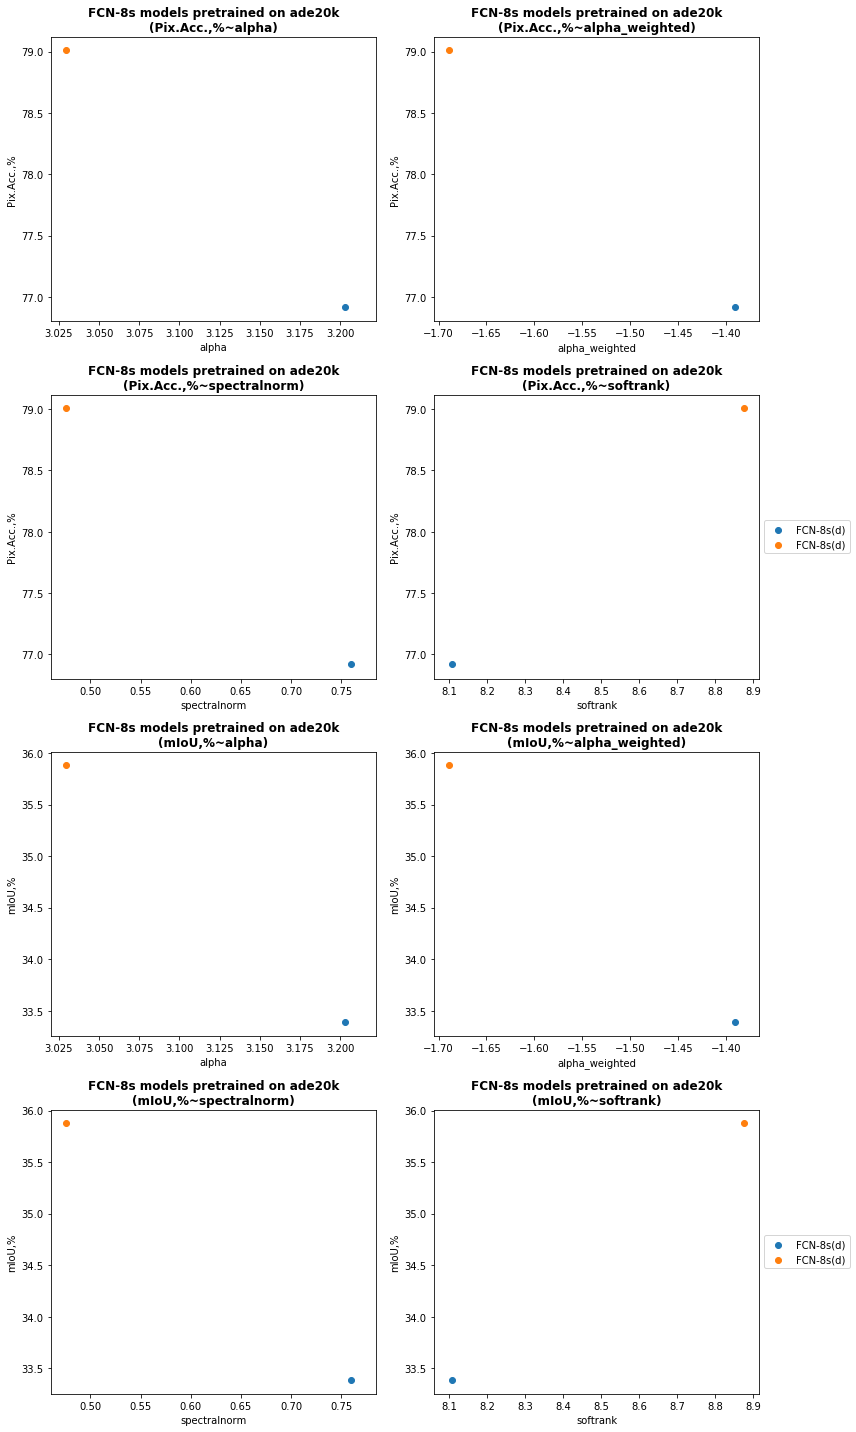

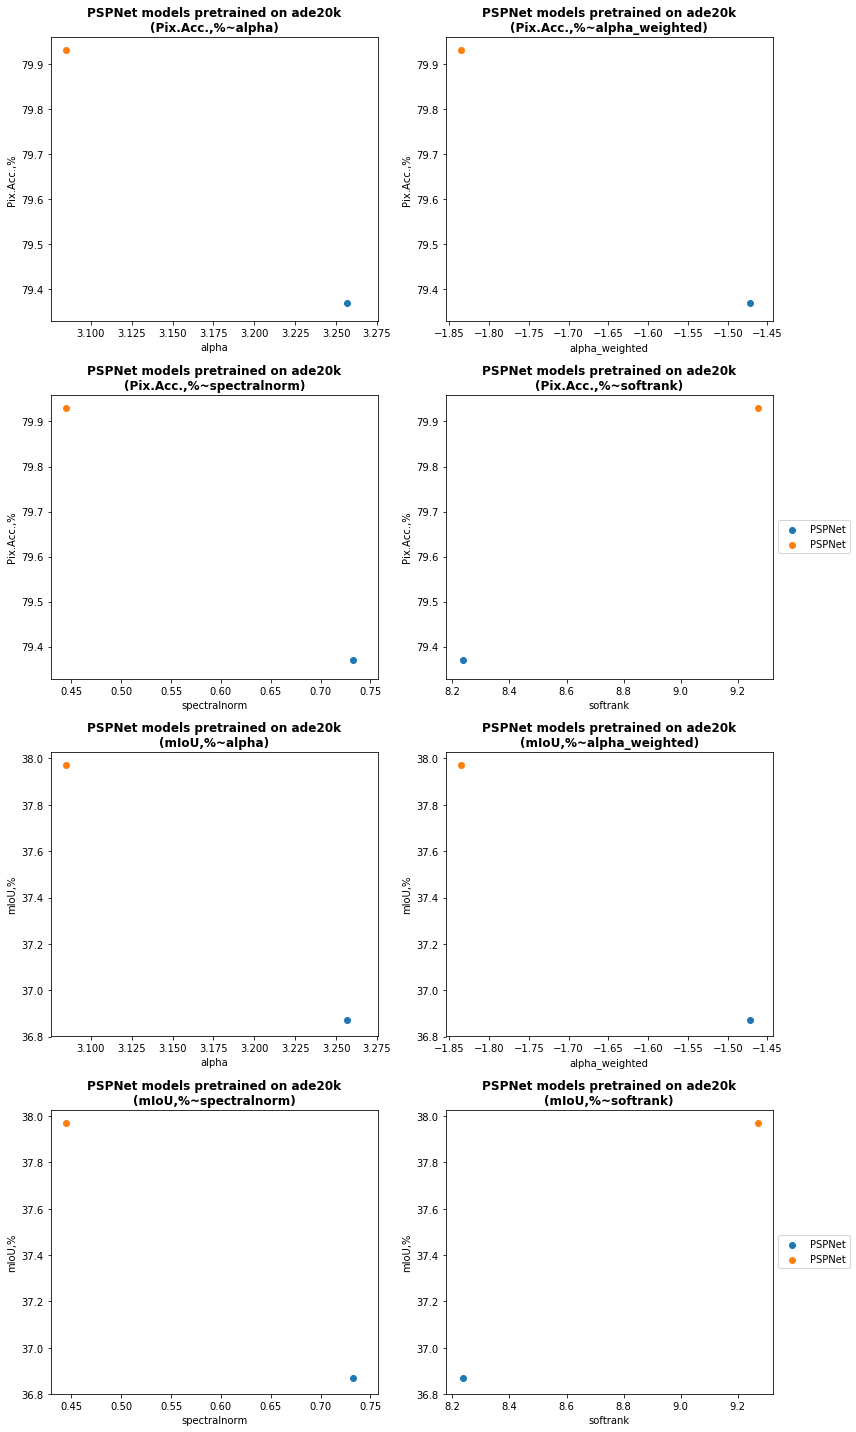

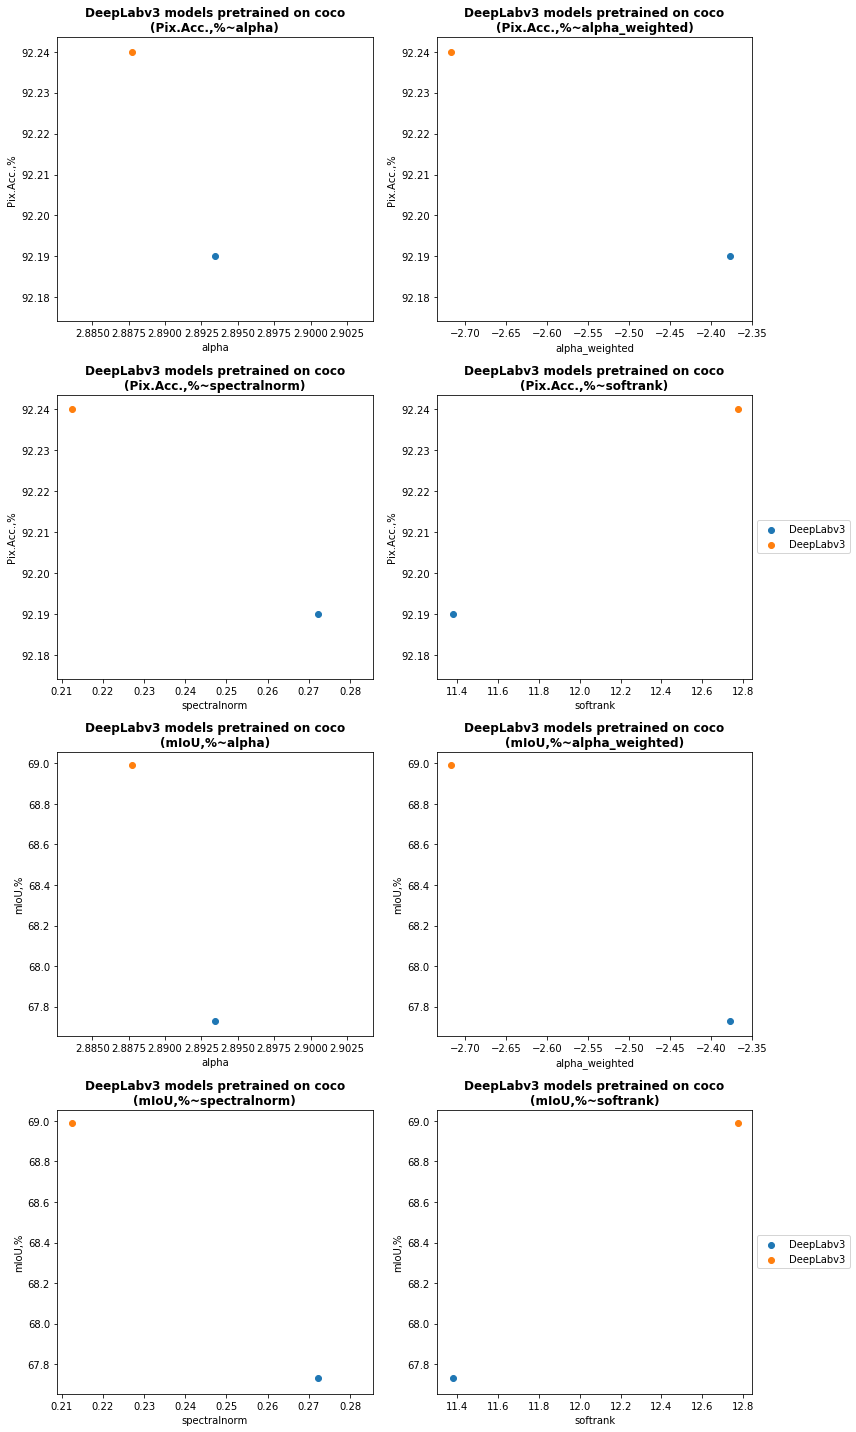

In [15]:
'''Plotting by architectures within each datasets'''
#Combine all datasets models together
#df_full2 = pd.DataFrame()
#for df in df_full.values():
#    df_full2 = pd.concat([df_full2, df], axis = 0, sort=False)
#df_full2 = df_full2.drop('Extractor', 1).dropna(subset = ['alpha']).reset_index(drop = True)

groups = df_table['group'].value_counts().to_frame()

for d in datasets:
    df = df_full[d].copy()
    this_groups = df['group'].value_counts().to_frame()

    for g in this_groups[this_groups['group'] > 1].index:

        this_group = df[df['group'] == g].copy()
        this_group = this_group.reset_index(drop = True)

        tacc = [c for c in metrics_acc if c in this_group.columns]

        plotloc = int(len(tacc)*len(metrics)/2*100 + 20 + 1)

        if len(tacc) > 1:
            plt.figure(figsize = (12,20))
        else:
            plt.figure(figsize = (12,10))

        for ac in tacc:#metrics_acc:
            for x in metrics:
                plt.subplot(plotloc)
                for i in range(len(this_group)):
                    plt.scatter(this_group.loc[i,x], this_group.loc[i, ac])
                plt.xlabel(x)
                plt.ylabel(ac)
                if len(g) > 20: #to avoid overlap in title
                    plt.title('{}\nmodels pretrained on {}\n({}~{})'.format(g, d, ac, x), 
                              fontweight = 'bold', fontsize = 10)
                else:
                    plt.title('{} models pretrained on {}\n({}~{})'.format(g, d, ac, x), 
                              fontweight = 'bold')

                plotloc += 1

            plt.legend(this_group['Model'], loc='center left', 
                       bbox_to_anchor=(1, 0.5))          
        plt.tight_layout()

del this_groups
del this_group

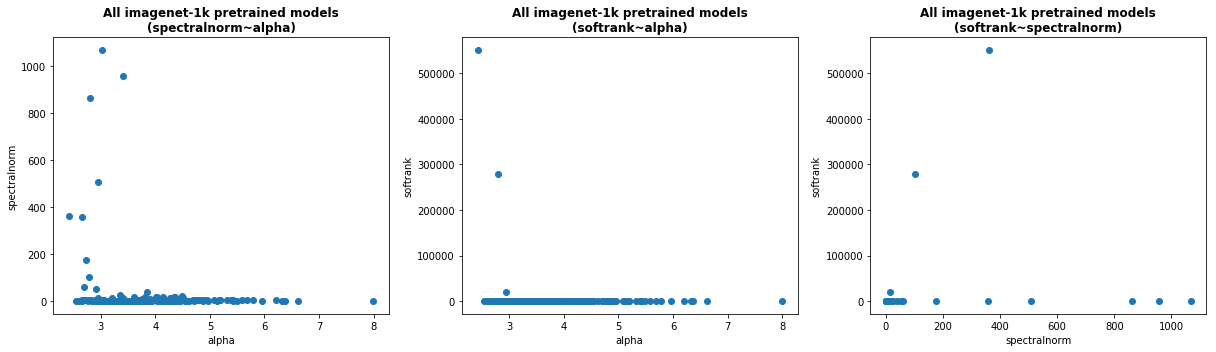

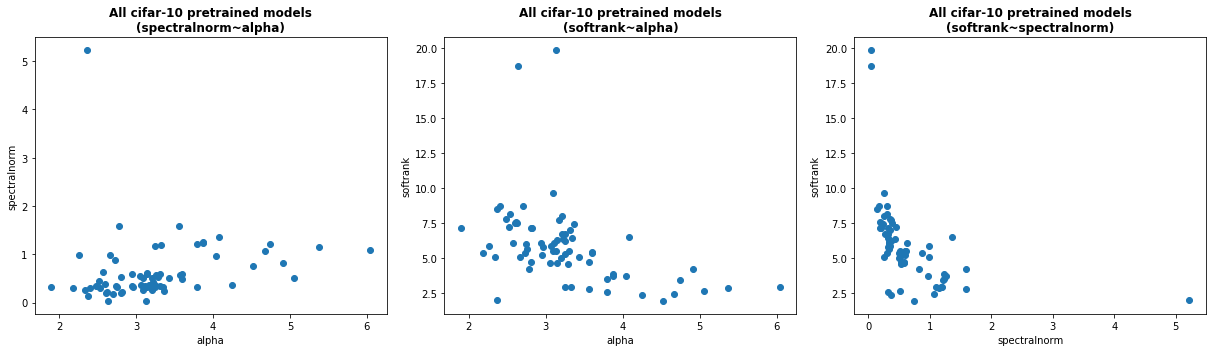

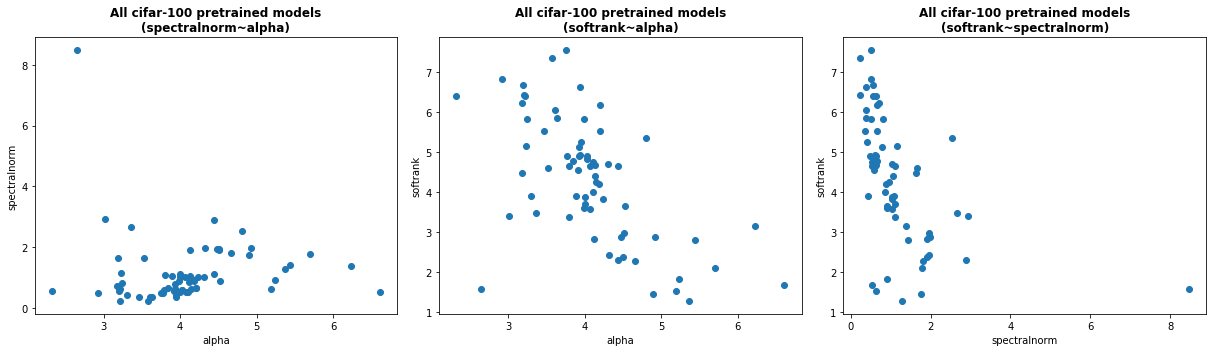

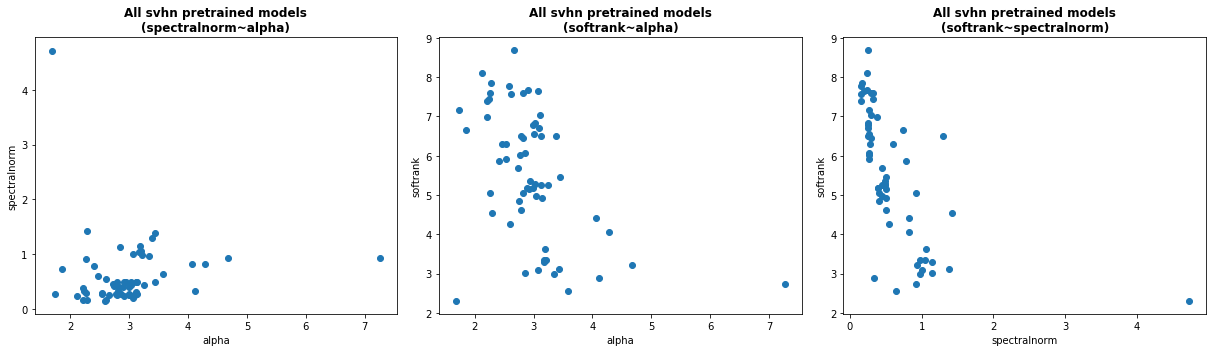

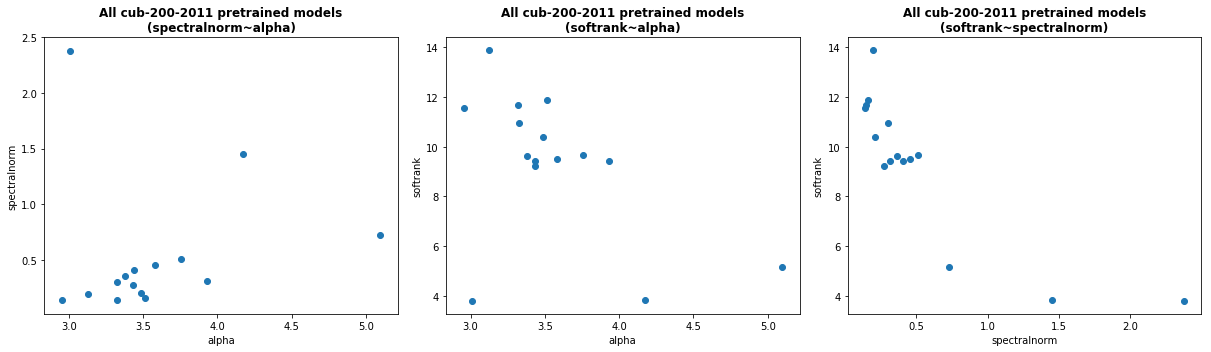

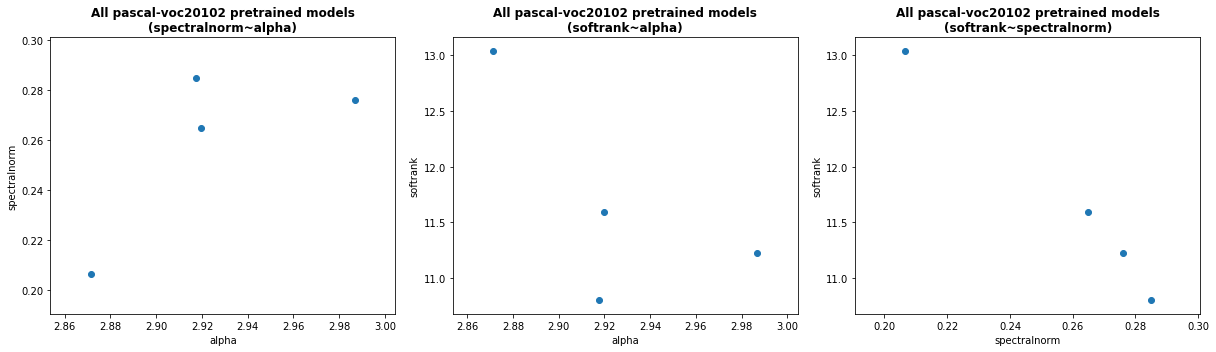

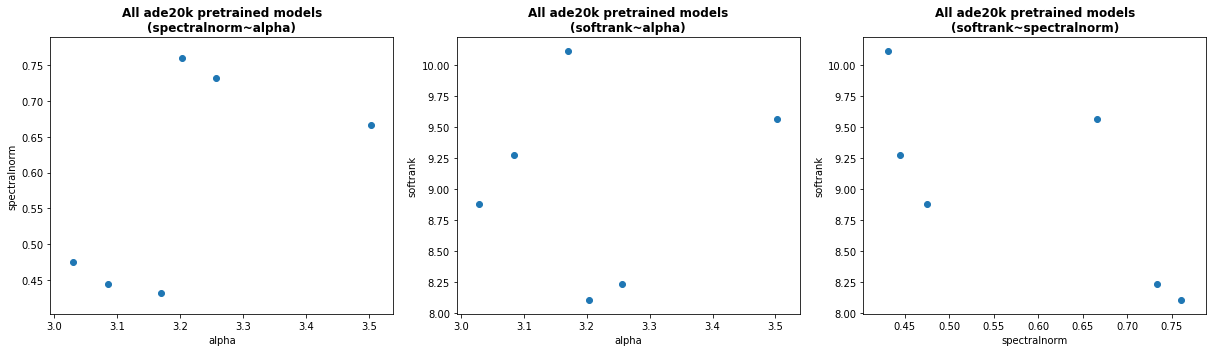

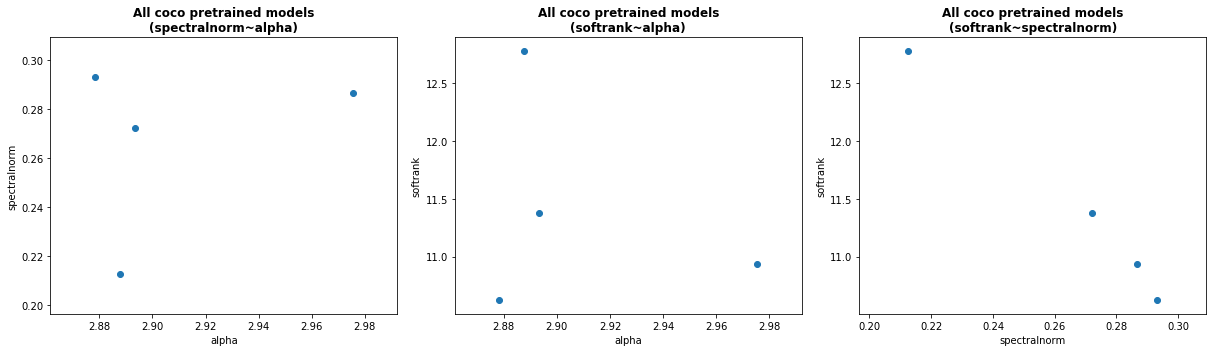

In [18]:
'''Between the ww metrics
no alpha_weighted'''

for d in datasets:
    temp = df_full[d].copy()

    if len(temp) == 1:
        continue

    plotloc = 131
    plt.figure(figsize = (17,5))
    for x, y in itertools.combinations( metrics[:1] + metrics[2:],2):
        plt.subplot(plotloc)
        plt.scatter(temp[x], temp[y])
        plt.xlabel(x)
        plt.ylabel(y)
        plt.title('All {} pretrained models\n({}~{})'.format(d, y, x), 
                  fontweight = 'bold')

        plotloc += 1

    plt.tight_layout()

del temp
